In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sns.set(context='notebook', style='whitegrid', palette='deep', 
        font='sans-serif', font_scale=2, color_codes=True, rc=None)

import os, gc
os.listdir('DataSet/')

['Train.csv', 'Sample_submission.csv', 'Test.csv']

In [2]:
train = pd.read_csv("DataSet/Train.csv")
test  = pd.read_csv("DataSet/Test.csv")

train.shape, test.shape

((17521, 2395), (20442, 2394))

In [3]:
# train['Col754']  = train['Col754'].replace('-',0).astype('float')
# train['Col843']  = train['Col843'].replace('-',0).astype('float')

# test['Col754']  = test['Col754'].replace('-',0).astype('float')
# test['Col843']  = test['Col843'].replace('-',0).astype('float')


train.drop(['Col747','Col836'], axis=1, inplace=True)
test.drop(['Col747','Col836'], axis=1, inplace=True)


In [13]:
for col in ['Col754','Col843','Col733', 'Col763', 'Col822', 'Col852', 'Col742', 'Col831']:
    test[col] = test[col].replace('-', np.nan).astype('float')
    train[col] = train[col].replace('-', np.nan).astype('float')

## handling null values

In [4]:
train = train.drop_duplicates()
nulls = train.isnull().sum(1).sort_values(ascending=False)

danger_idx = nulls[nulls >= 664].index
danger_idx = list(danger_idx)
len(danger_idx)

1094

In [5]:
print(train.shape, end=" ==> ")
train = train.drop(danger_idx, axis=0)
print(train.shape)

(17521, 2393) ==> (16427, 2393)


In [6]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import classification_report as cr
from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb


In [101]:
def train_cat_model(X_train, y_train, X_valid, y_valid, features, param, X_test, 
                    num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds, model, model_imp
    """
    param['iterations'] = num_round
    
    _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
    _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

    watchlist = [_train, _valid]
    clf = CatBoostClassifier(**param)
    clf.fit(_train, 
            eval_set=watchlist, 
            verbose=200,
            use_best_model=True)
        
    oof  = clf.predict_proba(X_valid[features])[:,1]
    test_pred  = clf.predict_proba(X_test[features])[:,1]

    cat_imp = pd.DataFrame(data=[clf.feature_names_, 
                                 list(clf.feature_importances_)]).T
    cat_imp.columns = ['feature','imp']
    
    return oof, test_pred, clf, cat_imp


def run_cv_cat(train_df, target, test_df, depth):

    params = {
        'loss_function'         : "Logloss", 
        'eval_metric'           : "AUC",
        'random_strength'       : 3.8,#1.5,
        'border_count'          : 128,
        'scale_pos_weight'      : 3.507,
        'depth'                 : depth, 
        'early_stopping_rounds' : 50,
        'random_seed'           : 1337,
        'task_type'             : 'CPU', 
#         'subsample'             = 0.7, 
        'iterations'            : 10000, 
        'learning_rate'         : 0.05,#0.09,
        'thread_count'          : 4,
        'l2_leaf_reg'           : 3.076,
    }
#     {'depth': 7.0,
#      'l2_leaf_reg': 3.0753960899722625,
#      'learning_rate': 0.063,
#      'random_strength': 3.8000000000000003}

    ##########################
    n_splits = 6
    random_seed = 1234
    feature_imp = pd.DataFrame()
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_cat = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))
    clfs = []
    f1s = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        
        num_rounds = 10000
        oof, test_pred, clf, cat_imp = train_cat_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, params, 
                                                       test_df, num_rounds)
    
        oof_cat[valid_index] = oof
        predictions[:,fold_] = test_pred
        
        cat_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, cat_imp], axis=0)
        clfs.append(clf)
        
        score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
        score = f1_score(y_valid, y_bin, average='weighted')
        print( "  f1 = ", score )
        print("="*60)
        gc.collect()
        f1s.append(score)
        
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')

    return clfs, feature_imp, oof_cat, predictions, np.mean(f1s)


In [ ]:
def train_cat_model(X_train, y_train, X_valid, y_valid):
    params = {
        'loss_function'         : "Logloss", 
        'eval_metric'           : "AUC",
        'random_strength'       : 3.8,#1.5,
        'border_count'          : 128,
        'scale_pos_weight'      : 3.507,
        'depth'                 : depth, 
        'early_stopping_rounds' : 50,
        'random_seed'           : 1337,
        'task_type'             : 'CPU', 
#         'subsample'             = 0.7, 
        'iterations'            : 10000, 
        'learning_rate'         : 0.05,#0.09,
        'thread_count'          : 4,
        'l2_leaf_reg'           : 3.076,
    }
    param['iterations'] = 10000
    features = X_train.columns
    
    _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
    _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

    watchlist = [_train, _valid]
    clf = CatBoostClassifier(**param)
    clf.fit(_train, 
            eval_set=watchlist, 
            verbose=200,
            use_best_model=True)
        
    oof  = clf.predict_proba(X_valid[features])[:,1]
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
    score = f1_score(y_valid, y_bin, average='weighted')
    print( "  f1 = ", score )
    print("============================================================")
    
    cat_imp = pd.DataFrame(data=[clf.feature_names_, list(clf.feature_importances_)]).T
    cat_imp.columns = ['feature','imp']
    cat_imp = cat_imp.sort_values(by='imp', ascending=True)

    return oof, cat_imp


def run_cv_cat(train_df, target, test_df, depth):

    params = {
        'loss_function'         : "Logloss", 
        'eval_metric'           : "AUC",
        'random_strength'       : 3.8,#1.5,
        'border_count'          : 128,
        'scale_pos_weight'      : 3.507,
        'depth'                 : depth, 
        'early_stopping_rounds' : 50,
        'random_seed'           : 1337,
        'task_type'             : 'CPU', 
#         'subsample'             = 0.7, 
        'iterations'            : 10000, 
        'learning_rate'         : 0.05,#0.09,
        'thread_count'          : 4,
        'l2_leaf_reg'           : 3.076,
    }

    ##########################
    n_splits = 3
    random_seed = 1234
    feature_imp = pd.DataFrame()
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_cat = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))
    clfs = []
    f1s = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        
        num_rounds = 10000
        oof, clf, cat_imp = train_cat_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, params, 
                                                       test_df, num_rounds)
    
        oof_cat[valid_index] = oof
#         predictions[:,fold_] = test_pred
        
        cat_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, cat_imp], axis=0)
        clfs.append(clf)
        
        score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
        score = f1_score(y_valid, y_bin, average='weighted')
        print( "  f1 = ", score )
        print("="*60)
        gc.collect()
        f1s.append(score)
        
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')

    return clfs, feature_imp, np.mean(f1s)


In [9]:
# train = train.astype('category')
target = train['Col2']
tr_ids = train['Col1']
ts_ids = test['Col1']
train.drop(['Col1','Col2'], axis=1, inplace=True)
test.drop('Col1', axis=1, inplace=True)

In [10]:
# clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train, target, test, depth=3)

# ybins = [1.0 if y > 0.5 else 0 for y in oof_cat1]
# print(cr(target, ybins))

(13688,) (2739,)
Fold 0
0:	test: 0.5854746	test1: 0.6035861	best: 0.6035861 (0)	total: 231ms	remaining: 38m 33s
200:	test: 0.7574021	test1: 0.7477422	best: 0.7477422 (200)	total: 28.1s	remaining: 22m 48s
400:	test: 0.7941577	test1: 0.7566487	best: 0.7566487 (399)	total: 57.4s	remaining: 22m 54s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7588322059
bestIteration = 538

Shrink model to first 539 iterations.
  auc =  0.7588322059124979
  f1 =  0.876776199798636
(13689,) (2738,)
Fold 1
0:	test: 0.6142429	test1: 0.6020195	best: 0.6020195 (0)	total: 188ms	remaining: 31m 21s
200:	test: 0.7613168	test1: 0.7459651	best: 0.7459651 (200)	total: 27.5s	remaining: 22m 23s
400:	test: 0.7994564	test1: 0.7527294	best: 0.7533357 (373)	total: 53.5s	remaining: 21m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7533357109
bestIteration = 373

Shrink model to first 374 iterations.
  auc =  0.753335710942202
  f1 =  0.8698100943720309
(13689,) (2738,)
Fold 2


In [17]:
imp = pd.read_csv('predictions/xgb5_working.csv')
imp

feature        imp
0      Col339   1.000000
1      Col806   1.000000
2     Col2101   1.000000
3     Col2108   1.000000
4     Col2119   1.000000
5     Col2122   1.000000
6     Col2123   1.000000
7      Col801   1.000000
8     Col2135   1.000000
9     Col2136   1.000000
10    Col2138   1.000000
11    Col2142   1.000000
12    Col2143   1.000000
13      Col80   1.000000
14     Col216   1.000000
15    Col2177   1.000000
16     Col807   1.000000
17     Col799   1.000000
18    Col2096   1.000000
19    Col2090   1.000000
20    Col2026   1.000000
21    Col2027   1.000000
22    Col2028   1.000000
23    Col2030   1.000000
24    Col2034   1.000000
25    Col2035   1.000000
26    Col2046   1.000000
27     Col817   1.000000
28    Col2059   1.000000
29    Col2061   1.000000
30    Col2075   1.000000
31    Col2076   1.000000
32    Col2077   1.000000
33     Col812   1.000000
34    Col2087   1.000000
35    Col2092   1.000000
36    Col2021   1.000000
37    Col2181   1.000000
38     Col798   1.000000
39    Col2370   1.000000
40    Col2371   1.000000
41     Col785   1.000000
42    Col2388   1.000000
43     Col239   1.000000
44    Col2391   1.000000
45      Col78   1.000000
46     Col779   1.000000
47    Col2396   1.000000
48    Col2397   1.000000
49     Col777   1.000000
50      Col77   1.000000
51     Col768   1.000000
52     Col249   1.000000
53     Col767   1.000000
54     Col237   1.000000
55    Col2191   1.000000
56    Col2359   1.000000
57     Col235   1.000000
58    Col2208   1.000000
59    Col2210   1.000000
60    Col2218   1.000000
61    Col2229   1.000000
62    Col2238   1.000000
63    Col2256   1.000000
64      Col79   1.000000
65    Col2261   1.000000
66     Col227   1.000000
67    Col2274   1.000000
68     Col788   1.000000
69    Col2303   1.000000
70    Col2308   1.000000
71    Col2323   1.000000
72    Col2335   1.000000
73    Col2358   1.000000
74     Col251   1.000000
75     Col819   1.000000
76     Col201   1.000000
77     Col187   1.000000
78      Col84   1.000000
79    Col1876   1.000000
80    Col1877   1.000000
81    Col1885   1.000000
82     Col838   1.000000
83    Col1890   1.000000
84    Col1892   1.000000
85    Col1895   1.000000
86    Col1896   1.000000
87    Col1900   1.000000
88    Col1901   1.000000
89     Col191   1.000000
90    Col1912   1.000000
91     Col833   1.000000
92    Col1869   1.000000
93    Col1915   1.000000
94    Col1866   1.000000
95    Col1862   1.000000
96    Col1819   1.000000
97     Col843   1.000000
98    Col1820   1.000000
99    Col1823   1.000000
...       ...        ...
1069   Col871   4.500000
1070    Col67   4.500000
1071   Col873   4.500000
1072   Col167   4.500000
1073   Col775   4.500000
1074   Col305   4.750000
1075   Col247   4.750000
1076   Col107   4.750000
1077   Col900   4.750000
1078   Col444   4.750000
1079   Col627   4.750000
1080    Col24   4.750000
1081   Col497   4.750000
1082   Col931   4.750000
1083   Col196   5.000000
1084   Col719   5.000000
1085   Col878   5.000000
1086   Col598   5.000000
1087    Col48   5.000000
1088   Col932   5.000000
1089   Col383   5.000000
1090   Col231   5.000000
1091     Col7   5.000000
1092   Col212   5.000000
1093   Col762   5.000000
1094   Col300   5.000000
1095   Col164   5.250000
1096   Col683   5.250000
1097   Col221   5.250000
1098   Col160   5.250000
1099    Col97   5.250000
1100   Col601   5.250000
1101   Col872   5.250000
1102   Col443   5.500000
1103   Col889   5.500000
1104   Col393   5.500000
1105   Col913   5.500000
1106   Col780   5.666667
1107   Col437   5.750000
1108   Col700   5.750000
1109   Col633   6.000000
1110   Col454   6.000000
1111   Col322   6.000000
1112    Col27   6.000000
1113   Col589   6.250000
1114    Col92   6.250000
1115   Col161   6.250000
1116   Col649   6.250000
1117   Col870   6.250000
1118   Col713   6.500000
1119   Col240   6.750000
1120   Col881   6.750000
1121    Col11   7.000000
1122   Col680   7.000000
1123   Col725   7.000000
1124   Col912   7.000000
1125    Col22   7.000000
1126   Col246   7.250000
1127  

In [18]:
imp.shape

(1169, 2)

In [182]:
def train_cat_model(X_train, y_train, X_valid, y_valid):
    param = {
        'loss_function'         : "Logloss", 
        'eval_metric'           : "AUC",
        'random_strength'       : 3.8,#1.5,
        'border_count'          : 128,
        'scale_pos_weight'      : 3.507,
        'depth'                 : 4, 
        'early_stopping_rounds' : 50,
        'random_seed'           : 1337,
        'task_type'             : 'CPU', 
#         'subsample'             = 0.7, 
        'iterations'            : 10000, 
        'learning_rate'         : 0.05,#0.09,
        'thread_count'          : 4,
        'l2_leaf_reg'           : 3.076,
    }
    param['iterations'] = 10000
    features = X_train.columns
    
    _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
    _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

    watchlist = [_train, _valid]
    clf = CatBoostClassifier(**param)
    clf.fit(_train, 
            eval_set=watchlist, 
            verbose=0,
            use_best_model=True)
        
    oof  = clf.predict_proba(X_valid[features])[:,1]
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
    score = f1_score(y_valid, y_bin, average='weighted')
#     print( "  f1 = ", score )
#     print("============================================================")
    
    cat_imp = pd.DataFrame(data=[clf.feature_names_, list(clf.feature_importances_)]).T
    cat_imp.columns = ['feature','imp']
    cat_imp = cat_imp.sort_values(by='imp', ascending=False)

    return score, cat_imp


In [103]:
from sklearn.model_selection import train_test_split

X_tr, X_ts, y_tr, y_ts = train_test_split(train, target, stratify=target, test_size=0.3, random_state=1234)
X_tr.shape, X_ts.shape, y_tr.shape, y_ts.shape

((11498, 468), (4929, 468), (11498,), (4929,))

In [113]:
cat = train_cat_model(X_tr, y_tr, X_ts, y_ts)

0:	test: 0.6679274	test1: 0.6470374	best: 0.6470374 (0)	total: 50.1ms	remaining: 8m 21s
200:	test: 0.7903481	test1: 0.7249704	best: 0.7249704 (200)	total: 11.9s	remaining: 9m 41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7311012373
bestIteration = 319

Shrink model to first 320 iterations.
  f1 =  0.8670837728071299


In [114]:
cat[0]

0.8670837728071299

In [88]:
imp_cols1 = list(imp.tail(100)['feature'].values)
# imp_cols1.remove('NULL_Col912')

In [32]:
imp_cols = list(imp.tail(1169 - 700)['feature'].values)
imp_cols.remove('NULL_Col912')


In [33]:
train = train[imp_cols]
test = test[imp_cols]
# train.drop(imp_cols, axis=1, inplace=True)
# test.drop(imp_cols, axis=1, inplace=True)

train.shape, test.shape

((16427, 468), (20442, 468))

In [34]:
gc.collect()

5931

In [7]:
# clf_xgb1, imp_xgb1, oof_xgb1, predi_xgb1 = run_cv_xgb(train, target, test, depth=4)


## Comparison of following(previous) model with few changes(mine is 2nd one)

In [8]:
clf_cat2, imp_cat2, oof_cat2, predi_cat2 = run_cv_cat(train, target, test, depth=3)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat2]
print(cr(target, ybins))

(14600,) (2921,)
Fold 0
0:	test: 0.5072872	test1: 0.5115370	best: 0.5115370 (0)	total: 163ms	remaining: 27m 7s
200:	test: 0.7480256	test1: 0.7549907	best: 0.7553681 (175)	total: 28.5s	remaining: 23m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7557675525
bestIteration = 225

Shrink model to first 226 iterations.
  auc =  0.7557675525482367
  f1 =  0.8788641705826472
(14600,) (2921,)
Fold 1
0:	test: 0.5153693	test1: 0.5036713	best: 0.5036713 (0)	total: 112ms	remaining: 18m 35s
200:	test: 0.7485850	test1: 0.7170643	best: 0.7171303 (199)	total: 27.3s	remaining: 22m 12s
400:	test: 0.7875603	test1: 0.7301764	best: 0.7302968 (397)	total: 56.4s	remaining: 22m 29s
600:	test: 0.8125718	test1: 0.7342265	best: 0.7346408 (588)	total: 1m 23s	remaining: 21m 46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7351561104
bestIteration = 705

Shrink model to first 706 iterations.
  auc =  0.7351561104076194
  f1 =  0.8740594362601093
(14600,) (2921,)
Fold 

In [16]:
ybins = [1.0 if y > 0.5 else 0 for y in np.mean(predi_cat2, axis=1)]
sub_cat2 = pd.DataFrame(data=pd.concat([ts_ids.reset_index(drop=True), pd.DataFrame(ybins)], axis=1))
sub_cat2.columns = ['Col1','Col2']
sub_cat2.head(10)

Col1  Col2
0  RIGD58ZWD   0.0
1  RIH660YDS   1.0
2  RIH660Q96   0.0
3  RIYDO15W1   0.0
4  RIYBGC1ZD   0.0
5  RIYBQ5SWR   0.0
6  RIYBQ5SD5   0.0
7   TI5HU5XY   0.0
8   TIYHGOSE   0.0
9   T90K61QJ   0.0

In [ ]:
def expanding_mean_encoding(train_df, test_df, col_list, target_col, alpha=0, random_state=1234):
    """ return encoded dataset (only columns in col_list)
    pros: 
        1. least ammount of leakage
        2. No hyperparameter tuning
        3. used in catboost (faster convergence)

    Note: This encoding method is not unique, Better, if we use different set of permuatation (use random_state) 
        and take average of the model output.

    example:
        x1, x2 = expanding_mean_encoding(train_, test, ['p_len', 's_len'], 'target', alpha=0, random_state=1234)
    """
    print("Add kfold method for this encoding")
    train_enc = pd.DataFrame()
    test_enc  = pd.DataFrame()

    global_mean = train_df[target_col].mean()
    for col in col_list:
        # Getting means for test data
        nrows = train_df.groupby(col)[target_col].count()
        target_means = train_df.groupby(col)[target_col].mean()
        target_means_reg = (target_means*nrows + global_mean*alpha)/(nrows+alpha)

        # Mapping means to test data
        encoded_test = test_df[col].map(target_means_reg)

        # Getting a train encodings
        train_df_shuffled = train_df.sample(frac=1, random_state=random_state)
        cumsum = train_df_shuffled.groupby(col)[target_col].cumsum() - train_df_shuffled[target_col]
        cumcnt = train_df_shuffled.groupby(col).cumcount()
        encoded_train = cumsum/(cumcnt)
        encoded_train.fillna(global_mean, inplace=True)

        train_enc = pd.concat([train_enc, encoded_train], axis=1)
        test_enc = pd.concat([test_enc, encoded_test], axis=1)

    return train_enc, test_enc

In [115]:

gc.collect()

0

In [68]:
train.shape

(16427, 468)

In [70]:
len(imp_cols), len(num_cols), len(cat_cols)

(468, 416, 89)

In [71]:
def reduce_mem_usage_without_print(data, return_flag=True):
    """ Return a modified copy of dataframe. It will print the entire history of the all variable.
    Args:
        return_flag: whether to return the modified data
    """
    df = data.copy()
    print("="*30)
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory {:.2f} MB'.format(start_mem), "==>", end=" ")
    
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else: df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(' {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    print("="*30)
    if return_flag:
        return df
    
train1 = train.copy()
test1 = test.copy()
train1 = reduce_mem_usage_without_print(train1)
test1 = reduce_mem_usage_without_print(test1)


Memory 58.78 MB ==>  15.24 MB
Decreased by 74.1%
Memory 72.99 MB ==>  18.70 MB
Decreased by 74.4%


In [90]:
inter_cols = list(set(num_cols).intersection(set(imp_cols1)))
len(inter_cols)

88

In [94]:
# all_cols = num_cols#list(train_test.columns)

count = 0
mul_feat = pd.DataFrame()
for i, col1 in enumerate(inter_cols):
    for j, col2 in enumerate(inter_cols):
#         if count == 1000: break
            
        try:
#             print("{col1} * {col2}")
            col_name = col1+"_"+col2
            mul_feat[col_name] = train[col1]*train_test[col2]
            count += 1

        except:
            pass

In [175]:
mul_feats_save = mul_feat.columns

In [187]:
imp_alls = pd.DataFrame(data=list(mul_feat.columns), columns=['feature'])
imp_alls['imp'] = 0
mul_feat = reduce_mem_usage_without_print(mul_feat)


Memory 970.54 MB ==>  299.19 MB
Decreased by 69.2%


In [188]:
alls_score = []
for i in range(500):
    use_cols = random.sample(list(mul_feat.columns),300)

    X_tr, X_ts, y_tr, y_ts = train_test_split(mul_feat[use_cols], target, stratify=target, test_size=0.3, random_state=1234)

    cat = train_cat_model(X_tr, y_tr, X_ts, y_ts)
    imp_alls = imp_alls.merge(cat[1].tail(100), on='feature', how='left')
    alls_score.append(cat[0])
    
    gc.collect()

In [189]:
imp_alls.to_csv("predictions/multi_inter_imp.csv", index=None)
np.save("predictions/multi_inter_score.npy", alls_score)

In [190]:
del mul_feat, imp_alls
gc.collect()

14

In [191]:
import time
time.sleep(20)
gc.collect()

0

In [192]:
gc.collect()

0

In [193]:
count = 0
min_feat = pd.DataFrame()
for i, col1 in enumerate(inter_cols):
    for j, col2 in enumerate(inter_cols):
#         if count == 1000: break
            
        try:
#             print("{col1} * {col2}")
            col_name = col1+"_-_"+col2
            min_feat[col_name] = train[col1]-train[col2]
            count += 1

        except:
            pass

In [194]:
min_feat_save = min_feat.columns
gc.collect()

525

In [195]:
imp_alls = pd.DataFrame(data=list(min_feat.columns), columns=['feature'])
imp_alls['imp'] = 0
min_feat = reduce_mem_usage_without_print(min_feat)
# imp_alls

Memory 970.67 MB ==>  294.40 MB
Decreased by 69.7%


In [196]:
alls_score = []
# imp_alls = pd.DataFrame(data=[list(mul_feat.columns), np.zeros((mul_feat.shape[1]))], columns=['feature', 'imp'])
for i in range(500):
    use_cols = random.sample(list(min_feat.columns),300)
#     print(mul_feat[use_cols].shape)

    X_tr, X_ts, y_tr, y_ts = train_test_split(min_feat[use_cols], target, stratify=target, test_size=0.3, random_state=1234)

    cat = train_cat_model(X_tr, y_tr, X_ts, y_ts)
    imp_alls = imp_alls.merge(cat[1].tail(100), on='feature', how='left')
    alls_score.append(cat[0])
    
    gc.collect()

In [197]:
imp_alls.to_csv("predictions/minus_inter_imp.csv", index=None)
np.save("predictions/minus_inter_score.npy", alls_score)

In [198]:
del min_feat, imp_alls
gc.collect()

21

In [199]:
import time

time.sleep(20)
gc.collect()

0

In [200]:
count = 0
add_feat = pd.DataFrame()
for i, col1 in enumerate(inter_cols):
    for j, col2 in enumerate(inter_cols):
        if count == 1000: break
            
        try:
#             print("{col1} * {col2}")
            col_name = col1+"_+_"+col2
            add_feat[col_name] = train[col1]+train[col2]
            count += 1

        except:
            pass

In [201]:
add_feat_save = add_feat.columns
gc.collect()

266

In [202]:
imp_alls = pd.DataFrame(data=list(add_feat.columns), columns=['feature'])
imp_alls['imp'] = 0
add_feat = reduce_mem_usage_without_print(add_feat)
# imp_alls

Memory 125.45 MB ==>  37.41 MB
Decreased by 70.2%


In [203]:
alls_score = []
# imp_alls = pd.DataFrame(data=[list(mul_feat.columns), np.zeros((mul_feat.shape[1]))], columns=['feature', 'imp'])
for i in range(500):
    use_cols = random.sample(list(add_feat.columns),300)
#     print(mul_feat[use_cols].shape)

    X_tr, X_ts, y_tr, y_ts = train_test_split(add_feat[use_cols], target, stratify=target, test_size=0.3, random_state=1234)

    cat = train_cat_model(X_tr, y_tr, X_ts, y_ts)
    imp_alls = imp_alls.merge(cat[1].tail(100), on='feature', how='left')
    alls_score.append(cat[0])
    
    gc.collect()

In [204]:
imp_alls.to_csv("predictions/add_inter_imp.csv", index=None)
np.save("predictions/add_inter_score.npy", alls_score)

In [205]:
del min_feat, imp_alls
gc.collect()

NameError: name 'min_feat' is not defined

In [206]:
gc.collect()

26

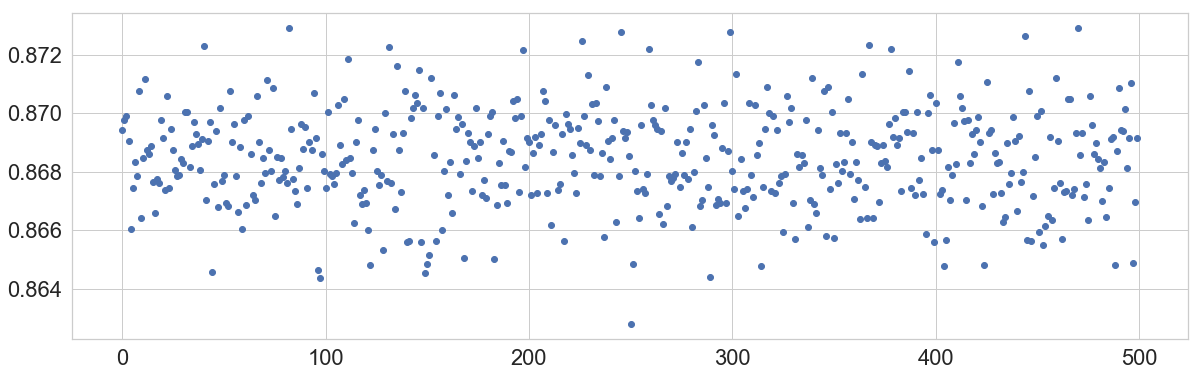

In [209]:
plt.figure(figsize=(20,6))
plt.plot(alls_score, 'o')

In [217]:
use_these = [i for i,val in enumerate(alls_score) if val >= 0.87]1

In [219]:
imp_alls.iloc[:,1+use_these]

TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [227]:
imp_alls.iloc[:,2:].values

array([[nan, nan, 0.08043271281930495, ..., nan, nan, nan],
       [nan, nan, 0.07513451857983126, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=object)

In [233]:
# for i, col in enumerate(imp_alls.iloc[:,2:].values.T):
#     if i in use_these:
#         print(col*100)

In [236]:
define_cols = ['feature', 'zeros']+["itr_"+str(i) for i in range(500)]
imp_alls.columns = define_cols

imp_alls.columns

Index(['feature', 'zeros', 'itr_0', 'itr_1', 'itr_2', 'itr_3', 'itr_4',
       'itr_5', 'itr_6', 'itr_7',
       ...
       'itr_490', 'itr_491', 'itr_492', 'itr_493', 'itr_494', 'itr_495',
       'itr_496', 'itr_497', 'itr_498', 'itr_499'],
      dtype='object', length=502)

In [237]:
imp_alls.drop('zeros', axis=1, inplace=True)

In [243]:
for col, score in zip(list(imp_alls.columns[1:]), alls_score):
    imp_alls[col] = imp_alls[col]*score

In [252]:
good_imp = pd.DataFrame()
good_imp['feature'] = imp_alls['feature']
for col, score in zip(list(imp_alls.columns[1:]), alls_score):
    if score >= 0.87:
        good_imp[col] = imp_alls[col]
#     imp_alls[col] = imp_alls[col]*score
    
    

In [269]:
good_imp.shape, imp_alls.shape

((1000, 89), (1000, 501))

In [275]:
# good_imp.drop('feature', axis=1).astype('float').apply(lambda x: np.nanmean(x), axis=1).sort_values()
# good_imp.apply(np.nanmean)
# good_imp

In [276]:
# imp_alls.drop('feature', axis=1).astype('float').apply(lambda x: np.nanmean(x), axis=1).sort_values()


In [278]:
gc.collect()

1404

In [288]:
count = 0
num_cat_feat = pd.DataFrame()
for i, col1 in enumerate(inter_cols):
    for j, col2 in enumerate(cat_cols):
#         if count == 1000: break
        try:
            col_name = col1+"_/_"+col2
            num_cat_feat[col_name] = train[col1]/(1+train[col2])
            count += 1
        except:
            pass


add_feat_save = num_cat_feat.columns
gc.collect()

546

In [290]:
# num_cat_feat.head(50)
gc.collect()

imp_alls = pd.DataFrame(data=list(num_cat_feat.columns), columns=['feature'])
imp_alls['imp'] = 0
num_cat_feat = reduce_mem_usage_without_print(num_cat_feat)

Memory 981.69 MB ==>  272.84 MB
Decreased by 72.2%


====== saved feature ========


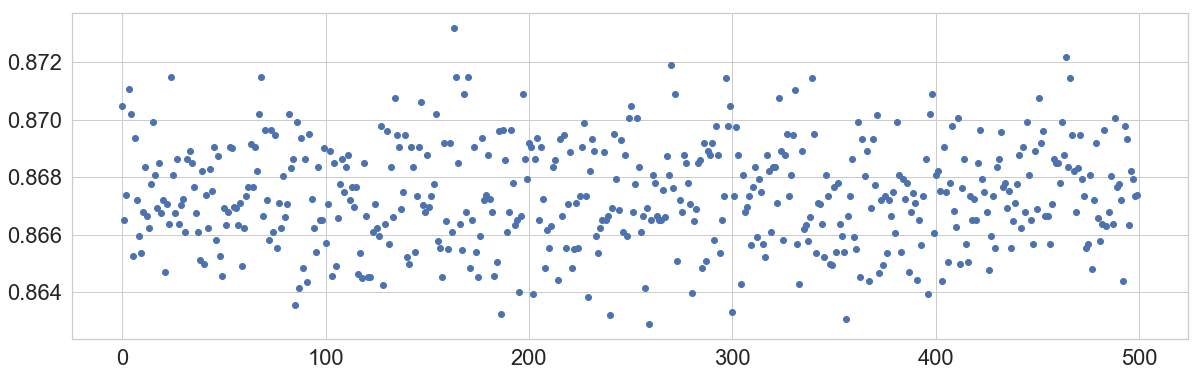

In [291]:
alls_score = []
for i in range(500):
    use_cols = random.sample(list(num_cat_feat.columns),300)
    X_tr, X_ts, y_tr, y_ts = train_test_split(num_cat_feat[use_cols], target, stratify=target, test_size=0.3, random_state=1234)

    cat = train_cat_model(X_tr, y_tr, X_ts, y_ts)
    if cat[0] < 0.868:
        imp_alls = imp_alls.merge(cat[1].tail(30), on='feature', how='left')
    else:
        imp_alls = imp_alls.merge(cat[1].tail(100), on='feature', how='left')
    alls_score.append(cat[0])
    
    gc.collect()


define_cols = ['feature', 'zeros']+["itr_"+str(i) for i in range(500)]
imp_alls.columns = define_cols


imp_alls.to_csv("predictions/num_cat_inter_imp.csv", index=None)
np.save("predictions/num_cat_inter_score.npy", alls_score)
print("====== saved feature ========")


del num_cat_feat, imp_alls
gc.collect()


plt.figure(figsize=(20,6))
plt.plot(alls_score, 'o')

## check and analyze important interaction based feature

In [ ]:
# define_cols = ['feature', 'zeros']+["itr_"+str(i) for i in range(500)]
# imp_alls.columns = define_cols


In [293]:
!ls predictions/*.npy

predictions/add_inter_score.npy      predictions/oof_xgb1.npy
predictions/minus_inter_score.npy    predictions/oof_xgb2.npy
predictions/multi_inter_score.npy    predictions/predi_cat1.npy
predictions/num_cat_inter_score.npy  predictions/predi_cat2.npy
predictions/oof_cat1.npy	     predictions/predi_lgb1.npy
predictions/oof_cat2.npy	     predictions/predi_xgb1.npy
predictions/oof_lgb1.npy	     predictions/predi_xgb2.npy


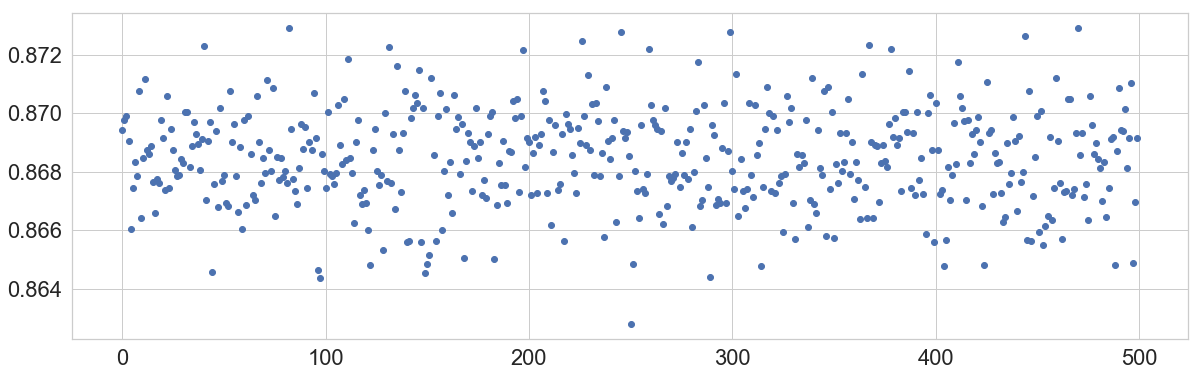

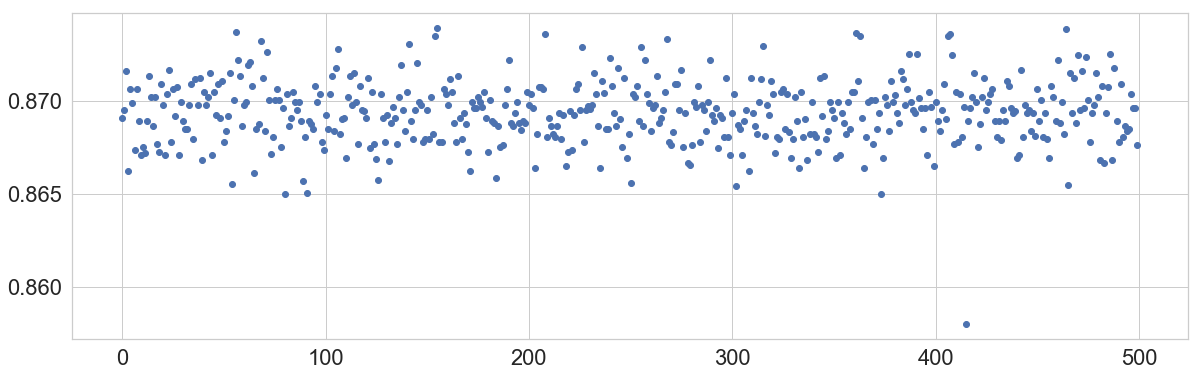

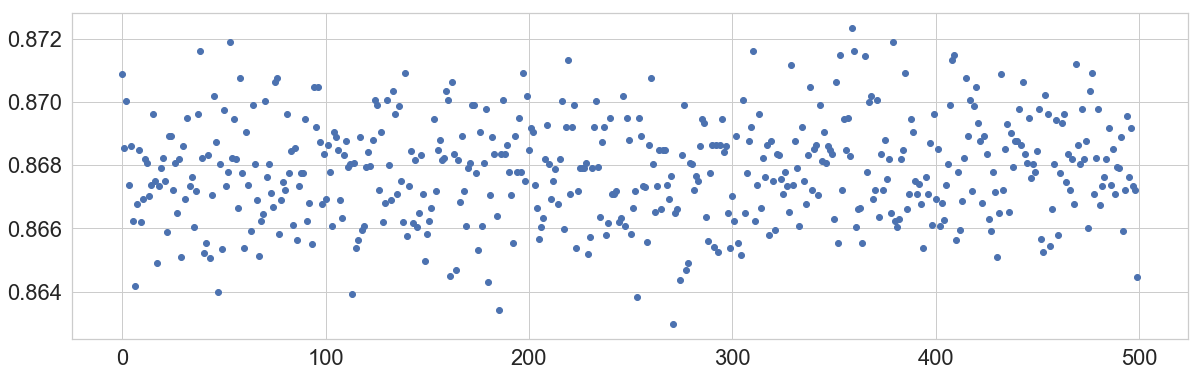

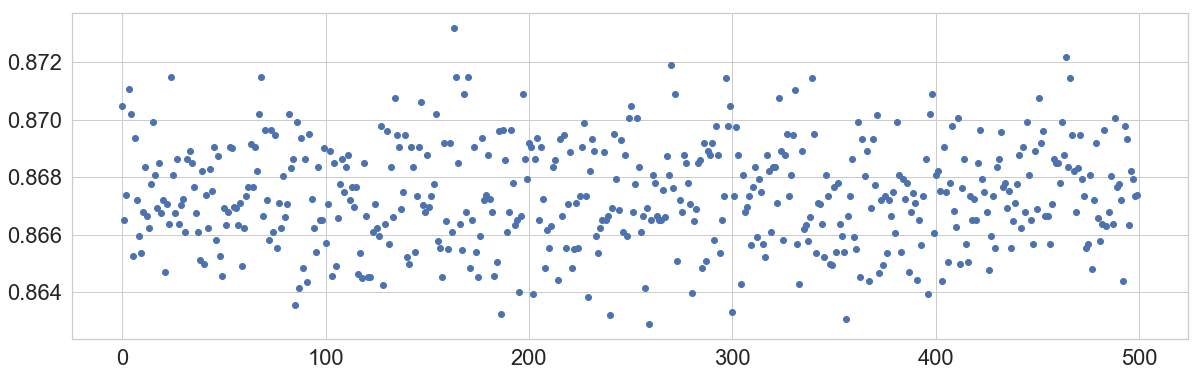

In [294]:
add_score = np.load('predictions/add_inter_score.npy')
min_score = np.load('predictions/minus_inter_score.npy')
mul_score = np.load('predictions/multi_inter_score.npy')
mix_score = np.load('predictions/num_cat_inter_score.npy')

plt.figure(figsize=(20,6))
plt.plot(add_score, 'o')

plt.figure(figsize=(20,6))
plt.plot(min_score, 'o')

plt.figure(figsize=(20,6))
plt.plot(mul_score, 'o')

plt.figure(figsize=(20,6))
plt.plot(mix_score, 'o')
plt.show()

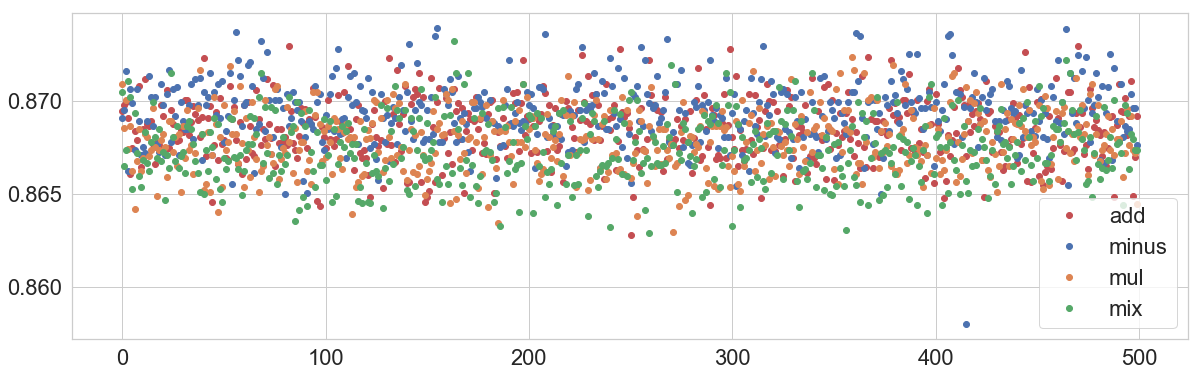

In [309]:
plt.figure(figsize=(20,6))
plt.plot(add_score, 'o', color='r', label="add")
plt.plot(min_score, 'o', label="minus")
plt.plot(mul_score, 'o', label="mul")
plt.plot(mix_score, 'o', color='g', label="mix")
plt.legend()
plt.show()

In [310]:
!ls predictions/

add_inter_imp.csv    minus_inter_imp.csv      predi_cat2.npy
add_inter_score.npy  minus_inter_score.npy    predi_lgb1.npy
cat_ensemble.csv     multi_inter_imp.csv      predi_xgb1.npy
cat_thursday_1.csv   multi_inter_score.npy    predi_xgb2.npy
cat_try_dummy.csv    num_cat_inter_imp.csv    sub_cat1.csv
cat_try_small.csv    num_cat_inter_score.npy  sub_cat_with_tuning.csv
direct_ensemble.csv  oof_cat1.npy	      sub_lgb1.csv
imp_cat1.csv	     oof_cat2.npy	      sub_xgb1.csv
imp_cat2.csv	     oof_lgb1.npy	      xgb4_working.csv
imp_lgb1.csv	     oof_xgb1.npy	      xgb5_working.csv
imp_xgb1.csv	     oof_xgb2.npy	      xgb_try.csv
imp_xgb2.csv	     predi_cat1.npy


In [311]:
add_imp = pd.read_csv('predictions/add_inter_imp.csv')
min_imp = pd.read_csv('predictions/minus_inter_imp.csv')
mul_imp = pd.read_csv('predictions/multi_inter_imp.csv')
mix_imp = pd.read_csv('predictions/num_cat_inter_imp.csv')

define_cols = ['feature', 'zeros']+["itr_"+str(i) for i in range(500)]
add_imp.columns = define_cols
min_imp.columns = define_cols
mul_imp.columns = define_cols
mix_imp.columns = define_cols


In [320]:
all_imps = {
    'add_imp' : add_imp,
    'min_imp' : min_imp,
    'mul_imp' : mul_imp,
    'mix_imp' : mix_imp,
}

all_scores = {
    'add_score' : add_score,
    'min_score' : min_score,
    'mul_score' : mul_score,
    'mix_score' : mix_score,
}

In [ ]:
good_imp = pd.DataFrame()
good_imp['feature'] = imp_alls['feature']
for col, score in zip(list(imp_alls.columns[1:]), alls_score):
    if score >= 0.87:
        good_imp[col] = imp_alls[col]
#     imp_alls[col] = imp_alls[col]*score
    
# good_imp.drop('feature', axis=1).astype('float').apply(lambda x: np.nanmean(x), axis=1).sort_values()


In [342]:

all_imps['min_imp']['mean'] = all_imps['min_imp'].drop('feature', axis=1).astype('float').apply(lambda x: np.nanmean(x), axis=1)#.sort_values()
all_imps['add_imp']['mean'] = all_imps['add_imp'].drop('feature', axis=1).astype('float').apply(lambda x: np.nanmean(x), axis=1)#.sort_values()
all_imps['mul_imp']['mean'] = all_imps['mul_imp'].drop('feature', axis=1).astype('float').apply(lambda x: np.nanmean(x), axis=1)#.sort_values()
all_imps['mix_imp']['mean'] = all_imps['mix_imp'].drop('feature', axis=1).astype('float').apply(lambda x: np.nanmean(x), axis=1)#.sort_values()


In [349]:
# work = all_imps['min_imp']
# work['feature']
work.sort_values(by='mean').tail(500)['feature']

1843     Col636_-_Col18
4595    Col221_-_Col621
5662    Col247_-_Col212
1996    Col683_-_Col933
690     Col889_-_Col257
6982    Col164_-_Col212
6532    Col257_-_Col636
3654     Col780_-_Col25
5998     Col652_-_Col27
4320    Col107_-_Col775
5932    Col179_-_Col900
5574    Col454_-_Col212
778     Col775_-_Col257
175     Col173_-_Col322
2583    Col877_-_Col180
4892    Col589_-_Col221
5850    Col681_-_Col872
6913    Col162_-_Col107
4063     Col25_-_Col725
2326    Col437_-_Col870
1133    Col713_-_Col627
3332     Col10_-_Col614
4875    Col589_-_Col240
5664     Col247_-_Col24
988     Col443_-_Col636
4239    Col393_-_Col725
1992     Col683_-_Col13
126     Col173_-_Col870
2927    Col633_-_Col932
2301     Col437_-_Col11
4934     Col13_-_Col931
6371      Col3_-_Col240
658     Col889_-_Col872
3520      Col873_-_Col9
6899    Col162_-_Col240
388      Col92_-_Col900
3387    Col870_-_Col166
6103      Col7_-_Col180
618      Col889_-_Col22
7162    Col300_-_Col305
1025    Col443_-_Col579
3006     Col305_

In [395]:
# id_name = 'min'# 3000
# id_name = 'add'# 200
# id_name = 'mul'# 2000
id_name = 'mix' # 1500

good_imp = pd.DataFrame()
good_imp['feature'] = all_imps[id_name+'_imp']['feature']
for col, score in zip(list(all_imps[id_name+'_imp'].columns[2:]), all_scores[id_name+'_score']):
    if score >= 0.87:
        good_imp[col] = all_imps[id_name+'_imp'][col]

In [396]:
# idx = good_imp.drop('feature', axis=1).astype('float').apply(lambda x: np.nanmean(x), axis=1).dropna().sort_values().tail(3000).index
# min_cols = good_imp.iloc[idx]['feature'].values

# idx = good_imp.drop('feature', axis=1).astype('float').apply(lambda x: np.nanmean(x), axis=1).dropna().sort_values().tail(2000).index
# mul_cols = good_imp.iloc[idx]['feature'].values

# idx = good_imp.drop('feature', axis=1).astype('float').apply(lambda x: np.nanmean(x), axis=1).dropna().sort_values().tail(1500).index
# mix_cols = good_imp.iloc[idx]['feature'].values

# idx = good_imp.drop('feature', axis=1).astype('float').apply(lambda x: np.nanmean(x), axis=1).dropna().sort_values().tail(200).index
# add_cols = good_imp.iloc[idx]['feature'].values


In [332]:
min_mean = all_imps['min_imp'].drop('feature', axis=1).astype('float').apply(lambda x: np.nanmean(x), axis=1).sort_values()
add_mean = all_imps['add_imp'].drop('feature', axis=1).astype('float').apply(lambda x: np.nanmean(x), axis=1).sort_values()
mul_mean = all_imps['mul_imp'].drop('feature', axis=1).astype('float').apply(lambda x: np.nanmean(x), axis=1).sort_values()
mix_mean = all_imps['mix_imp'].drop('feature', axis=1).astype('float').apply(lambda x: np.nanmean(x), axis=1).sort_values()


In [338]:
min_mean[min_mean != 0].shape, add_mean[add_mean != 0].shape, mul_mean[mul_mean != 0].shape, mix_mean[mix_mean != 0].shape

((7070,), (980,), (7141,), (6454,))

In [420]:
idx = min_mean.tail(1000).index
min_cols_ = all_imps['min_imp'].iloc[idx]['feature'].values
print(len(set(min_cols).union(set(min_cols_))))

idx = mul_mean.tail(1500).index
mul_cols_ = all_imps['mul_imp'].iloc[idx]['feature'].values
print(len(set(mul_cols).union(set(mul_cols_))))

idx = mix_mean.tail(700).index
mix_cols_ = all_imps['mix_imp'].iloc[idx]['feature'].values
print(len(set(mix_cols).union(set(mix_cols_))))

idx = add_mean.tail(200).index
add_cols_ = all_imps['add_imp'].iloc[idx]['feature'].values
print(len(set(add_cols).union(set(add_cols_))))


3201
2842
1894
308


In [421]:
min_cols2 = set(min_cols).union(set(min_cols_))
mul_cols2 = set(mul_cols).union(set(mul_cols_))
mix_cols2 = set(mix_cols).union(set(mix_cols_))
add_cols2 = set(add_cols).union(set(add_cols_))


In [554]:
3201+2842+1894+308
gc.collect()

3317

In [624]:
mul_cols2

{'Col167_Col305',
 'Col454_Col621',
 'Col173_Col633',
 'Col627_Col898',
 'Col107_Col713',
 'Col257_Col681',
 'Col163_Col25',
 'Col167_Col603',
 'Col871_Col25',
 'Col633_Col10',
 'Col900_Col180',
 'Col601_Col26',
 'Col912_Col586',
 'Col780_Col18',
 'Col393_Col874',
 'Col931_Col24',
 'Col167_Col27',
 'Col444_Col912',
 'Col725_Col18',
 'Col7_Col10',
 'Col3_Col175',
 'Col170_Col876',
 'Col912_Col247',
 'Col18_Col780',
 'Col393_Col443',
 'Col931_Col22',
 'Col167_Col107',
 'Col444_Col871',
 'Col601_Col162',
 'Col163_Col652',
 'Col652_Col383',
 'Col627_Col221',
 'Col243_Col871',
 'Col780_Col875',
 'Col175_Col719',
 'Col932_Col652',
 'Col22_Col164',
 'Col193_Col614',
 'Col603_Col601',
 'Col681_Col186',
 'Col300_Col652',
 'Col7_Col780',
 'Col179_Col700',
 'Col390_Col437',
 'Col444_Col680',
 'Col872_Col10',
 'Col243_Col180',
 'Col18_Col454',
 'Col627_Col186',
 'Col933_Col601',
 'Col10_Col598',
 'Col221_Col603',
 'Col243_Col305',
 'Col444_Col164',
 'Col933_Col652',
 'Col444_Col621',
 'Col92_Col93

In [682]:

count = 0
feat = pd.DataFrame()
for col in add_cols2:
    c = col.split('_')
    col1, op, col2 = c[0], c[1], c[2]
#     print(col1, col2, op)
    try:
#         col_name = col1+"_/_"+col2
        feat[col] = train[col1]+(train[col2])
        count += 1
    except:
        pass

print(count)
# add_feat_save = num_cat_feat.columns
gc.collect()

308


374

In [683]:
feat.shape

(16427, 308)

In [681]:
df4 = feat[list(cat1[1].head(200)['feature'].values)]
df4.shape

(16427, 200)

In [684]:
X_tr, X_ts, y_tr, y_ts = train_test_split(feat, target, stratify=target, test_size=0.3, random_state=1234)
cat1 = train_cat_model(X_tr, y_tr, X_ts, y_ts)
cat1

(0.8678821766114321,              feature         imp
 230   Col26_+_Col636     2.31802
 239  Col931_+_Col912       2.254
 127  Col881_+_Col877     1.36396
 133    Col9_+_Col633     1.23009
 280  Col167_+_Col636     1.15879
 25   Col193_+_Col166     1.12047
 93   Col931_+_Col106     1.08575
 84   Col931_+_Col166     1.04455
 53   Col931_+_Col305     1.00433
 206  Col193_+_Col603    0.990066
 131    Col26_+_Col27    0.966693
 56   Col775_+_Col300    0.965896
 226   Col26_+_Col875    0.949195
 41    Col92_+_Col614    0.897427
 33    Col22_+_Col193    0.892383
 198     Col26_+_Col7     0.88389
 120   Col92_+_Col636     0.88168
 254  Col193_+_Col627    0.877609
 94    Col931_+_Col27     0.87151
 159  Col193_+_Col454    0.866269
 268  Col931_+_Col898    0.850721
 201  Col775_+_Col912    0.837118
 10    Col26_+_Col106    0.836894
 49   Col881_+_Col454    0.836634
 212    Col9_+_Col912    0.820856
 259  Col931_+_Col933    0.787809
 30    Col22_+_Col875     0.76904
 134  Col193_+_Col243    0.7

In [685]:
X_tr, X_ts, y_tr, y_ts = train_test_split(feat, target, stratify=target, test_size=0.3, random_state=1234)
xgb1 = train_xgb_model(X_tr, y_tr, X_ts, y_ts, depth=3)
xgb1

[0]	valid-auc:0.624537
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[105]	valid-auc:0.735426



(0.8619785846479822,              feature   imp
 0    Col193_+_Col627  15.0
 66   Col881_+_Col877  15.0
 4    Col931_+_Col106  11.0
 61   Col931_+_Col719  11.0
 29   Col173_+_Col874  10.0
 52    Col775_+_Col18  10.0
 117   Col22_+_Col621  10.0
 62   Col173_+_Col300  10.0
 64    Col173_+_Col13  10.0
 69   Col775_+_Col875  10.0
 27    Col26_+_Col106  10.0
 7     Col26_+_Col636  10.0
 68   Col167_+_Col931   9.0
 77   Col193_+_Col440   9.0
 43    Col26_+_Col933   9.0
 15   Col167_+_Col170   9.0
 139   Col26_+_Col875   9.0
 111  Col167_+_Col603   9.0
 71   Col193_+_Col454   8.0
 94     Col9_+_Col912   8.0
 23   Col775_+_Col725   8.0
 28   Col775_+_Col683   8.0
 184   Col881_+_Col18   8.0
 3    Col889_+_Col107   8.0
 6    Col193_+_Col603   8.0
 91   Col931_+_Col912   7.0
 8     Col26_+_Col649   7.0
 59   Col443_+_Col649   7.0
 109  Col881_+_Col257   7.0
 67   Col167_+_Col680   6.0
 110   Col22_+_Col652   6.0
 121  Col193_+_Col874   6.0
 132   Col92_+_Col300   6.0
 63   Col881_+_Col322   6.0


In [687]:
for i in range(10):
    gc.collect()

In [679]:
X_tr, X_ts, y_tr, y_ts = train_test_split(feat[list(cat1[1].head(200)['feature'].values)], target, stratify=target, test_size=0.3, random_state=1234)
cat11 = train_cat_model(X_tr, y_tr, X_ts, y_ts)
cat11

(0.8693489101158103,            feature        imp
 35   Col175_Col876    1.89564
 0    Col881_Col875    1.73927
 26   Col164_Col257    1.42005
 128  Col876_Col649     1.3521
 100   Col933_Col26    1.26312
 27     Col681_Col3    1.25915
 66   Col221_Col931       1.25
 58   Col454_Col932    1.21424
 38   Col175_Col246    1.20736
 80   Col212_Col440    1.15131
 40    Col24_Col876    1.14868
 79   Col440_Col257    1.07206
 59   Col873_Col243    1.06668
 50   Col179_Col586     0.9706
 142   Col26_Col177   0.967291
 157  Col870_Col649   0.955116
 2      Col933_Col7   0.912152
 92   Col243_Col322   0.903364
 51   Col179_Col649   0.888383
 57   Col440_Col683    0.88825
 87   Col440_Col177    0.87406
 7    Col390_Col440   0.854532
 16   Col305_Col162   0.847993
 10     Col3_Col300   0.797958
 127  Col231_Col586   0.787422
 123  Col166_Col579   0.781146
 196  Col443_Col872   0.773135
 6    Col231_Col440    0.76159
 23   Col240_Col598    0.75999
 37     Col25_Col26   0.758962
 182  Col166_Col680

In [573]:
X_tr, X_ts, y_tr, y_ts = train_test_split(feat[list(cat1[1].head(200)['feature'].values)], target, stratify=target, test_size=0.3, random_state=1234)
cat111 = train_cat_model(X_tr, y_tr, X_ts, y_ts)
cat111

(0.8707696309716709,              feature        imp
 72   Col912_-_Col322    2.54358
 56   Col775_-_Col636    1.85272
 155    Col24_-_Col18    1.69389
 20   Col167_-_Col875    1.46961
 10   Col454_-_Col636    1.46477
 53     Col3_-_Col870    1.40844
 142  Col713_-_Col725    1.30569
 68      Col22_-_Col3    1.29918
 35   Col725_-_Col876    1.27721
 73   Col247_-_Col683    1.24517
 130   Col26_-_Col872     1.2382
 88   Col649_-_Col652    1.23118
 3     Col25_-_Col322    1.20748
 150  Col454_-_Col627     1.1546
 103  Col898_-_Col163    1.12884
 175   Col26_-_Col243    1.12751
 154  Col186_-_Col931      1.118
 0    Col889_-_Col649    1.11366
 23   Col497_-_Col162    1.08004
 167  Col683_-_Col193    0.99434
 19   Col177_-_Col180   0.986049
 108  Col586_-_Col173   0.940805
 126  Col443_-_Col875   0.935394
 147  Col167_-_Col175   0.930021
 25   Col652_-_Col780   0.922295
 181  Col931_-_Col247   0.888553
 98   Col933_-_Col876   0.885493
 174    Col24_-_Col13   0.866789
 38   Col898_-_Col173  

In [688]:
df2.shape, df3.shape, df4.shape, feat.shape

((16427, 768), (16427, 88), (16427, 200), (16427, 308))

In [702]:
X_tr, X_ts, y_tr, y_ts = train_test_split(pd.concat([feat, df2, df3, df4], axis=1)[list(cat22[1].head(200)['feature'].values)], 
                                          target, stratify=target, test_size=0.3, random_state=1234)
cat22 = train_cat_model(X_tr, y_tr, X_ts, y_ts)
cat22 #8699

(0.8673699252569329,               feature        imp
 0              Col177    2.18477
 36   Col186_/_Col1738    1.95942
 30     Col683_-_Col13    1.60012
 8       Col437_Col681    1.39209
 13               Col3    1.36962
 59    Col931_/_Col913    1.30194
 19             Col257    1.29473
 26        Col167_Col3    1.20407
 46    Col931_/_Col133    1.19402
 4              Col175    1.15833
 44             Col636    1.14792
 10      Col881_Col875    1.14419
 150   Col680_/_Col140    1.11323
 57    Col877_/_Col909    1.11119
 104       Col25_Col26    1.05862
 100   Col193_+_Col246    1.02973
 47    Col443_-_Col875    1.02823
 1    Col621_/_Col1902    1.01649
 101   Col167_+_Col636    1.00237
 32             Col364   0.996913
 51       Col26_Col633   0.976616
 27      Col179_Col586    0.96739
 6              Col161   0.961919
 168    Col92_+_Col497   0.929945
 140      Col22_Col240   0.928618
 138    Col713_-_Col18   0.894777
 3     Col877_/_Col111   0.893548
 75   Col932_/_Col1301   0.8

In [697]:
for i in range(20):
    gc.collect()

In [703]:
list(cat22[1].head(200)['feature'].values)

['Col177',
 'Col186_/_Col1738',
 'Col683_-_Col13',
 'Col437_Col681',
 'Col3',
 'Col931_/_Col913',
 'Col257',
 'Col167_Col3',
 'Col931_/_Col133',
 'Col175',
 'Col636',
 'Col881_Col875',
 'Col680_/_Col140',
 'Col877_/_Col909',
 'Col25_Col26',
 'Col193_+_Col246',
 'Col443_-_Col875',
 'Col621_/_Col1902',
 'Col167_+_Col636',
 'Col364',
 'Col26_Col633',
 'Col179_Col586',
 'Col161',
 'Col92_+_Col497',
 'Col22_Col240',
 'Col713_-_Col18',
 'Col877_/_Col111',
 'Col932_/_Col1301',
 'Col875',
 'Col322',
 'Col163_/_Col37',
 'Col621_/_Col111',
 'Col9_+_Col912',
 'Col189',
 'Col713_-_Col725',
 'Col13_-_Col912',
 'Col417',
 'Col18_/_Col1166',
 'Col719_/_Col867',
 'Col167_+_Col603',
 'Col180_/_Col37',
 'Col881_+_Col877',
 'Col614_-_Col106',
 'Col603_Col92',
 'Col876_-_Col11',
 'Col859',
 'Col725_-_Col876',
 'Col734',
 'Col25_-_Col322',
 'Col106_/_Col964',
 'Col173_+_Col221',
 'Col407',
 'Col164_-_Col873',
 'Col3_Col300',
 'Col873_-_Col497',
 'Col233',
 'Col664',
 'Col775_+_Col390',
 'Col576',
 'Col873_

In [695]:
X_tr, X_ts, y_tr, y_ts = train_test_split(pd.concat([feat, df2, df3, df4], axis=1)[list(xgb2[1].head(200)['feature'].values)], 
                                          target, stratify=target, test_size=0.3, random_state=1234)
xgb22 = train_xgb_model(X_tr, y_tr, X_ts, y_ts)
xgb22 #8682

[0]	valid-auc:0.629327
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[105]	valid-auc:0.738939



(0.8642185969964401,               feature   imp
 37             Col177  24.0
 7     Col186_/_Col138  23.0
 9     Col713_-_Col725  23.0
 18    Col933_-_Col876  20.0
 1      Col18_-_Col877  19.0
 43    Col621_/_Col111  19.0
 26      Col912_Col437  18.0
 12    Col889_-_Col175  18.0
 118   Col173_+_Col300  18.0
 51             Col802  17.0
 48   Col652_/_Col1914  17.0
 128   Col107_/_Col909  16.0
 110   Col18_/_Col1664  16.0
 116  Col177_/_Col1118  16.0
 0     Col193_+_Col627  16.0
 5    Col633_/_Col1830  16.0
 8       Col437_Col681  16.0
 62    Col680_/_Col140  15.0
 147   Col877_/_Col111  15.0
 4      Col22_+_Col700  15.0
 21    Col586_-_Col614  15.0
 67      Col881_Col193  15.0
 73    Col167_+_Col931  14.0
 68      Col179_Col586  14.0
 96     Col497_/_Col75  14.0
 85      Col305_Col162  14.0
 25    Col649_/_Col883  14.0
 83      Col175_Col246  14.0
 173   Col881_+_Col257  14.0
 45      Col875_Col231  14.0
 150            Col706  14.0
 61             Col914  13.0
 75   Col876_/_Col1212 

In [698]:
list(xgb2[1].head(200)['feature'].values)

['Col177',
 'Col633_/_Col1830',
 'Col933_-_Col876',
 'Col802',
 'Col18_-_Col877',
 'Col186_/_Col138',
 'Col24_Col876',
 'Col173_+_Col300',
 'Col874_Col912',
 'Col193_+_Col627',
 'Col700_Col681',
 'Col175_Col876',
 'Col636',
 'Col497_-_Col162',
 'Col621_/_Col111',
 'Col138',
 'Col725_/_Col126',
 'Col22_/_Col89',
 'Col931_+_Col25',
 'Col870_Col166',
 'Col877_/_Col111',
 'Col586_/_Col111',
 'Col652_Col383',
 'Col22_+_Col167',
 'Col881_/_Col2002',
 'Col873_Col25',
 'Col477',
 'Col713_-_Col725',
 'Col193_+_Col454',
 'Col871_/_Col111',
 'Col775_+_Col875',
 'Col874_/_Col909',
 'Col18_/_Col1664',
 'Col173_-_Col257',
 'Col889_+_Col780',
 'Col18_/_Col1914',
 'Col932_Col586',
 'Col177_/_Col1118',
 'Col586_Col212',
 'Col881_+_Col179',
 'Col443_-_Col875',
 'Col10_Col163',
 'Col26_+_Col877',
 'Col167_+_Col700',
 'Col180_/_Col909',
 'Col881_Col193',
 'Col13_/_Col126',
 'Col636_Col24',
 'Col889_-_Col175',
 'Col680_Col912',
 'Col179_Col586',
 'Col438',
 'Col734',
 'Col877_/_Col909',
 'Col180_Col872',
 

In [602]:
# pd.concat([feat[list(cat[1].head(300)['feature'].values)], train], axis=1).shape

X_tr, X_ts, y_tr, y_ts = train_test_split(pd.concat([feat[list(cat111[1].head(200)['feature'].values)], df2], axis=1)[list(cat2[1].head(300)['feature'].values)], 
                                          target, stratify=target, test_size=0.3, random_state=1234)
cat22 = train_cat_model(X_tr, y_tr, X_ts, y_ts)
cat22 #8682

(0.8641342109435028,               feature         imp
 101     Col601_-_Col3      3.4456
 0              Col177     3.14208
 2               Col13     2.20298
 108   Col912_/_Col127     1.90282
 82   Col621_/_Col1902     1.85159
 23             Col161      1.8446
 136   Col877_/_Col111     1.69168
 55             Col875     1.57264
 81    Col636_-_Col872     1.44605
 153            Col399     1.41529
 116   Col454_-_Col636     1.39583
 11      Col3_-_Col932     1.37199
 27             Col636     1.24142
 20     Col25_-_Col322     1.22091
 5              Col302     1.17593
 49    Col636_-_Col871     1.17119
 140   Col780_-_Col614      1.0874
 169  Col243_/_Col1775     1.04211
 13     Col13_-_Col912     1.03066
 63    Col933_-_Col186     1.01131
 88   Col933_/_Col1910    0.995569
 89    Col440_-_Col872    0.978368
 132    Col875_/_Col99    0.973254
 142    Col26_-_Col872    0.938853
 43             Col135    0.935174
 96   Col627_/_Col1830     0.92963
 37    Col931_-_Col889    0.926398


In [675]:
X_tr, X_ts, y_tr, y_ts = train_test_split(pd.concat([feat[list(cat1[1].head(100)['feature'].values)], df2], axis=1)[list(set(xgb222[1].head(200)['feature'].values).intersection(list(min_cols2)+list(mix_cols2)))], 
                                          target, stratify=target, test_size=0.3, random_state=1234)
xgb222 = train_xgb_model(X_tr, y_tr, X_ts, y_ts, depth=4)
xgb222 #8638

[0]	valid-auc:0.661448
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[165]	valid-auc:0.739787



(0.864431126383558,              feature   imp
 30  Col876_/_Col1212  49.0
 7   Col322_/_Col1738  45.0
 48    Col173_/_Col67  45.0
 35    Col871_/_Col89  43.0
 19    Col26_/_Col913  41.0
 1     Col18_/_Col127  40.0
 0   Col636_/_Col1805  37.0
 13     Col9_/_Col982  37.0
 25   Col107_/_Col922  36.0
 77   Col874_/_Col133  36.0
 8     Col167_/_Col35  35.0
 66   Col872_/_Col977  34.0
 46  Col872_/_Col1220  34.0
 18   Col18_/_Col1166  33.0
 22  Col164_/_Col1220  33.0
 20   Col713_/_Col909  33.0
 80   Col931_/_Col913  33.0
 34   Col875_/_Col139  33.0
 72   Col92_/_Col1036  33.0
 55   Col177_/_Col977  33.0
 10  Col437_/_Col1914  33.0
 57  Col881_/_Col1301  32.0
 54    Col874_/_Col96  32.0
 37  Col240_/_Col2228  32.0
 36   Col180_/_Col909  32.0
 94    Col454_/_Col94  32.0
 39   Col871_/_Col111  32.0
 97  Col877_/_Col1668  32.0
 11  Col633_/_Col1830  32.0
 15   Col877_/_Col111  32.0
 49   Col680_/_Col140  31.0
 82   Col614_/_Col943  31.0
 58   Col164_/_Col118  31.0
 85     Col25_/_Col98  30.0
 

In [707]:
# means = feat.mean()
# X_tr, X_ts, y_tr, y_ts = train_test_split(feat.fillna(means),#df2[list(xgb3[1].sort_values(by='imp', ascending=False).head(100)['feature'].values)].fillna(means_), 
#                                           target, stratify=target, test_size=0.3, random_state=1234)

params = {}
for alpha in [1, 10, 100]:
    params['alpha'] = alpha
    clf = LogisticRegression(
            penalty='l2', dual=False, C=params['alpha'], fit_intercept=True, 
            intercept_scaling=1, class_weight='balanced', random_state=1245434, 
            max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

    clf.fit(X_tr, y_tr)
#     clf.score(X_ts, y_ts)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.94      0.56      0.70      4438
           1       0.14      0.67      0.24       491

   micro avg       0.57      0.57      0.57      4929
   macro avg       0.54      0.61      0.47      4929
weighted avg       0.86      0.57      0.65      4929

              precision    recall  f1-score   support

           0       0.94      0.55      0.69      4438
           1       0.14      0.67      0.23       491

   micro avg       0.56      0.56      0.56      4929
   macro avg       0.54      0.61      0.46      4929
weighted avg       0.86      0.56      0.65      4929

              precision    recall  f1-score   support

           0       0.94      0.56      0.70      4438
           1       0.14      0.67      0.24       491

   micro avg       0.57      0.57      0.57      4929
   macro avg       0.54      0.61      0.47      4929
weighted avg       0.86      0.57      0.65      4929



In [706]:
import warnings
warnings.filterwarnings("ignore")

data = pd.concat([feat, df2, df3, df4], axis=1)[list(cat2[1].head(200)['feature'].values)]
means = data.mean()
X_tr, X_ts, y_tr, y_ts = train_test_split(data.fillna(means), 
                                          target, stratify=target, test_size=0.3, random_state=1234)
# means = df2.mean()
# X_tr, X_ts, y_tr, y_ts = train_test_split(df2.fillna(means), target, stratify=target, test_size=0.3, random_state=1234)

params = {}
for alpha in [0.001, 1, 1000]:
    params['alpha'] = alpha
    clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
            early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='squared_hinge',
            class_weight='balanced', average=False, n_iter=100)
    print("="*50)
    clf.fit(X_tr, y_tr)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4438
           1       0.18      0.21      0.19       491

   micro avg       0.82      0.82      0.82      4929
   macro avg       0.54      0.55      0.55      4929
weighted avg       0.84      0.82      0.83      4929

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4438
           1       0.18      0.21      0.19       491

   micro avg       0.82      0.82      0.82      4929
   macro avg       0.54      0.55      0.55      4929
weighted avg       0.84      0.82      0.83      4929

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4438
           1       0.18      0.21      0.19       491

   micro avg       0.82      0.82      0.82      4929
   macro avg       0.54      0.55      0.55      4929
weighted avg       0.84      0.82      0.83      4929



In [642]:
import warnings
warnings.filterwarnings("ignore")

means = df3.mean()
X_tr, X_ts, y_tr, y_ts = train_test_split(df3.fillna(means), target, stratify=target, test_size=0.3, random_state=1234)

params = {}
for alpha in [0.001, 1, 1000]:
    params['alpha'] = alpha
    clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
            early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='squared_hinge',
            class_weight='balanced', average=False, n_iter=100)
    print("="*50)
    clf.fit(X_tr, y_tr)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      4438
           1       0.12      0.11      0.11       491

   micro avg       0.83      0.83      0.83      4929
   macro avg       0.51      0.51      0.51      4929
weighted avg       0.82      0.83      0.83      4929

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      4438
           1       0.12      0.11      0.11       491

   micro avg       0.83      0.83      0.83      4929
   macro avg       0.51      0.51      0.51      4929
weighted avg       0.82      0.83      0.83      4929

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      4438
           1       0.12      0.11      0.11       491

   micro avg       0.83      0.83      0.83      4929
   macro avg       0.51      0.51      0.51      4929
weighted avg       0.82      0.83      0.83      4929



In [450]:
def reduce_mem_usage_without_print(data, return_flag=True):
    """ Return a modified copy of dataframe. It will print the entire history of the all variable.
    Args:
        return_flag: whether to return the modified data
    """
    df = data.copy()
    print("="*30)
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory {:.2f} MB'.format(start_mem), "==>", end=" ")
    
    for i, col in enumerate(df.columns):
        col_type = df[col].dtypes
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else: df[col] = df[col].astype('category')
        print(i, end=" ")
        
    end_mem = df.memory_usage().sum() / 1024**2
    print(' {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    print("="*30)
    if return_flag:
        return df
 

In [454]:
df2 = pd.concat([feat[list(cat[1].head(300)['feature'].values)], train], axis=1)
df2 = reduce_mem_usage_without_print(df2)


Memory 96.38 MB ==> 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623

In [501]:
def train_xgb_model(X_train, y_train, X_valid, y_valid, depth=4):
    
    param = {
        'eval_metric'     : 'auc',
        'seed'            : 1337,
        'eta'             : 0.05,
        'subsample'       : 0.7,
        'colsample_bytree': 0.5,
        'silent'          : 1,
        'nthread'         : 4,
        'Scale_pos_weight': 100,#3.607,
        'objective'       : 'binary:logistic',
        'max_depth'       : depth,
        'alpha'           : 0.09
    }
    features = X_train.columns
    
    _train = xgb.DMatrix(X_train[features], label=y_train, feature_names=list(features))
    _valid = xgb.DMatrix(X_valid[features], label=y_valid,feature_names=list(features))
    
    watchlist = [(_valid, 'valid')]
    clf = xgb.train(dtrain=_train, 
                    num_boost_round=10000, 
                    evals=watchlist,
                    early_stopping_rounds=25, 
                    verbose_eval=200, 
                    params=param)
    
    valid_frame = xgb.DMatrix(X_valid[features],feature_names=list(features))
    oof  = clf.predict(valid_frame, ntree_limit=clf.best_ntree_limit)
    
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
    score = f1_score(y_valid, y_bin, average='weighted')
    
    xgb_imp = pd.DataFrame(data=[list(clf.get_fscore().keys()), 
                                 list(clf.get_fscore().values())]).T
    xgb_imp.columns = ['feature','imp']
    xgb_imp.imp = xgb_imp.imp.astype('float')
    xgb_imp = xgb_imp.sort_values(by='imp',ascending=False)

    return score, xgb_imp


In [465]:
# X_tr, X_ts, y_tr, y_ts = train_test_split(pd.concat([feat[list(cat[1].head(300)['feature'].values)], train], axis=1), 
# target, stratify=target, test_size=0.3, random_state=1234)
X_tr, X_ts, y_tr, y_ts = train_test_split(train, target, stratify=target, test_size=0.3, random_state=1234)
xgb1 = train_xgb_model(X_tr, y_tr, X_ts, y_ts)


[0]	valid-auc:0.663301
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[171]	valid-auc:0.744824



In [466]:
xgb1

(0.8621072767914099,      feature   imp
 0     Col636  27.0
 1     Col177  37.0
 2     Col586  11.0
 3     Col649   7.0
 4     Col158   4.0
 5    Col2228   2.0
 6     Col283   9.0
 7     Col875  24.0
 8      Col41   6.0
 9     Col816  11.0
 10    Col780   8.0
 11    Col149  11.0
 12    Col706  19.0
 13    Col107  13.0
 14    Col133   1.0
 15    Col155   8.0
 16    Col600   4.0
 17    Col652   9.0
 18    Col186   6.0
 19    Col437   5.0
 20    Col633  16.0
 21    Col595   3.0
 22     Col18  26.0
 23    Col876  22.0
 24    Col672   4.0
 25     Col22   6.0
 26    Col440  12.0
 27    Col383   6.0
 28    Col647   4.0
 29    Col874  31.0
 30    Col430   7.0
 31    Col160   6.0
 32    Col438   3.0
 33    Col679   8.0
 34    Col516   6.0
 35    Col627  13.0
 36     Col65   2.0
 37    Col790   8.0
 38     Col13  12.0
 39    Col305   7.0
 40    Col750  10.0
 41    Col719   8.0
 42    Col839   8.0
 43    Col612   8.0
 44    Col933  20.0
 45    Col795  10.0
 46    Col175  15.0
 47    Col589   5.0


In [524]:
X_tr, X_ts, y_tr, y_ts = train_test_split(df2, target, stratify=target, test_size=0.3, random_state=1234)
xgb2 = train_xgb_model(X_tr, y_tr, X_ts, y_ts, depth=4)

xgb2

[0]	valid-auc:0.664348
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.741929
Stopping. Best iteration:
[199]	valid-auc:0.742076



(0.8615490066569622,               feature   imp
 5              Col177  24.0
 111            Col875  22.0
 235            Col888  16.0
 25             Col874  16.0
 46   Col186_/_Col1738  15.0
 149            Col106  14.0
 121            Col781  13.0
 39    Col877_/_Col160  13.0
 340   Col780_/_Col907  13.0
 210   Col877_/_Col111  13.0
 347            Col605  13.0
 26   Col876_/_Col1212  13.0
 0              Col636  13.0
 107   Col107_/_Col922  12.0
 344      Col9_/_Col98  12.0
 97    Col164_/_Col118  12.0
 190            Col476  12.0
 9     Col163_/_Col161  12.0
 225   Col443_/_Col118  12.0
 57    Col231_/_Col909  12.0
 214   Col589_/_Col103  12.0
 388  Col877_/_Col1668  12.0
 116   Col877_/_Col909  12.0
 15    Col621_/_Col111  12.0
 101            Col706  11.0
 247    Col18_/_Col127  11.0
 286     Col24_/_Col96  11.0
 216   Col24_/_Col2002  11.0
 281    Col871_/_Col89  11.0
 421  Col875_/_Col1668  11.0
 368    Col881_/_Col95  11.0
 198             Col18  11.0
 114   Col322_/_Col865 

In [528]:
X_tr, X_ts, y_tr, y_ts = train_test_split(df2[list(xgb2[1].sort_values(by='imp', ascending=False).head(200)['feature'].values)], 
                                          target, stratify=target, test_size=0.3, random_state=1234)
xgb22 = train_xgb_model(X_tr, y_tr, X_ts, y_ts, depth=3)
xgb22

[0]	valid-auc:0.658062
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.740422
Stopping. Best iteration:
[190]	valid-auc:0.741136



(0.8642670386733627,               feature   imp
 18             Col177  25.0
 17             Col636  20.0
 0    Col633_/_Col1830  19.0
 41   Col186_/_Col2228  18.0
 27    Col877_/_Col160  17.0
 13    Col873_/_Col577  16.0
 25    Col231_/_Col909  16.0
 82     Col26_/_Col913  16.0
 60   Col713_/_Col1672  15.0
 57   Col876_/_Col1212  15.0
 55    Col163_/_Col161  15.0
 15    Col186_/_Col138  15.0
 30    Col877_/_Col111  15.0
 74    Col180_/_Col909  15.0
 24    Col18_/_Col1664  14.0
 12    Col589_/_Col103  14.0
 94             Col257  14.0
 29             Col795  14.0
 135   Col24_/_Col2002  14.0
 61     Col871_/_Col89  13.0
 64             Col875  13.0
 90    Col300_/_Col913  13.0
 79    Col780_/_Col907  13.0
 2     Col877_/_Col909  13.0
 4     Col680_/_Col140  13.0
 10             Col874  13.0
 8    Col322_/_Col1738  13.0
 40     Col18_/_Col127  12.0
 53             Col407  12.0
 11   Col652_/_Col1914  12.0
 45   Col725_/_Col1830  12.0
 87             Col877  12.0
 33    Col586_/_Col111 

In [542]:
X_tr, X_ts, y_tr, y_ts = train_test_split(feat[list(xgb222[1].sort_values(by='imp', ascending=False).head(150)['feature'].values)], 
                                          target, stratify=target, test_size=0.3, random_state=1234)
xgb222 = train_xgb_model(X_tr, y_tr, X_ts, y_ts, depth=3)
xgb222#.863780281752967

[0]	valid-auc:0.657598
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[153]	valid-auc:0.739117



(0.8645840331717577,              feature   imp
 8    Col877_/_Col111  23.0
 3     Col18_/_Col127  23.0
 68  Col177_/_Col1301  21.0
 80    Col775_/_Col70  20.0
 65  Col257_/_Col1301  20.0
 76    Col719_/_Col97  19.0
 69  Col872_/_Col1914  19.0
 23  Col636_/_Col1805  19.0
 13    Col725_/_Col99  19.0
 55   Col437_/_Col907  19.0
 1   Col390_/_Col1738  19.0
 5    Col875_/_Col135  18.0
 6     Col10_/_Col103  18.0
 47   Col589_/_Col915  18.0
 46  Col177_/_Col1118  18.0
 38  Col876_/_Col1212  17.0
 44  Col713_/_Col1977  17.0
 31   Col440_/_Col909  17.0
 26   Col933_/_Col913  16.0
 7    Col162_/_Col161  16.0
 2    Col18_/_Col1664  16.0
 0   Col633_/_Col1830  16.0
 59   Col177_/_Col977  15.0
 35  Col240_/_Col2228  15.0
 33   Col881_/_Col913  15.0
 83  Col212_/_Col1061  15.0
 15   Col636_/_Col867  15.0
 9   Col762_/_Col1914  15.0
 18    Col106_/_Col99  15.0
 41  Col175_/_Col1910  14.0
 75   Col443_/_Col907  14.0
 70   Col889_/_Col862  14.0
 19   Col725_/_Col101  14.0
 58   Col173_/_Col867  13.0


In [536]:
xgb222[1]

feature   imp
21    Col440_/_Col909  14.0
81     Col725_/_Col99   9.0
32   Col390_/_Col1738   9.0
20   Col633_/_Col1830   8.0
177   Col877_/_Col111   7.0
257    Col775_/_Col70   7.0
14    Col933_/_Col913   7.0
0    Col627_/_Col1830   6.0
1      Col18_/_Col127   6.0
209  Col877_/_Col1668   6.0
235  Col762_/_Col1914   6.0
117  Col177_/_Col1301   6.0
137   Col212_/_Col866   6.0
86   Col876_/_Col1212   6.0
74    Col877_/_Col909   5.0
9     Col614_/_Col138   5.0
48     Col10_/_Col909   5.0
16     Col18_/_Col149   5.0
7     Col621_/_Col111   5.0
232  Col175_/_Col1272   5.0
59      Col18_/_Col48   5.0
148   Col18_/_Col1914   5.0
454    Col912_/_Col94   5.0
218    Col719_/_Col97   5.0
227  Col652_/_Col1118   4.0
331    Col440_/_Col37   4.0
66   Col305_/_Col1738   4.0
171   Col18_/_Col1664   4.0
121   Col437_/_Col907   4.0
464    Col870_/_Col70   4.0
91    Col876_/_Col919   4.0
184    Col10_/_Col103   4.0
250   Col889_/_Col862   4.0
51    Col497_/_Col138   4.0
37    Col636_/_Col135   4.0
131  Col240_/_Col2228   3.0
335   Col873_/_Col883   3.0
132   Col586_/_Col111   3.0
83    Col633_/_Col907   3.0
71   Col636_/_Col1805   3.0
318    Col107_/_Col51   3.0
127   Col221_/_Col952   3.0
80    Col876_/_Col149   3.0
56    Col497_/_Col160   3.0
89   Col633_/_Col2002   3.0
519   Col167_/_Col118   3.0
291  Col603_/_Col1212   3.0
289  Col162_/_Col1738   3.0
551   Col175_/_Col983   3.0
116    Col497_/_Col75   3.0
535  Col257_/_Col1301   3.0
104   Col322_/_Col983   3.0
271  Col243_/_Col1668   3.0
269  Col873_/_Col1359   3.0
343  Col713_/_Col1977   3.0
484      Col3_/_Col41   3.0
179    Col231_/_Col37   3.0
17      Col3_/_Col149   3.0
392    Col26_/_Col913   3.0
34   Col180_/_Col1664   3.0
109  Col175_/_Col1000   3.0
36    Col180_/_Col909   3.0
193    Col179_/_Col48   3.0
380  Col444_/_Col1220   3.0
416    Col440_/_Col97   3.0
377   Col179_/_Col865   3.0
41   Col179_/_Col1212   3.0
18   Col212_/_Col1061   3.0
208   Col874_/_Col909   3.0
190   Col163_/_Col922   3.0
210  Col175_/_Col1910   3.0
176    Col871_/_Col89   3.0
425    Col872_/_Col94   3.0
141   Col680_/_Col140   3.0
2    Col240_/_Col1000   3.0
30    Col725_/_Col101   3.0
584   Col180_/_Col138   2.0
245    Col22_/_Col907   2.0
215    Col173_/_Col65   2.0
186  Col719_/_Col1738   2.0
249   Col163_/_Col909   2.0
585   Col163_/_Col867   2.0
180  Col912_/_Col1902   2.0
258   Col589_/_Col915   2.0
263   Col175_/_Col878   2.0
178   Col107_/_Col913   2.0
264    Col719_/_Col98   2.0
192   Col196_/_Col922   2.0
554    Col889_/_Col37   2.0
552   Col173_/_Col977   2.0
195    Col173_/_Col97   2.0
430   Col173_/_Col878   2.0
213   Col443_/_Col952   2.0
567   Col598_/_Col922   2.0
223    Col874_/_Col90   2.0
224    Col875_/_Col51   2.0
575   Col175_/_Col914   2.0
205  Col719_/_Col1036   2.0
202  Col681_/_Col2002   2.0
229   Col898_/_Col982   2.0
..                ...   ...
351    Col13_/_Col907   1.0
350    Col393_/_Col94   1.0
349    Col193_/_Col41   1.0
348   Col240_/_Col913   1.0
346   Col13_/_Col1977   1.0
345   Col877_/_Col577   1.0
344    Col444_/_Col67   1.0
381   Col322_/_Col149   1.0
383   Col443_/_Col943   1.0
246  Col719_/_Col2228   1.0
384   Col390_/_Col878   1.0
427   Col877_/_Col882   1.0
426  Col932_/_Col1902   1.0
423  Col179_/_Col2228   1.0
421   Col589_/_Col919   1.0
419   Col931_/_Col936   1.0
418    Col11_/_Col139   1.0
417  Col443_/_Col1276   1.0
414   Col25_/_Col1902   1.0
413   Col393_/_Col160   1.0
412     Col7_/_Col983   1.0
410   Col700_/_Col865   1.0
408   Col393_/_Col883   1.0
407   Col390_/_Col140   1.0
406   Col636_/_Col150   1.0
404  Col873_/_Col1668   1.0
401   Col196_/_Col862   1.0
400    Col900_/_Col37   1.0
399   Col212_/_Col160   1.0
398  Col874_/_Col1247   1.0
396  Col454_/_Col1276   1.0
394   Col444_/_Col101   1.0
393   Col170_/_Col126   1.0
391   Col898_/_Col150   1.0
390   Col719_/_Col149   1.0
389   Col22_/_Col1061   1.0
388   Col933_/_Col103   1.0
387     Col26_/_Col90   1.0
341  Col162_/_Col1870   1.0
337    Col26_/_Col101   1.0
336   Col246_/_Col866   1.0
334   Col8

In [469]:
X_tr, X_ts, y_tr, y_ts = train_test_split(df2, target, stratify=target, test_size=0.3, random_state=1234)
xgb3 = train_xgb_model(X_tr, y_tr, X_ts, y_ts, depth=6)

xgb3

[0]	valid-auc:0.660123
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[118]	valid-auc:0.743462



(0.8603747887967913,               feature   imp
 0              Col636  18.0
 1     Col931_/_Col913  28.0
 2     Col106_/_Col964  14.0
 3     Col305_/_Col909  21.0
 4              Col488  12.0
 5     Col900_/_Col118   2.0
 6     Col713_/_Col909  27.0
 7               Col13   9.0
 8     Col18_/_Col1870  15.0
 9              Col177  39.0
 10    Col586_/_Col111  14.0
 11   Col652_/_Col1914  11.0
 12   Col683_/_Col1212   7.0
 13     Col440_/_Col67   8.0
 14             Col911   9.0
 15    Col24_/_Col2002  25.0
 16    Col725_/_Col991   9.0
 17             Col932   4.0
 18   Col780_/_Col1061   5.0
 19    Col162_/_Col982  16.0
 20              Col21   9.0
 21             Col572  10.0
 22    Col163_/_Col161  20.0
 23              Col22  16.0
 24             Col627   3.0
 25   Col243_/_Col1775  12.0
 26             Col383   5.0
 27     Col193_/_Col41   8.0
 28    Col871_/_Col111  15.0
 29             Col179  26.0
 30      Col25_/_Col90   8.0
 31    Col11_/_Col1118  18.0
 32             Col612 

{'Col106',
 'Col107_/_Col89',
 'Col107_/_Col909',
 'Col107_/_Col922',
 'Col10_/_Col1118',
 'Col10_/_Col90',
 'Col11_/_Col1118',
 'Col11_/_Col1272',
 'Col1220',
 'Col13_/_Col1212',
 'Col13_/_Col126',
 'Col156',
 'Col16',
 'Col162_/_Col1738',
 'Col162_/_Col982',
 'Col163_/_Col161',
 'Col163_/_Col37',
 'Col163_/_Col866',
 'Col164_/_Col111',
 'Col164_/_Col118',
 'Col166_/_Col1672',
 'Col167_/_Col867',
 'Col17',
 'Col170_/_Col70',
 'Col170_/_Col917',
 'Col172',
 'Col173_/_Col67',
 'Col175',
 'Col176',
 'Col177',
 'Col177_/_Col1118',
 'Col177_/_Col977',
 'Col177_/_Col98',
 'Col179',
 'Col18',
 'Col180',
 'Col180_/_Col909',
 'Col186_/_Col138',
 'Col186_/_Col1738',
 'Col186_/_Col2228',
 'Col18_/_Col1166',
 'Col18_/_Col127',
 'Col18_/_Col1664',
 'Col18_/_Col1914',
 'Col193_/_Col878',
 'Col20',
 'Col212_/_Col70',
 'Col214',
 'Col221',
 'Col22_/_Col89',
 'Col23',
 'Col231_/_Col1664',
 'Col231_/_Col909',
 'Col2393',
 'Col243_/_Col1664',
 'Col247',
 'Col24_/_Col2002',
 'Col24_/_Col96',
 'Col257',
 

In [553]:
# set(xgb3[1].sort_values(by='imp', ascending=False).head(200)['feature'].values).intersection(mix_cols).union(set(xgb2[1].sort_values(by='imp', ascending=False).head(200)['feature'].values).intersection(mix_cols))

{'Col107_/_Col883',
 'Col107_/_Col909',
 'Col107_/_Col922',
 'Col10_/_Col1118',
 'Col10_/_Col90',
 'Col11_/_Col1118',
 'Col11_/_Col1272',
 'Col11_/_Col863',
 'Col13_/_Col126',
 'Col162_/_Col1738',
 'Col162_/_Col982',
 'Col163_/_Col37',
 'Col163_/_Col866',
 'Col164_/_Col118',
 'Col164_/_Col1220',
 'Col166_/_Col1672',
 'Col170_/_Col917',
 'Col173_/_Col67',
 'Col177_/_Col977',
 'Col177_/_Col98',
 'Col180_/_Col909',
 'Col186_/_Col1738',
 'Col186_/_Col2228',
 'Col18_/_Col1166',
 'Col18_/_Col127',
 'Col18_/_Col1664',
 'Col18_/_Col1870',
 'Col18_/_Col1914',
 'Col193_/_Col878',
 'Col212_/_Col1738',
 'Col22_/_Col1061',
 'Col22_/_Col89',
 'Col231_/_Col103',
 'Col231_/_Col1664',
 'Col243_/_Col1664',
 'Col243_/_Col1775',
 'Col246_/_Col982',
 'Col24_/_Col2002',
 'Col24_/_Col866',
 'Col24_/_Col96',
 'Col25_/_Col865',
 'Col25_/_Col98',
 'Col26_/_Col101',
 'Col26_/_Col913',
 'Col27_/_Col1301',
 'Col27_/_Col1664',
 'Col27_/_Col882',
 'Col27_/_Col982',
 'Col300_/_Col913',
 'Col305_/_Col882',
 'Col305_/_

In [520]:


X_tr, X_ts, y_tr, y_ts = train_test_split(df2[list(xgb3[1].sort_values(by='imp', ascending=False).head(200)['feature'].values)], 
                                          target, stratify=target, test_size=0.3, random_state=1234)
xgb4 = train_xgb_model(X_tr, y_tr, X_ts, y_ts, depth=3)


[0]	valid-auc:0.628914
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[160]	valid-auc:0.738314



In [490]:
means = train.mean(0)
len(means)

468

In [ ]:

count = 0
feat = pd.DataFrame()
for col in mix_cols2:
    c = col.split('_')
    col1, op, col2 = c[0], c[1], c[2]
#     print(col1, col2, op)
    try:
#         col_name = col1+"_/_"+col2
        feat[col] = train[col1]/(1+train[col2])
        count += 1
    except:
        pass


# add_feat_save = num_cat_feat.columns
gc.collect()

In [491]:
X_tr, X_ts, y_tr, y_ts = train_test_split(train.fillna(means), target, stratify=target, test_size=0.3, random_state=1234)

params = {}
for alpha in [0.01, 0.1, 1, 10, 100]:
    params['alpha'] = alpha
    clf = LogisticRegression(
            penalty='l2', dual=False, C=params['alpha'], fit_intercept=True, 
            intercept_scaling=1, class_weight='balanced', random_state=1245434, 
            max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

    clf.fit(X_tr, y_tr)
#     clf.score(X_ts, y_ts)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.93      0.57      0.71      4438
           1       0.14      0.63      0.23       491

   micro avg       0.58      0.58      0.58      4929
   macro avg       0.54      0.60      0.47      4929
weighted avg       0.85      0.58      0.66      4929

              precision    recall  f1-score   support

           0       0.93      0.56      0.70      4438
           1       0.14      0.64      0.23       491

   micro avg       0.57      0.57      0.57      4929
   macro avg       0.54      0.60      0.46      4929
weighted avg       0.85      0.57      0.65      4929

              precision    recall  f1-score   support

           0       0.93      0.58      0.71      4438
           1       0.14      0.63      0.23       491

   micro avg       0.58      0.58      0.58      4929
   macro avg       0.54      0.61      0.47      4929
weighted avg       0.86      0.58      0.67      4929

              preci

In [644]:
df2[list(xgb3[1].sort_values(by='imp', ascending=False).head(100)['feature'].values)].columns

Index(['Col177', 'Col874_/_Col1000', 'Col13_/_Col1212', 'Col931_/_Col913',
       'Col713_/_Col909', 'Col26_/_Col913', 'Col876_/_Col1212',
       'Col25_/_Col98', 'Col179', 'Col876_/_Col922', 'Col18_/_Col1664',
       'Col24_/_Col2002', 'Col875', 'Col871_/_Col89', 'Col881_/_Col95',
       'Col627_/_Col913', 'Col231_/_Col909', 'Col931_/_Col133', 'Col888',
       'Col874', 'Col18_/_Col1166', 'Col107_/_Col909', 'Col92_/_Col1212',
       'Col444_/_Col1220', 'Col305_/_Col909', 'Col180_/_Col909',
       'Col177_/_Col977', 'Col874_/_Col909', 'Col877_/_Col160',
       'Col24_/_Col96', 'Col598_/_Col96', 'Col874_/_Col1166',
       'Col163_/_Col161', 'Col877_/_Col111', 'Col874_/_Col878',
       'Col186_/_Col138', 'Col175', 'Col700_/_Col160', 'Col258',
       'Col932_/_Col1276', 'Col881_/_Col936', 'Col177_/_Col98',
       'Col26_/_Col101', 'Col780_/_Col907', 'Col162_/_Col1738', 'Col636',
       'Col11_/_Col1118', 'Col874_/_Col96', 'Col680_/_Col140',
       'Col881_/_Col97', 'Col22_/_Col1061', 'Col

In [492]:
means_ = df2.mean()

In [493]:
X_tr, X_ts, y_tr, y_ts = train_test_split(df2[list(xgb3[1].sort_values(by='imp', ascending=False).head(100)['feature'].values)].fillna(means_), 
                                          target, stratify=target, test_size=0.3, random_state=1234)

params = {}
for alpha in [0.01, 0.1, 1, 10, 100]:
    params['alpha'] = alpha
    clf = LogisticRegression(
            penalty='l2', dual=False, C=params['alpha'], fit_intercept=True, 
            intercept_scaling=1, class_weight='balanced', random_state=1245434, 
            max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

    clf.fit(X_tr, y_tr)
#     clf.score(X_ts, y_ts)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.94      0.72      0.81      4438
           1       0.19      0.59      0.28       491

   micro avg       0.70      0.70      0.70      4929
   macro avg       0.56      0.65      0.55      4929
weighted avg       0.87      0.70      0.76      4929

              precision    recall  f1-score   support

           0       0.94      0.72      0.81      4438
           1       0.19      0.59      0.28       491

   micro avg       0.70      0.70      0.70      4929
   macro avg       0.56      0.65      0.55      4929
weighted avg       0.87      0.70      0.76      4929

              precision    recall  f1-score   support

           0       0.94      0.71      0.81      4438
           1       0.19      0.60      0.29       491

   micro avg       0.70      0.70      0.70      4929
   macro avg       0.57      0.66      0.55      4929
weighted avg       0.87      0.70      0.76      4929

              preci

In [495]:
import warnings
warnings.filterwarnings("ignore")

# X_tr, X_ts, y_tr, y_ts = train_test_split(df2[list(xgb3[1].sort_values(by='imp', ascending=False).head(100)['feature'].values)].fillna(means_), 
#                                           target, stratify=target, test_size=0.3, random_state=1234)
params = {}
for alpha in [0.001, 1, 1000]:
    params['alpha'] = alpha
    clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
            early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='squared_hinge',
            class_weight='balanced', average=False, n_iter=100)
    print("="*50)
    clf.fit(X_tr, y_tr)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      4438
           1       0.12      0.24      0.16       491

   micro avg       0.74      0.74      0.74      4929
   macro avg       0.51      0.52      0.50      4929
weighted avg       0.83      0.74      0.78      4929

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      4438
           1       0.12      0.24      0.16       491

   micro avg       0.74      0.74      0.74      4929
   macro avg       0.51      0.52      0.50      4929
weighted avg       0.83      0.74      0.78      4929

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      4438
           1       0.12      0.24      0.16       491

   micro avg       0.74      0.74      0.74      4929
   macro avg       0.51      0.52      0.50      4929
weighted avg       0.83      0.74      0.78      4929



In [498]:
import warnings
warnings.filterwarnings("ignore")

X_tr, X_ts, y_tr, y_ts = train_test_split(train.fillna(means), target, stratify=target, test_size=0.3, random_state=1234)

params = {}
for alpha in [0.001, 1, 1000]:
    params['alpha'] = alpha
    clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
            early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='squared_hinge',
            class_weight='balanced', average=False, n_iter=100)
    print("="*50)
    clf.fit(X_tr, y_tr)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4438
           1       0.24      0.09      0.13       491

   micro avg       0.88      0.88      0.88      4929
   macro avg       0.57      0.53      0.53      4929
weighted avg       0.84      0.88      0.86      4929

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4438
           1       0.24      0.09      0.13       491

   micro avg       0.88      0.88      0.88      4929
   macro avg       0.57      0.53      0.53      4929
weighted avg       0.84      0.88      0.86      4929

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4438
           1       0.24      0.09      0.13       491

   micro avg       0.88      0.88      0.88      4929
   macro avg       0.57      0.53      0.53      4929
weighted avg       0.84      0.88      0.86      4929



In [12]:
# imp_cols = imp_cat2.tail(415)['feature'].values
# null_cols = imp_cat2.tail(1000)['feature'].values[:-415]

# imp_cols = list(reversed(imp_cols))
# null_cols = list(reversed(null_cols))

In [35]:
import random, math

def grouping_cols(df, cat_percentage = 0.01, checking_itr = 20):
    cc, nc = [], []
    max_ = 0
    amount = int(df.shape[0]*cat_percentage)
    print(amount, "/", df.shape[0]," Used to differentiate num feature from cat feature")
    for col in df.columns:
        uni = df[col].unique().shape[0]
#         print(uni)
        max_ = max(max_, uni)
        if(uni <= amount):
            cc.append(col)
        else:
            nc.append(col)
        
    print("-----Filtered result after Ist stage-----")
    print("total cat cols: {}, total num cols: {}\n".format(len(cc), len(nc)))
    
    true_cat = []
    true_num = []
    for col in nc+cc:
        num = False
        if(df[col].dtype == 'object'):
            true_cat.append(col)
            continue
        for i in range(checking_itr):
            sample = np.random.choice(df[col].unique())
            if math.isnan(sample): continue
            if int(sample) != sample:
                num = True
        if num is True:
            true_num.append(col)
        else:
            true_cat.append(col)

    print("-----Filtered result after 2nd stage-----")
    print("total cat cols: {}, total num cols: {}".format(len(true_cat), len(true_num)))
    return cc, nc

cat_cols, num_cols = grouping_cols(train)

164 / 16427  Used to differentiate num feature from cat feature
-----Filtered result after Ist stage-----
total cat cols: 92, total num cols: 376

-----Filtered result after 2nd stage-----
total cat cols: 105, total num cols: 363


## Handwavy thing to check the num and cat variable, if our group_cols has done good job

In [25]:
# for col in num_cols:
#     print(col, train[col].unique()[:5])

In [36]:
collect = ['Col190','Col191','Col192','Col204','Col230','Col242','Col252','Col253','Col912','Col347','Col384',
           'Col387','Col388','Col389','Col401','Col427','Col439','Col449','Col450','Col544','Col579','Col580',
           'Col581','Col582','Col583','Col584','Col585','Col586','Col587','Col597','Col603','Col623','Col635',
           'Col702','Col711','Col724','Col742','Col791','Col799','Col800','Col813','Col831']
for col in collect:
    if col in cat_cols:
        cat_cols.remove(col)
    if col not in num_cols:
        num_cols.append(col)
print(len(cat_cols), len(num_cols))

89 416


## I don't understand what my model is learning, following columns are garbage(1 cat is majority 99.9%, rest are single tuple)

- If we remove these columns `f1-score` for minority class decrease, but weighted average remain same
- I dropped these columns, even have some importance, but score doesn't effect from this

```
Col635 [0.03700263255465462]
Col427 [0.00471760795205951]
Col242 [0.0021873935351100623]
Col230 [0.00015098856350120304]
Col439 [0.02296071648379004]
Col623 [0.0]
Col597 [0.0007594615621256377]
Col401 [0.004597715749683002]
Col204 [0.0025828346218780833]
Col702 [4.665888980030178e-05]
Col791 [0.0004525712557629084]
Col724 [0.001225070499237574]
Col813 [0.00148063602452665]
```



In [16]:
del_cols = ['Col635','Col427','Col242','Col230','Col439','Col623','Col597','Col401','Col204','Col702','Col791','Col724','Col813']
train.drop(del_cols, axis=1, inplace=True)
test.drop(del_cols, axis=1, inplace=True)

for col in del_cols:
    if col in num_cols:
        num_cols.remove(col)
    if col in cat_cols:
        cat_cols.remove(col)
    

In [487]:
def train_xgb_model(X_train, y_train, X_valid, y_valid, features, param, X_test, 
                    num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds, model, model_imp
    """
    _train = xgb.DMatrix(X_train[features], label=y_train, feature_names=list(features))
    _valid = xgb.DMatrix(X_valid[features], label=y_valid,feature_names=list(features))
    
    watchlist = [(_valid, 'valid')]
    clf = xgb.train(dtrain=_train, 
                    num_boost_round=num_round, 
                    evals=watchlist,
                    early_stopping_rounds=25, 
                    verbose_eval=200, 
                    params=param)
    
    valid_frame = xgb.DMatrix(X_valid[features],feature_names=list(features))
    oof  = clf.predict(valid_frame, ntree_limit=clf.best_ntree_limit)


    test_frame = xgb.DMatrix(X_test[features],feature_names=list(features))
    test_pred = clf.predict(test_frame, ntree_limit=clf.best_ntree_limit)

    
    xgb_imp = pd.DataFrame(data=[list(clf.get_fscore().keys()), 
                                 list(clf.get_fscore().values())]).T
    xgb_imp.columns = ['feature','imp']
    xgb_imp.imp = xgb_imp.imp.astype('float')
    
    return oof, test_pred, clf, xgb_imp


def run_cv_xgb(train_df, target, test_df, depth):

    features = train_df.columns
    params = {
        'eval_metric'     : 'auc',
        'seed'            : 1337,
        'eta'             : 0.05,
        'subsample'       : 0.7,
        'colsample_bytree': 0.5,
        'silent'          : 1,
        'nthread'         : 4,
        'Scale_pos_weight': 100,#3.607,
        'objective'       : 'binary:logistic',
        'max_depth'       : depth,
        'alpha'           : 0.09
    }
    
    n_splits = 4
    random_seed = 1234
    feature_imp = pd.DataFrame()
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_xgb = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))
    clfs = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        

        num_rounds = 10000
        oof, test_pred, clf, xgb_imp = train_xgb_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, params, 
                                                       test_df, num_rounds)
        
        xgb_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, xgb_imp], axis=0)
    
        oof_xgb[valid_index] = oof
        predictions[:,fold_] = test_pred
        clfs.append(clf)
        
        score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
        score = f1_score(y_valid, y_bin, average='weighted')
        print( "  f1 = ", score )
        print("="*60)
        gc.collect()
    
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')


    return clfs, feature_imp, oof_xgb, predictions

In [55]:
# train2[num_cols].shape

from sklearn.preprocessing import StandardScaler

stdc = StandardScaler()
df = stdc.fit_transform(train2[num_cols])


In [85]:
gc.collect()

0

## Imputing NULL values

In [69]:
# for col in num_cols:
#     print(col, np.round(train[col].var(),2),"======", train[col].min())

In [37]:
train1 = train.copy()
test1  = test.copy()


In [40]:
new_num_cols = []
for col in num_cols:
    try:
        col_name = 'NULL_'+col
        new_num_cols.append(col_name)
        
        min_ = train1[col].min()
        var_ = train1[col].var()
        train1[col] = train1[col].fillna(min_ - var_/10)
        train1[col_name] = np.where(train[col].isnull(), 1, 0)
        
        min_ = test1[col].min()
        var_ = test1[col].var()
        test1[col] = test1[col].fillna(min_ - var_/10)
        test1[col_name] = np.where(test[col].isnull(), 1, 0)
    except:
        print(col)

Col190
Col191
Col192
Col204
Col230
Col242
Col252
Col253
Col347
Col384
Col387
Col388
Col389
Col401
Col427
Col439
Col449
Col450
Col544
Col580
Col581
Col583
Col584
Col585
Col587
Col597
Col623
Col635
Col702
Col711
Col724
Col742
Col791
Col799
Col800
Col813
Col831


In [41]:
gc.collect()

203

468

In [45]:
good_cols = list(set(train.columns).intersection(num_cols))
# good_cols = ['NULL_'+col for col in good_cols]+good_cols
len(good_cols), train.shape

(379, (16427, 468))

In [143]:
count = 0
for col in good_cols:
    if col in new_num_cols:
        count = count+1
        
print(count)

264


In [146]:
if 'NULL_Col20' in train1.columns:
    print("jhj")

In [147]:
good_cols.remove('NULL_Col839')
good_cols.remove('NULL_Col20')


In [162]:
# good_cols = list(set(imp.tail(500)['feature']).intersection(cat_cols))
# len(good_cols)

97

In [49]:
good_cat_cols = []
count = 0
for col in cat_cols:
    amount = train[col].unique().shape[0]
    if amount < 25:
        count += amount
        good_cat_cols.append(col)
        
print(len(good_cat_cols)), count

64


(None, 477)

In [54]:
df = train[good_cat_cols].append(test[good_cat_cols]).reset_index(drop=True)
print(df.shape, len(cat_cols))

df1 = pd.get_dummies(df.astype("category"), drop_first=True)
print(df1.shape)

(36869, 64) 89
(36869, 428)


In [55]:
_, imp_cat3, oof_cat3, predi_cat3 = run_cv_cat(df1.iloc[:train.shape[0]], target, df1.iloc[-test.shape[0]:].reset_index(drop=True), depth=4)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat3]
print(cr(target, ybins))

(13688,) (2739,)
Fold 0
0:	test: 0.5064265	test1: 0.5178323	best: 0.5178323 (0)	total: 76ms	remaining: 12m 40s
200:	test: 0.7150489	test1: 0.7028823	best: 0.7029640 (190)	total: 6.82s	remaining: 5m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7049662962
bestIteration = 245

Shrink model to first 246 iterations.
  auc =  0.7049662962071722
  f1 =  0.865816513467142
(13689,) (2738,)
Fold 1
0:	test: 0.5219785	test1: 0.5361590	best: 0.5361590 (0)	total: 28.2ms	remaining: 4m 42s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6826501423
bestIteration = 131

Shrink model to first 132 iterations.
  auc =  0.6826501422850308
  f1 =  0.8559960487462314
(13689,) (2738,)
Fold 2
0:	test: 0.5245732	test1: 0.4930938	best: 0.4930938 (0)	total: 69.9ms	remaining: 11m 39s
200:	test: 0.7191245	test1: 0.6864907	best: 0.6871758 (197)	total: 7.42s	remaining: 6m 1s
400:	test: 0.7521392	test1: 0.6954387	best: 0.6954387 (398)	total: 17.5s	remaining: 6m 59s
Stopped

In [56]:
print("="*60)
ybins = [1.0 if y > 0.5 else 0 for y in oof_cat3]
print(cr(target, ybins))
print("="*60)

print(np.bincount(ybins))

ybins = [1.0 if y > 0.5 else 0 for y in predi_cat3.mean(1)]
print(np.bincount(ybins))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     14791
           1       0.35      0.08      0.13      1636

   micro avg       0.89      0.89      0.89     16427
   macro avg       0.63      0.53      0.54     16427
weighted avg       0.85      0.89      0.86     16427

[16057   370]
[20081   361]


In [58]:
train.shape, df1.iloc[:train.shape[0]].shape, df1.iloc[-test.shape[0]:].reset_index(drop=True).shape

((16427, 468), (16427, 428), (20442, 428))

In [63]:
choose_cat = imp_cat3.tail(250)['feature'].values


In [67]:
df1 = df1[choose_cat]
df1.to_csv('DataSet/good_dummy_feature.csv',index=None)

In [64]:
_, imp_cat4, oof_cat4, predi_cat4 = run_cv_cat(df1.iloc[:train.shape[0]][choose_cat], target, 
                                               df1.iloc[-test.shape[0]:].reset_index(drop=True)[choose_cat], depth=4)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat4]
print(cr(target, ybins))

(13688,) (2739,)
Fold 0
0:	test: 0.5127294	test1: 0.5221830	best: 0.5221830 (0)	total: 25.2ms	remaining: 4m 11s
200:	test: 0.7325978	test1: 0.7042964	best: 0.7043112 (198)	total: 5.58s	remaining: 4m 32s
400:	test: 0.7493136	test1: 0.7105380	best: 0.7105960 (397)	total: 11.4s	remaining: 4m 31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7107667947
bestIteration = 402

Shrink model to first 403 iterations.
  auc =  0.7107667947084007
  f1 =  0.8752815198480202
(13689,) (2738,)
Fold 1
0:	test: 0.5681359	test1: 0.5556182	best: 0.5556182 (0)	total: 25.1ms	remaining: 4m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6834005751
bestIteration = 47

Shrink model to first 48 iterations.
  auc =  0.683400575084145
  f1 =  0.8526897325049448
(13689,) (2738,)
Fold 2
0:	test: 0.5655609	test1: 0.5674899	best: 0.5674899 (0)	total: 23.7ms	remaining: 3m 57s
200:	test: 0.7314092	test1: 0.6863585	best: 0.6863585 (200)	total: 5.68s	remaining: 4m 36s
400:	tes

In [65]:
df1[choose_cat].shape

(36869, 250)

In [ ]:
df1.to_csv('')

In [183]:
print("="*60)
ybins = [1.0 if y > 0.5 else 0 for y in oof_cat3]
print(cr(target, ybins))
print("="*60)

print(np.bincount(ybins))

ybins = [1.0 if y > 0.5 else 0 for y in predi_cat3.mean(1)]
print(np.bincount(ybins))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     14791
           1       0.35      0.06      0.10      1636

   micro avg       0.90      0.90      0.90     16427
   macro avg       0.63      0.52      0.52     16427
weighted avg       0.85      0.90      0.86     16427

[16159   268]
[20177   265]


In [184]:
ybins = [1.0 if y > 0.5 else 0 for y in predi_cat3.mean(1)]
sub_cat3 = pd.DataFrame(data=pd.concat([ts_ids.reset_index(drop=True), pd.DataFrame(ybins)], axis=1))
sub_cat3.columns = ['Col1','Col2']
sub_cat3.head(10)

Col1  Col2
0  RIGD58ZWD   0.0
1  RIH660YDS   0.0
2  RIH660Q96   0.0
3  RIYDO15W1   0.0
4  RIYBGC1ZD   0.0
5  RIYBQ5SWR   0.0
6  RIYBQ5SD5   0.0
7   TI5HU5XY   0.0
8   TIYHGOSE   0.0
9   T90K61QJ   0.0

In [185]:
sub_cat3.to_csv('predictions/cat_try_dummy.csv', index=None)

In [ ]:
# _, imp_cat3, oof_cat3, predi_cat3 = run_cv_cat(df1.iloc[:train.shape[0]], target, df1.iloc[-test.shape[0]:].reset_index(drop=True), depth=3)

# clf_cat2, imp_cat2, oof_cat2, predi_cat2 = run_cv_cat(train1[good_cols], target, test1[good_cols], depth=3)

# ybins = [1.0 if y > 0.5 else 0 for y in oof_cat2]
# print(cr(target, ybins))

In [ ]:
xgb5 = run_cv_xgb(train1, target, test1, depth=4)

print("="*60)
ybins = [1.0 if y > 0.5 else 0 for y in xgb5[2]]
print(cr(target, ybins)) 
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in xgb5[2]]
print(np.bincount(ybins))

ybins = [1.0 if y > 0.5 else 0 for y in xgb5[3].mean(1)]
print(np.bincount(ybins))

In [94]:
xgb5 = run_cv_xgb(train1, target, test1, depth=4)

print("="*60)
ybins = [1.0 if y > 0.5 else 0 for y in xgb5[2]]
print(cr(target, ybins)) 
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in xgb5[2]]
print(np.bincount(ybins))

ybins = [1.0 if y > 0.5 else 0 for y in xgb5[3].mean(1)]
print(np.bincount(ybins))

(12320,) (4107,)
Fold 0
[0]	valid-auc:0.645624
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[76]	valid-auc:0.755483

  auc =  0.7554830404593246
  f1 =  0.8637854201401415
(12320,) (4107,)
Fold 1
[0]	valid-auc:0.656227
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[87]	valid-auc:0.751008

  auc =  0.75100761529724
  f1 =  0.8614884618254098
(12320,) (4107,)
Fold 2
[0]	valid-auc:0.649629
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[106]	valid-auc:0.748696

  auc =  0.748695852248159
  f1 =  0.864796950270702
(12321,) (4106,)
Fold 3
[0]	valid-auc:0.649335
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[150]	valid-auc:0.738283

  auc =  0.7382824771026267
  f1 =  0.8636088403240095
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     14791
           1       0.58      0.05      0.10      1636

In [180]:
gc.collect()

14

In [101]:
!ls analysis

null_table.csv


In [105]:
xgb5[1].to_csv('predictions/xgb5_working.csv', index=None)

In [134]:
# del xgb4, xgb5
# del train1, test1
gc.collect()

0

In [133]:
# xgb6= run_cv_xgb(train1.drop(xgb5[1].tail(200)['feature'].values, axis=1), target, test1.drop(xgb5[1].tail(200)['feature'].values, axis=1), depth=4)

# print("="*60)
# ybins = [1.0 if y > 0.5 else 0 for y in xgb6[2]]
# print(cr(target, ybins)) 
# print("="*60)

# ybins = [1.0 if y > 0.5 else 0 for y in xgb6[2]]
# print(np.bincount(ybins))

# ybins = [1.0 if y > 0.5 else 0 for y in xgb6[3].mean(1)]
# print(np.bincount(ybins))

In [116]:
gc.collect()

42

In [118]:
from sklearn.preprocessing import QuantileTransformer

qt_ = QuantileTransformer(output_distribution='normal', random_state=1234567)

# X_trans = quantile_transformer.fit_transform(X)
# quantile_transformer.quantiles_ 

In [132]:
gc.collect()

0

In [121]:
qt_.fit_transform(train1).shape

(1000, 2378)

In [13]:
for col in cat_cols:
    min_ = train1[col].min()
    train1[col] = train1[col].fillna(min_ - 10)

In [14]:
train1.isnull().sum().sum()

0

In [70]:
# clf_cat2, imp_cat2, oof_cat2, predi_cat2 = run_cv_cat(train, target, test, depth=3)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat2]
print(cr(target, ybins))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     15760
           1       0.31      0.28      0.29      1761

   micro avg       0.87      0.87      0.87     17521
   macro avg       0.62      0.61      0.61     17521
weighted avg       0.86      0.87      0.86     17521



In [15]:
# clf_cat2, imp_cat2, oof_cat2, predi_cat2 = run_cv_cat(train1, target, test1, depth=4)

# ybins = [1.0 if y > 0.5 else 0 for y in oof_cat2]
# print(cr(target, ybins))

(14600,) (2921,)
Fold 0
0:	test: 0.5987873	test1: 0.6221680	best: 0.6221680 (0)	total: 212ms	remaining: 35m 16s
200:	test: 0.7608744	test1: 0.7581564	best: 0.7581564 (199)	total: 37.2s	remaining: 30m 15s
400:	test: 0.8061088	test1: 0.7633122	best: 0.7639091 (384)	total: 1m 14s	remaining: 29m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7643233921
bestIteration = 467

Shrink model to first 468 iterations.
  auc =  0.7643233920899917
  f1 =  0.8809883334947652
(14600,) (2921,)
Fold 1
0:	test: 0.6100421	test1: 0.5823208	best: 0.5823208 (0)	total: 230ms	remaining: 38m 18s
200:	test: 0.7606536	test1: 0.7217352	best: 0.7219656 (198)	total: 37.6s	remaining: 30m 31s
400:	test: 0.8068696	test1: 0.7303486	best: 0.7311151 (390)	total: 1m 14s	remaining: 29m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7321859082
bestIteration = 505

Shrink model to first 506 iterations.
  auc =  0.7321859082422464
  f1 =  0.8735945431784435
(14600,) (2921,)
Fol

In [16]:
train1.shape

(17521, 3171)

## stacking

In [205]:
oofs = np.stack([xgb1[2], xgb2[2], oof_cat2, oof_cat3]).T
preds = np.stack([xgb1[3].mean(1), xgb2[3].mean(1), predi_cat2.mean(1), predi_cat3.mean(1)]).T

oofs.shape, preds.shape

((16427, 4), (20442, 4))

In [215]:
oofs = pd.DataFrame(oofs)
preds = pd.DataFrame(preds)


In [216]:
clf_cat3, imp_cat3, oof_cat3, predi_cat3 = run_cv_cat(oofs, target, preds, depth=4)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat3]
print(cr(target, ybins))

(13688,) (2739,)
Fold 0
0:	test: 0.7292693	test1: 0.7461788	best: 0.7461788 (0)	total: 21.5ms	remaining: 3m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7708780811
bestIteration = 90

Shrink model to first 91 iterations.
  auc =  0.7708780810970591
  f1 =  0.8701506733631666
(13689,) (2738,)
Fold 1
0:	test: 0.7200175	test1: 0.7194912	best: 0.7194912 (0)	total: 20.4ms	remaining: 3m 24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7467898565
bestIteration = 142

Shrink model to first 143 iterations.
  auc =  0.7467898565261648
  f1 =  0.866069710535405
(13689,) (2738,)
Fold 2
0:	test: 0.7182893	test1: 0.7116763	best: 0.7116763 (0)	total: 15.1ms	remaining: 2m 31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7526826115
bestIteration = 102

Shrink model to first 103 iterations.
  auc =  0.7526826115061409
  f1 =  0.8538710901788061
(13689,) (2738,)
Fold 3
0:	test: 0.7175096	test1: 0.7156424	best: 0.7156424 (0)	total: 1

In [217]:
ybins = [1.0 if y > 0.5 else 0 for y in predi_cat3.mean(1)]
sub_cat3 = pd.DataFrame(data=pd.concat([ts_ids.reset_index(drop=True), pd.DataFrame(ybins)], axis=1))
sub_cat3.columns = ['Col1','Col2']
sub_cat3.head(10)

Col1  Col2
0  RIGD58ZWD   0.0
1  RIH660YDS   1.0
2  RIH660Q96   0.0
3  RIYDO15W1   0.0
4  RIYBGC1ZD   0.0
5  RIYBQ5SWR   0.0
6  RIYBQ5SD5   0.0
7   TI5HU5XY   0.0
8   TIYHGOSE   0.0
9   T90K61QJ   0.0

In [219]:
sub_cat3.to_csv('predictions/cat_ensemble.csv', index=None)

In [223]:
oofs.columns = ['col1', 'col2', 'col3', 'col4']
preds.columns = ['col1', 'col2', 'col3', 'col4']


In [229]:
preds.shape, xgb6[3].shape

((20442, 4), (20442, 4))

In [231]:
xgb6 = run_cv_xgb(oofs, target, preds, depth=4)

ybins = [1.0 if y > 0.5 else 0 for y in xgb6[2]]
print(cr(target, ybins))

(12320,) (4107,)
Fold 0
[0]	valid-auc:0.738569
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[80]	valid-auc:0.758439

  auc =  0.7584394392792774
  f1 =  0.8627607415345161
(12320,) (4107,)
Fold 1
[0]	valid-auc:0.724641
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[20]	valid-auc:0.755195

  auc =  0.755195103148335
  f1 =  0.862312059083181
(12320,) (4107,)
Fold 2
[0]	valid-auc:0.721167
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[4]	valid-auc:0.749766

  auc =  0.7497656170453599
  f1 =  0.8606772695467555
(12321,) (4106,)
Fold 3
[0]	valid-auc:0.717643
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[29]	valid-auc:0.731036

  auc =  0.7310361338374537
  f1 =  0.8615994930063814
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     14791
           1       0.56      0.05      0.08      1636


In [232]:
ybins = [1.0 if y > 0.5 else 0 for y in oofs.mean(1)]
print(cr(target, ybins))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     14791
           1       0.51      0.07      0.13      1636

   micro avg       0.90      0.90      0.90     16427
   macro avg       0.71      0.53      0.54     16427
weighted avg       0.87      0.90      0.87     16427



In [233]:
ybins = [1.0 if y > 0.5 else 0 for y in preds.mean(1)]
sub_stack = pd.DataFrame(data=pd.concat([ts_ids.reset_index(drop=True), pd.DataFrame(ybins)], axis=1))
sub_stack.columns = ['Col1','Col2']
sub_stack.head(10)

Col1  Col2
0  RIGD58ZWD   0.0
1  RIH660YDS   0.0
2  RIH660Q96   0.0
3  RIYDO15W1   0.0
4  RIYBGC1ZD   0.0
5  RIYBQ5SWR   0.0
6  RIYBQ5SD5   0.0
7   TI5HU5XY   0.0
8   TIYHGOSE   0.0
9   T90K61QJ   0.0

In [234]:
sub_stack.to_csv('predictions/direct_ensemble.csv', index=None)

In [210]:
from sklearn.model_selection import train_test_split

X_tr, X_ts, y_tr, y_ts = train_test_split(oofs, target, stratify=target, test_size=0.3, random_state=1234)

X_tr.shape, X_ts.shape, y_tr.shape, y_ts.shape

((11498, 4), (4929, 4), (11498,), (4929,))

In [211]:
params = {}
for alpha in [0.001, 0.01, 1, 10, 100]:
    params['alpha'] = alpha
    clf = LogisticRegression(
            penalty='l2', dual=False, C=params['alpha'], fit_intercept=True, 
            intercept_scaling=1, class_weight=None, random_state=1234, 
            max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

    clf.fit(X_tr, y_tr)
#     clf.score(X_ts, y_ts)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      4438
           1       0.00      0.00      0.00       491

   micro avg       0.90      0.90      0.90      4929
   macro avg       0.45      0.50      0.47      4929
weighted avg       0.81      0.90      0.85      4929

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      4438
           1       0.00      0.00      0.00       491

   micro avg       0.90      0.90      0.90      4929
   macro avg       0.45      0.50      0.47      4929
weighted avg       0.81      0.90      0.85      4929

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      4438
           1       0.49      0.06      0.11       491

   micro avg       0.90      0.90      0.90      4929
   macro avg       0.70      0.53      0.53      4929
weighted avg       0.86      0.90      0.86      4929

              preci

In [235]:
clf.predict_proba(X_ts)

array([[0.45328566, 0.54671434],
       [0.17883542, 0.82116458],
       [0.75732476, 0.24267524],
       ...,
       [0.5342983 , 0.4657017 ],
       [0.5842506 , 0.4157494 ],
       [0.33709553, 0.66290447]])

In [237]:
clf = LogisticRegression(
        penalty='l2', dual=False, C=0.01, fit_intercept=True, 
        intercept_scaling=1, class_weight='balanced', random_state=1234, 
        max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

clf.fit(X_tr, y_tr)
#     clf.score(X_ts, y_ts)
print(cr(y_ts, clf.predict(X_ts)))
print("="*50)

              precision    recall  f1-score   support

           0       0.94      0.78      0.85      4438
           1       0.22      0.56      0.32       491

   micro avg       0.76      0.76      0.76      4929
   macro avg       0.58      0.67      0.58      4929
weighted avg       0.87      0.76      0.80      4929



In [238]:
clf.predict(preds)

array([0, 1, 0, ..., 0, 0, 1])

In [240]:
preds['col5'] = clf.predict(preds)

In [241]:
preds_copy = preds.copy()
for col in preds_copy.columns:
    preds_copy[col] = [1.0 if y > 0.5 else 0 for y in preds_copy[col]]

In [3]:
# from sklearn.feature_selection import RFE

# clf = LogisticRegression(
#         penalty='l2', dual=False, C=0.01, fit_intercept=True, 
#         intercept_scaling=1, class_weight='balanced', random_state=1234, 
#         max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)


# rfe = RFE(clf, 2)
# rfe = rfe.fit(oofs, target)
# # print summaries for the selection of attributes
# print(rfe.support_)
# print(rfe.ranking_)

NameError: name 'LogisticRegression' is not defined

In [236]:
params = {}
for alpha in [0.001, 0.01, 0.1, 1, 10, 100]:
    params['alpha'] = alpha
    clf = LogisticRegression(
            penalty='l2', dual=False, C=params['alpha'], fit_intercept=True, 
            intercept_scaling=1, class_weight='balanced', random_state=1234, 
            max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

    clf.fit(X_tr, y_tr)
#     clf.score(X_ts, y_ts)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.95      0.65      0.77      4438
           1       0.18      0.70      0.29       491

   micro avg       0.66      0.66      0.66      4929
   macro avg       0.57      0.68      0.53      4929
weighted avg       0.88      0.66      0.72      4929

              precision    recall  f1-score   support

           0       0.94      0.78      0.85      4438
           1       0.22      0.56      0.32       491

   micro avg       0.76      0.76      0.76      4929
   macro avg       0.58      0.67      0.58      4929
weighted avg       0.87      0.76      0.80      4929

              precision    recall  f1-score   support

           0       0.94      0.77      0.85      4438
           1       0.22      0.57      0.31       491

   micro avg       0.75      0.75      0.75      4929
   macro avg       0.58      0.67      0.58      4929
weighted avg       0.87      0.75      0.80      4929

              preci

In [486]:
import numpy as np
import pandas as pd
import gc

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier

def classifier_model(clf_name):
    params = {'alpha':0.1}

    if clf_name == 'passive_agg':

        clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
            early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='hinge',
            class_weight='balanced', average=False, n_iter=100)

    elif clf_name is 'ridge':
        clf = RidgeClassifier(
            alpha=params['alpha'], fit_intercept=True, normalize=True, 
            class_weight='balanced', random_state=1234)

    elif clf_name is 'logistic':
        clf = LogisticRegression(
            penalty='l2', dual=False, C=params['alpha'], fit_intercept=True, 
            intercept_scaling=1, class_weight=None, random_state=1234, 
            max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

    elif clf_name is 'svm':
        clf = SVC(
            C=params['alpha'], kernel=kernel_func, degree=degree, coef0=0.0, 
            shrinking=True, probability=False, tol=0.001, cache_size=200, 
            class_weight='balanced', verbose=False, max_iter=200, 
            decision_function_shape='ovr', random_state=1234)
    
    else:
        raise Exception('only [passive_agg, ridge, logistic, svm] are supported')
    
    return clf



def run_hyperopt_clf(train_df, target, max_evals, clf_name, kernel_func='linear', degree=3):
    """ Return best hyperparameter (mainly regularization parameters)
    Args:
      train_df, target
      max_evals: Total number of iteration to perform for bayesian optimization
      clf_name: name of regression model. [passive_agg, ridge, logistic, svm]
      kernel_func: [linear, rbf, poly]
      degree: degree of polynomial kernel
    example:
      best, tpe_trials = run_hyperopt(train_df, target, 20, 'kernel_ridge', kernel_func='poly')
    """
    def bayesian_opt(params):
        random_seed = 1234
        n_splits = 3

        folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
        oof_lgb = np.zeros(len(train_df))

        score_cv = []

        for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):

            y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
            X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]

            if clf_name == 'passive_agg':
            
                clf = PassiveAggressiveClassifier(
                    C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
                    early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
                    shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='hinge',
                    class_weight='balanced', average=False, n_iter=100)
            
            elif clf_name is 'ridge':
                clf = RidgeClassifier(
                    alpha=params['alpha'], fit_intercept=True, normalize=True, 
                    class_weight='balanced', random_state=1234)
            
            elif clf_name is 'logistic':
                clf = LogisticRegression(
                    penalty='l2', dual=False, C=params['alpha'], fit_intercept=True, 
                    intercept_scaling=1, class_weight=None, random_state=1234, 
                    max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)
            
            elif clf_name is 'svm':
                clf = SVC(
                    C=params['alpha'], kernel=kernel_func, degree=degree, coef0=0.0, 
                    shrinking=True, probability=False, tol=0.001, cache_size=200, 
                    class_weight='balanced', verbose=False, max_iter=200, 
                    decision_function_shape='ovr', random_state=1234)
            
            else:
                raise Exception('only [passive_agg, ridge, logistic, svm] are supported')
            
            clf.fit(X_train, y_train)
            score = clf.score(X_valid, y_valid)
    #         score = roc_auc_score(y_valid, oof)
            score_cv.append(score)

        return -np.mean(score_cv)

    bayesian_params = {'alpha': hp.uniform('alpha', 0.01, 1000),}   
    
    trials = Trials()
    results = fmin(bayesian_opt, bayesian_params, algo=tpe.suggest, 
                   trials=trials, max_evals=max_evals)
        
    return results, trials 

In [82]:
from sklearn.model_selection import train_test_split

X_tr, X_ts, y_tr, y_ts = train_test_split(train[num_cols], target, stratify=target, random_state = 12345, test_size=0.25)
X_tr.shape, X_ts.shape, y_tr.shape, y_ts.shape

((12320, 781), (4107, 781), (12320,), (4107,))

In [86]:
from sklearn.preprocessing import StandardScaler

stdc = StandardScaler()
X_tr = stdc.fit_transform(X_tr)
X_ts = stdc.transform(X_ts)

X_tr = pd.DataFrame(data=X_tr)
X_ts = pd.DataFrame(data=X_ts)

X_tr = X_tr.fillna(-3)
X_ts = X_ts.fillna(-3)

In [87]:
params = {}
for alpha in [0.001, 0.01, 1, 10, 100]:
    params['alpha'] = alpha
    clf = LogisticRegression(
            penalty='l2', dual=False, C=params['alpha'], fit_intercept=True, 
            intercept_scaling=1, class_weight=None, random_state=1234, 
            max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

    clf.fit(X_tr, y_tr)
#     clf.score(X_ts, y_ts)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.90      0.99      0.95      3698
           1       0.42      0.05      0.10       409

   micro avg       0.90      0.90      0.90      4107
   macro avg       0.66      0.52      0.52      4107
weighted avg       0.86      0.90      0.86      4107

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      3698
           1       0.35      0.06      0.10       409

   micro avg       0.90      0.90      0.90      4107
   macro avg       0.63      0.52      0.52      4107
weighted avg       0.85      0.90      0.86      4107

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      3698
           1       0.33      0.08      0.13       409

   micro avg       0.89      0.89      0.89      4107
   macro avg       0.62      0.53      0.54      4107
weighted avg       0.85      0.89      0.86      4107

              preci

## My observation on `Logistic-Regression` with `balanced` classes-weights
- choose alpha = [0.1, 1] for better `f1-score` for minority class
- 

In [88]:
params = {}
for alpha in [0.01, 0.1, 1, 10, 100]:
    params['alpha'] = alpha
    clf = LogisticRegression(
            penalty='l2', dual=False, C=params['alpha'], fit_intercept=True, 
            intercept_scaling=1, class_weight='balanced', random_state=1245434, 
            max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

    clf.fit(X_tr, y_tr)
#     clf.score(X_ts, y_ts)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.94      0.72      0.82      3698
           1       0.20      0.61      0.30       409

   micro avg       0.71      0.71      0.71      4107
   macro avg       0.57      0.67      0.56      4107
weighted avg       0.87      0.71      0.77      4107

              precision    recall  f1-score   support

           0       0.95      0.72      0.82      3698
           1       0.20      0.62      0.30       409

   micro avg       0.71      0.71      0.71      4107
   macro avg       0.57      0.67      0.56      4107
weighted avg       0.87      0.71      0.77      4107

              precision    recall  f1-score   support

           0       0.94      0.72      0.82      3698
           1       0.19      0.60      0.29       409

   micro avg       0.71      0.71      0.71      4107
   macro avg       0.57      0.66      0.55      4107
weighted avg       0.87      0.71      0.76      4107

              preci

## observation about `PassiveAggressiveClassifier`
1. with `squared_hinge`:
    - with `balanced` class-weight `alpha` of [0.0001,  0.001,  0.01], 2nd is best, it will help in ensembling as recall is high of one class as compared to others
    - without `balanced`, use `alpha` = [0.001]
2. with `hinge`:
    - with `balanced`, alpha = [1, 9, 10]
    - without `balanced`, use alpha = [0.001]


In [90]:
import warnings
warnings.filterwarnings("ignore")

params = {}
for alpha in [0.001, 0.1, 1, 10, 1000]:
    params['alpha'] = alpha
    clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
            early_stopping=True, validation_fraction=0.1, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='squared_hinge',
            class_weight=None, average=False, n_iter=100)
    print("="*50)
    clf.fit(X_tr, y_tr)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      3698
           1       0.16      0.13      0.15       409

   micro avg       0.84      0.84      0.84      4107
   macro avg       0.53      0.53      0.53      4107
weighted avg       0.83      0.84      0.84      4107

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      3698
           1       0.14      0.13      0.14       409

   micro avg       0.84      0.84      0.84      4107
   macro avg       0.52      0.52      0.52      4107
weighted avg       0.83      0.84      0.83      4107

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      3698
           1       0.14      0.13      0.14       409

   micro avg       0.84      0.84      0.84      4107
   macro avg       0.52      0.52      0.52      4107
weighted avg       0.83      0.84      0.83      4107

              preci

In [92]:
import warnings
warnings.filterwarnings("ignore")

params = {}
for alpha in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
    params['alpha'] = alpha
    clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
            early_stopping=True, validation_fraction=0.1, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='squared_hinge',
            class_weight='balanced', average=False, n_iter=100)
    print("="*50)
    clf.fit(X_tr, y_tr)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.93      0.65      0.77      3698
           1       0.16      0.58      0.25       409

   micro avg       0.64      0.64      0.64      4107
   macro avg       0.54      0.62      0.51      4107
weighted avg       0.86      0.64      0.71      4107

              precision    recall  f1-score   support

           0       0.93      0.71      0.81      3698
           1       0.16      0.50      0.25       409

   micro avg       0.69      0.69      0.69      4107
   macro avg       0.55      0.61      0.53      4107
weighted avg       0.85      0.69      0.75      4107

              precision    recall  f1-score   support

           0       0.93      0.09      0.16      3698
           1       0.10      0.94      0.18       409

   micro avg       0.17      0.17      0.17      4107
   macro avg       0.52      0.51      0.17      4107
weighted avg       0.85      0.17      0.16      4107

              preci

In [94]:
import warnings
warnings.filterwarnings("ignore")

params = {}
for alpha in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
    params['alpha'] = alpha
    clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
            early_stopping=True, validation_fraction=0.1, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='hinge',
            class_weight='balanced', average=False, n_iter=100)
    print("="*50)
    clf.fit(X_tr, y_tr)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.95      0.42      0.58      3698
           1       0.13      0.82      0.23       409

   micro avg       0.46      0.46      0.46      4107
   macro avg       0.54      0.62      0.41      4107
weighted avg       0.87      0.46      0.55      4107

              precision    recall  f1-score   support

           0       0.94      0.54      0.69      3698
           1       0.14      0.68      0.23       409

   micro avg       0.56      0.56      0.56      4107
   macro avg       0.54      0.61      0.46      4107
weighted avg       0.86      0.56      0.64      4107

              precision    recall  f1-score   support

           0       0.93      0.67      0.78      3698
           1       0.16      0.56      0.25       409

   micro avg       0.66      0.66      0.66      4107
   macro avg       0.55      0.62      0.51      4107
weighted avg       0.86      0.66      0.73      4107

              preci

In [95]:
import warnings
warnings.filterwarnings("ignore")

params = {}
for alpha in [0.9,1,3,5,7,9]:
    params['alpha'] = alpha
    clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
            early_stopping=True, validation_fraction=0.1, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='hinge',
            class_weight='balanced', average=False, n_iter=100)
    print("="*50)
    clf.fit(X_tr, y_tr)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.93      0.66      0.77      3698
           1       0.15      0.52      0.23       409

   micro avg       0.65      0.65      0.65      4107
   macro avg       0.54      0.59      0.50      4107
weighted avg       0.85      0.65      0.72      4107

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      3698
           1       0.19      0.38      0.25       409

   micro avg       0.77      0.77      0.77      4107
   macro avg       0.55      0.60      0.56      4107
weighted avg       0.85      0.77      0.81      4107

              precision    recall  f1-score   support

           0       0.93      0.73      0.82      3698
           1       0.16      0.47      0.24       409

   micro avg       0.70      0.70      0.70      4107
   macro avg       0.54      0.60      0.53      4107
weighted avg       0.85      0.70      0.76      4107

              preci

In [20]:
params = {}
for alpha in [0.001, 0.01, 1, 10, 100]:
    params['alpha'] = alpha
    clf = LogisticRegression(
            penalty='l2', dual=False, C=params['alpha'], fit_intercept=True, 
            intercept_scaling=1, class_weight=None, random_state=1234, 
            max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

    clf.fit(X_tr, y_tr)
#     clf.score(X_ts, y_ts)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3941
           1       0.17      0.15      0.16       440

   micro avg       0.84      0.84      0.84      4381
   macro avg       0.54      0.53      0.53      4381
weighted avg       0.83      0.84      0.83      4381

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3941
           1       0.17      0.15      0.16       440

   micro avg       0.84      0.84      0.84      4381
   macro avg       0.54      0.53      0.53      4381
weighted avg       0.83      0.84      0.83      4381

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3941
           1       0.17      0.15      0.16       440

   micro avg       0.84      0.84      0.84      4381
   macro avg       0.54      0.53      0.53      4381
weighted avg       0.83      0.84      0.83      4381

              preci

In [21]:
params = {}
for alpha in [0.001, 0.1, 1, 10, 100]:
    params['alpha'] = alpha
    clf = LogisticRegression(
            penalty='l2', dual=False, C=params['alpha'], fit_intercept=True, 
            intercept_scaling=1, class_weight='balanced', random_state=1234, 
            max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

    clf.fit(X_tr, y_tr)
#     clf.score(X_ts, y_ts)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      3941
           1       0.15      0.44      0.22       440

   micro avg       0.69      0.69      0.69      4381
   macro avg       0.53      0.58      0.51      4381
weighted avg       0.84      0.69      0.75      4381

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      3941
           1       0.15      0.44      0.22       440

   micro avg       0.69      0.69      0.69      4381
   macro avg       0.53      0.58      0.51      4381
weighted avg       0.84      0.69      0.75      4381

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      3941
           1       0.15      0.44      0.22       440

   micro avg       0.69      0.69      0.69      4381
   macro avg       0.53      0.58      0.51      4381
weighted avg       0.84      0.69      0.75      4381

              preci

In [23]:
params = {}
for alpha in [0.01, 0.1, 1, 10, 100]:
    params['alpha'] = alpha
    clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
            early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='hinge',
            class_weight=None, average=False, n_iter=100)

    clf.fit(X_tr, y_tr)
#     clf.score(X_ts, y_ts)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3941
           1       0.33      0.07      0.11       440

   micro avg       0.89      0.89      0.89      4381
   macro avg       0.62      0.53      0.53      4381
weighted avg       0.85      0.89      0.86      4381



/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3941
           1       0.33      0.07      0.11       440

   micro avg       0.89      0.89      0.89      4381
   macro avg       0.62      0.53      0.53      4381
weighted avg       0.85      0.89      0.86      4381



/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3941
           1       0.33      0.07      0.11       440

   micro avg       0.89      0.89      0.89      4381
   macro avg       0.62      0.53      0.53      4381
weighted avg       0.85      0.89      0.86      4381



/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3941
           1       0.33      0.07      0.11       440

   micro avg       0.89      0.89      0.89      4381
   macro avg       0.62      0.53      0.53      4381
weighted avg       0.85      0.89      0.86      4381



/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3941
           1       0.33      0.07      0.11       440

   micro avg       0.89      0.89      0.89      4381
   macro avg       0.62      0.53      0.53      4381
weighted avg       0.85      0.89      0.86      4381



In [22]:
params = {}
for alpha in [0.01, 0.1, 1, 10, 100]:
    params['alpha'] = alpha
    clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
            early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='hinge',
            class_weight='balanced', average=False, n_iter=100)

    clf.fit(X_tr, y_tr)
#     clf.score(X_ts, y_ts)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3941
           1       0.17      0.24      0.20       440

   micro avg       0.81      0.81      0.81      4381
   macro avg       0.54      0.56      0.55      4381
weighted avg       0.84      0.81      0.82      4381



/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3941
           1       0.17      0.24      0.20       440

   micro avg       0.81      0.81      0.81      4381
   macro avg       0.54      0.56      0.55      4381
weighted avg       0.84      0.81      0.82      4381



/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3941
           1       0.17      0.24      0.20       440

   micro avg       0.81      0.81      0.81      4381
   macro avg       0.54      0.56      0.55      4381
weighted avg       0.84      0.81      0.82      4381



/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3941
           1       0.17      0.24      0.20       440

   micro avg       0.81      0.81      0.81      4381
   macro avg       0.54      0.56      0.55      4381
weighted avg       0.84      0.81      0.82      4381



/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3941
           1       0.17      0.24      0.20       440

   micro avg       0.81      0.81      0.81      4381
   macro avg       0.54      0.56      0.55      4381
weighted avg       0.84      0.81      0.82      4381



In [25]:
import warnings
warnings.filterwarnings("ignore")

params = {}
for alpha in [0.001, 1, 1000]:
    params['alpha'] = alpha
    clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
            early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='squared_hinge',
            class_weight=None, average=False, n_iter=100)
    print("="*50)
    clf.fit(X_tr, y_tr)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3941
           1       0.33      0.07      0.11       440

   micro avg       0.89      0.89      0.89      4381
   macro avg       0.62      0.53      0.53      4381
weighted avg       0.85      0.89      0.86      4381

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3941
           1       0.33      0.07      0.11       440

   micro avg       0.89      0.89      0.89      4381
   macro avg       0.62      0.53      0.53      4381
weighted avg       0.85      0.89      0.86      4381

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3941
           1       0.33      0.07      0.11       440

   micro avg       0.89      0.89      0.89      4381
   macro avg       0.62      0.53      0.53      4381
weighted avg       0.85      0.89      0.86      4381



In [26]:
import warnings
warnings.filterwarnings("ignore")

params = {}
for alpha in [0.001, 1, 1000]:
    params['alpha'] = alpha
    clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
            early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='squared_hinge',
            class_weight='balanced', average=False, n_iter=100)
    print("="*50)
    clf.fit(X_tr, y_tr)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3941
           1       0.17      0.24      0.20       440

   micro avg       0.81      0.81      0.81      4381
   macro avg       0.54      0.56      0.55      4381
weighted avg       0.84      0.81      0.82      4381

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3941
           1       0.17      0.24      0.20       440

   micro avg       0.81      0.81      0.81      4381
   macro avg       0.54      0.56      0.55      4381
weighted avg       0.84      0.81      0.82      4381

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3941
           1       0.17      0.24      0.20       440

   micro avg       0.81      0.81      0.81      4381
   macro avg       0.54      0.56      0.55      4381
weighted avg       0.84      0.81      0.82      4381



In [28]:
import warnings
warnings.filterwarnings("ignore")

params = {}
for alpha in [0.01, 1, 100]:
    params['alpha'] = alpha
    clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
            early_stopping=False, validation_fraction=0.25, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='squared_hinge',
            class_weight='balanced', average=False, n_iter=100)
    print("="*60)
    clf.fit(X_tr, y_tr)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*60)

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3941
           1       0.17      0.24      0.20       440

   micro avg       0.81      0.81      0.81      4381
   macro avg       0.54      0.56      0.55      4381
weighted avg       0.84      0.81      0.82      4381

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3941
           1       0.17      0.24      0.20       440

   micro avg       0.81      0.81      0.81      4381
   macro avg       0.54      0.56      0.55      4381
weighted avg       0.84      0.81      0.82      4381

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3941
           1       0.17      0.24      0.20       440

   micro avg       0.81      0.81      0.81      4381
   macro avg       0.54      0.56      0.55      4381
weighted avg       0.84      0.81      0.82      4381



In [29]:
import warnings
warnings.filterwarnings("ignore")

params = {}
for alpha in [0.01, 1, 100]:
    params['alpha'] = alpha
    clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
            early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='squared_hinge',
            class_weight='balanced', average=False, n_iter=100)
    print("="*60)
    clf.fit(X_tr, y_tr)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*60)

              precision    recall  f1-score   support

           0       0.92      0.63      0.75      3941
           1       0.13      0.51      0.21       440

   micro avg       0.61      0.61      0.61      4381
   macro avg       0.53      0.57      0.48      4381
weighted avg       0.84      0.61      0.69      4381

              precision    recall  f1-score   support

           0       0.92      0.63      0.75      3941
           1       0.13      0.51      0.21       440

   micro avg       0.61      0.61      0.61      4381
   macro avg       0.53      0.57      0.48      4381
weighted avg       0.84      0.61      0.69      4381

              precision    recall  f1-score   support

           0       0.92      0.63      0.75      3941
           1       0.13      0.51      0.21       440

   micro avg       0.61      0.61      0.61      4381
   macro avg       0.53      0.57      0.48      4381
weighted avg       0.84      0.61      0.69      4381



In [32]:
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

params = {}
for alpha in [0.01, 0.1, 1, 10]:
    clf = MLPClassifier(
        hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=alpha, batch_size='auto', 
        learning_rate='adaptive', learning_rate_init=0.01, power_t=0.5, max_iter=200, shuffle=True, 
        random_state=1567, tol=0.0001, verbose=False, warm_start=True, momentum=0.9, nesterovs_momentum=True, 
        early_stopping=True, validation_fraction=0.25, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
        n_iter_no_change=10)
    
    print("="*60)
    clf.fit(X_tr, y_tr)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*60)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3941
           1       0.00      0.00      0.00       440

   micro avg       0.90      0.90      0.90      4381
   macro avg       0.45      0.50      0.47      4381
weighted avg       0.81      0.90      0.85      4381

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3941
           1       1.00      0.00      0.01       440

   micro avg       0.90      0.90      0.90      4381
   macro avg       0.95      0.50      0.48      4381
weighted avg       0.91      0.90      0.85      4381

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3941
           1       1.00      0.00      0.01       440

   micro avg       0.90      0.90      0.90      4381
   macro avg       0.95      0.50      0.48      4381
weighted avg       0.91      0.90      0.85      4381

              preci

In [44]:
from sklearn.model_selection import train_test_split

X_tr, X_ts, y_tr, y_ts = train_test_split(train1[new_num_cols + num_cols], target, stratify=target, random_state = 12345, test_size=0.25)
X_tr.shape, X_ts.shape, y_tr.shape, y_ts.shape

((13140, 1560), (4381, 1560), (13140,), (4381,))

In [45]:
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

params = {}
for alpha in [0.01, 0.1, 1, 10]:
    clf = MLPClassifier(
        hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=alpha, batch_size='auto', 
        learning_rate='adaptive', learning_rate_init=0.01, power_t=0.5, max_iter=200, shuffle=True, 
        random_state=1567, tol=0.0001, verbose=False, warm_start=True, momentum=0.9, nesterovs_momentum=True, 
        early_stopping=True, validation_fraction=0.25, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
        n_iter_no_change=10)
    
    print("="*60)
    clf.fit(X_tr, y_tr)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*60)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3941
           1       1.00      0.00      0.01       440

   micro avg       0.90      0.90      0.90      4381
   macro avg       0.95      0.50      0.48      4381
weighted avg       0.91      0.90      0.85      4381

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3941
           1       0.33      0.02      0.03       440

   micro avg       0.90      0.90      0.90      4381
   macro avg       0.62      0.51      0.49      4381
weighted avg       0.84      0.90      0.85      4381

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3941
           1       0.44      0.02      0.03       440

   micro avg       0.90      0.90      0.90      4381
   macro avg       0.67      0.51      0.49      4381
weighted avg       0.85      0.90      0.85      4381

              preci

In [48]:
train.isnull().sum(1).sort_values()

2553      39
7643      39
1980      43
3789      49
381       53
600       54
10952     58
15753     60
4108      62
12959     62
311       62
6600      63
5300      63
9143      63
6248      64
487       64
13546     65
12614     65
4471      65
3369      65
2863      65
9441      67
10220     68
8199      68
1597      69
14147     69
9512      69
3444      71
7798      71
11379     71
11831     73
15995     73
15011     74
11149     74
8113      75
13609     76
274       76
9576      77
1626      77
9566      77
3742      77
3151      78
1826      78
13415     78
10804     79
10925     79
5005      79
16710     79
4764      80
1323      80
2791      81
6008      82
3121      83
13591     83
13451     83
8128      83
2079      83
3317      83
1337      83
2248      84
8876      84
2949      84
1451      84
7928      84
879       85
5473      85
5120      85
4424      85
3048      86
8430      86
2764      86
6571      86
2276      86
8226      86
1881      86
8597      87
6271      87

In [54]:
nulls = train.isnull().sum(1)
danger_idx = nulls[nulls == 665]
danger_idx.shape

(278,)

In [59]:
train2 = train.copy()
train2 = train2.drop_duplicates()

nulls1 = train2.isnull().sum(1)


In [61]:
nulls1.sort_values()

7643      39
2553      39
1980      43
3789      49
381       53
600       54
10952     58
15753     60
311       62
12959     62
4108      62
6600      63
5300      63
9143      63
6248      64
487       64
12614     65
2863      65
4471      65
3369      65
13546     65
9441      67
10220     68
8199      68
9512      69
14147     69
1597      69
7798      71
11379     71
3444      71
11831     73
15995     73
15011     74
11149     74
8113      75
13609     76
274       76
1626      77
3742      77
9566      77
9576      77
1826      78
3151      78
13415     78
10925     79
5005      79
10804     79
16710     79
4764      80
1323      80
2791      81
6008      82
13591     83
3317      83
3121      83
8128      83
2079      83
13451     83
1337      83
8876      84
1451      84
7928      84
2248      84
2949      84
5120      85
879       85
4424      85
5473      85
8430      86
8226      86
1881      86
6571      86
3048      86
2764      86
2276      86
8082      87
8597      87

In [ ]:
danger_idx1 = nulls1[nulls1 == 665]
danger_idx1.shape

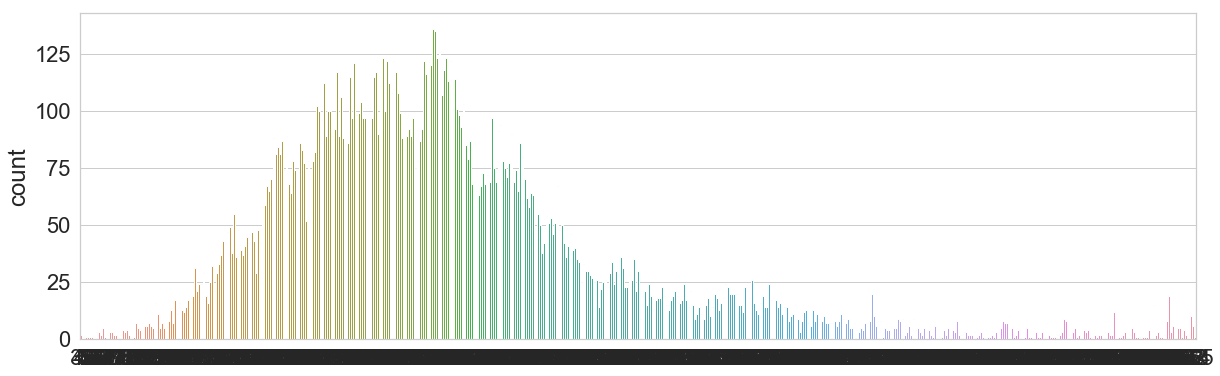

In [62]:
plt.figure(figsize=(20,6))
sns.countplot(nulls1, orient='h')

In [56]:
train1.drop_duplicates().shape, train.shape

((16405, 3171), (17521, 2391))

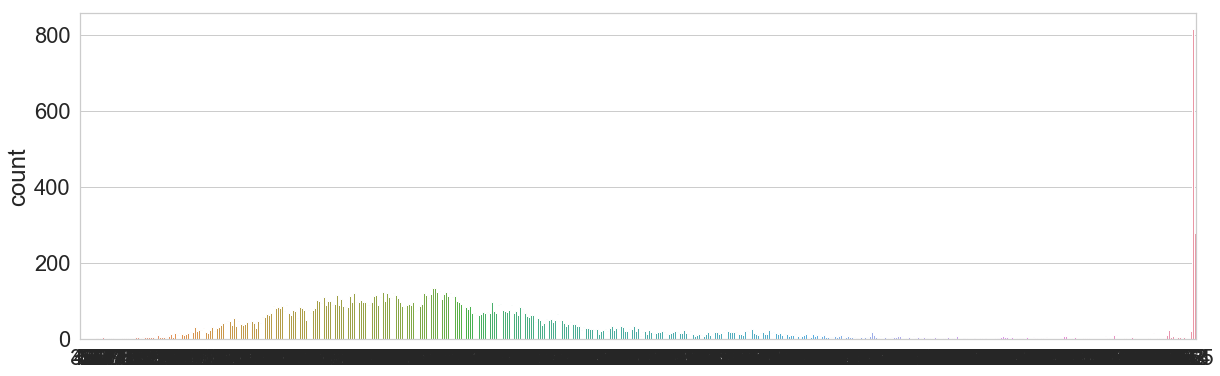

In [51]:
plt.figure(figsize=(20,6))
sns.countplot(train.isnull().sum(1), orient='h')

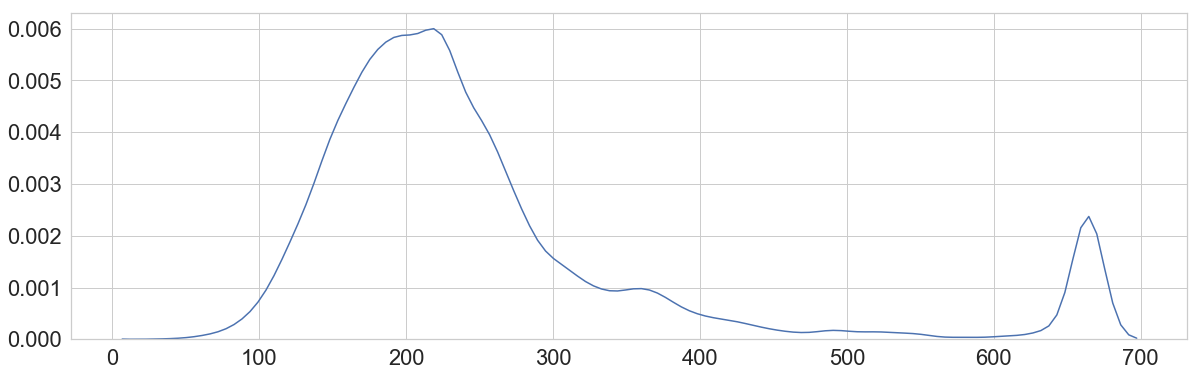

In [52]:
plt.figure(figsize=(20,6))
sns.kdeplot(train.isnull().sum(1))

In [ ]:
# params = {}
# for alpha in [0.1, 1, 10, 100]:
#     params['alpha'] = alpha
#     clf = LogisticRegression(
#             penalty='l1', dual=False, C=params['alpha'], fit_intercept=True, 
#             intercept_scaling=1, class_weight='balanced', random_state=1234, 
#             max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

#     clf.fit(X_tr, y_tr)
# #     clf.score(X_ts, y_ts)
#     print(cr(y_ts, clf.predict(X_ts)))
#     print("="*50)

In [ ]:
params = {}
for alpha in [0.1, 1, 10, 100]:
    params['alpha'] = alpha
    clf = LogisticRegression(
            penalty='elasticnet', dual=False, C=params['alpha'], fit_intercept=True, 
            intercept_scaling=1, class_weight='balanced', random_state=1234, 
            max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

    clf.fit(X_tr, y_tr)
#     clf.score(X_ts, y_ts)
    print(cr(y_ts, clf.predict(X_ts)))
    print("="*50)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(
    hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.001, batch_size='auto', 
    learning_rate='adaptive', learning_rate_init=0.01, power_t=0.5, max_iter=200, shuffle=True, 
    random_state=1567, tol=0.0001, verbose=True, warm_start=True, momentum=0.9, nesterovs_momentum=True, 
    early_stopping=True, validation_fraction=0.3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10
)
mlp_clf.fit(X_tr, y_tr)


In [101]:
clf1 = classifier_model('logistic')
clf1.fit(X_tr, y_tr)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=1234, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [82]:
clf1.score(X_ts, y_ts)

0.6881990413147683

In [102]:
clf1.score(X_ts, y_ts)

0.8367952522255193

In [86]:
# ybins = [1.0 if y > 0.5 else 0 for y in oof_cat2]
print(cr(y_ts, clf1.predict(X_ts)))

              precision    recall  f1-score   support

           0       0.94      0.70      0.80      3941
           1       0.18      0.61      0.28       440

   micro avg       0.69      0.69      0.69      4381
   macro avg       0.56      0.65      0.54      4381
weighted avg       0.87      0.69      0.75      4381



In [106]:
clf1.predict(X_ts), clf1.predict(X_ts).sum()

(array([0, 0, 0, ..., 0, 0, 0]), 411)

In [105]:
print(cr(y_ts, clf1.predict(X_ts)))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3941
           1       0.17      0.15      0.16       440

   micro avg       0.84      0.84      0.84      4381
   macro avg       0.54      0.53      0.53      4381
weighted avg       0.83      0.84      0.83      4381



In [99]:
clf1.predict(X_ts)

array([0, 1, 1, ..., 0, 0, 0])

In [100]:
clf_cat2[0].predict(X_ts)

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:

# print("bayesian ridge","="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'bayesian_ridge', std_norm=False, kernel_func='linear', degree=3)
# print(best)

# print("lasso","="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'lasso', std_norm=False, kernel_func='linear', degree=3)
# print(best)

# print("elastic_net", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'elastic_net', std_norm=False, kernel_func='linear', degree=3)
# print(best)

# print("ridge", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'ridge', std_norm=False, kernel_func='linear', degree=3)
# print(best)

# print("kernel_ridge", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'kernel_ridge', std_norm=False, kernel_func='linear', degree=3)
# print(best)

# print("kernel_ridge", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'kernel_ridge', std_norm=False, kernel_func='rbf', degree=3)
# print(best)

# print("kernel_ridge", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'kernel_ridge', std_norm=False, kernel_func='poly', degree=3)
# print(best)

# print("svm", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'svm', std_norm=False, kernel_func='poly', degree=3)
# print(best)
# print("="*50)










In [ ]:
# https://github.com/jeweinberg/Pandas-MICE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
import numpy as np
import pandas as pd

class MiceImputer:
    
    model_dict_ = {}
    
    def __init__(self, seed_nulls=False, seed_strategy='mean'):
        self.seed_nulls = seed_nulls
        self.seed_strategy = seed_strategy
        
    
    def transform(self, X):
        col_order = X.columns
        new_X = []
        mutate_cols = list(self.model_dict_.keys())
        
        for i in mutate_cols:
            y = X[i]
            x_null = X[y.isnull()]
            y_null = y[y.isnull()].reset_index()['index']
            y_notnull = y[y.notnull()]
            
            model = self.model_dict_.get(i)
            
            if self.seed_nulls:
                x_null = model[1].transform(x_null)
            else:
                null_check = x_null.isnull().any()
                x_null = x_null[null_check.index[~null_check]]
            
            pred = pd.concat([pd.Series(model[0].predict(x_null))\
                              .to_frame()\
                              .set_index(y_null),y_notnull], axis=0)\
                              .rename(columns={0: i})
            
            new_X.append(pred)

        new_X.append(X[X.columns.difference(mutate_cols)])

        final = pd.concat(new_X, axis=1)[col_order]

        return final
        
        
    def fit(self, X):      
        x = X.fillna(value=np.nan)

        null_check = x.isnull().any()
        null_data = x[null_check.index[null_check]]
        
        for i in null_data:
            y = null_data[i]
            y_notnull = y[y.notnull()]

            model_list = []
            if self.seed_nulls:
                imp = Imputer(strategy=self.seed_strategy)
                model_list.append(imp.fit(x))
                non_null_data = pd.DataFrame(imp.fit_transform(x))
                
            else:
                non_null_data = x[null_check.index[~null_check]]
                
            
            x_notnull = non_null_data[y.notnull()]
            
            if y.nunique() > 2:
                model = LinearRegression()
                model.fit(x_notnull, y_notnull)
                model_list.insert(0, model)
                self.model_dict_.update({i: model_list})
            else:
                model = LogisticRegression()
                model.fit(x_notnull, y_notnull)
                model_list.insert(0, model)
                self.model_dict_.update({i: model_list})

        return self
        

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [36]:
len(set(imp_cols).intersection(set(num_cols)))

228

Printing from 0 to 10


<Figure size 432x288 with 0 Axes>

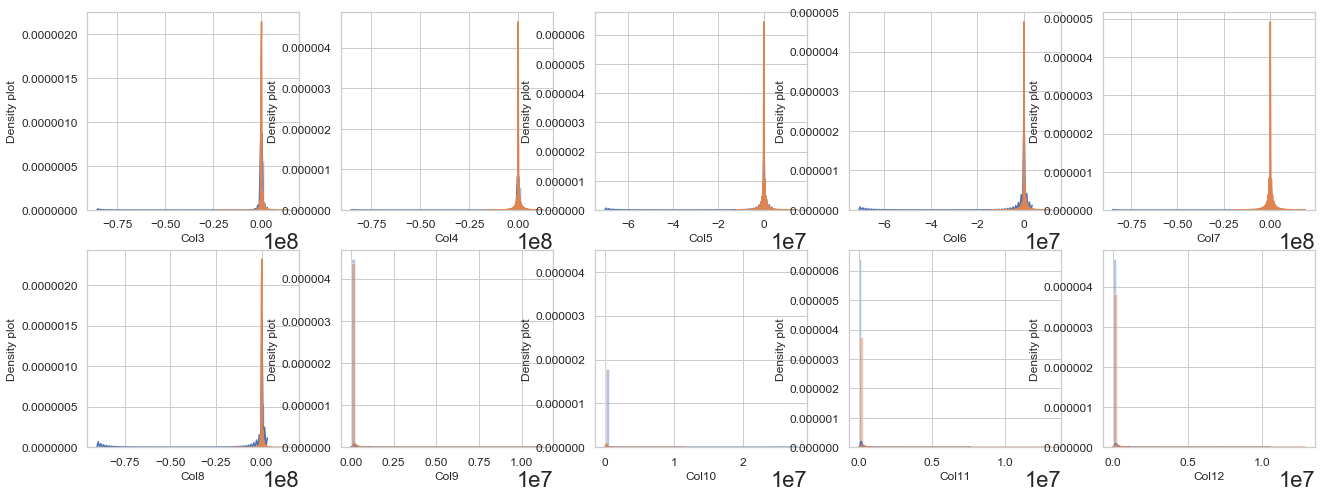

Printing from 10 to 20


<Figure size 432x288 with 0 Axes>

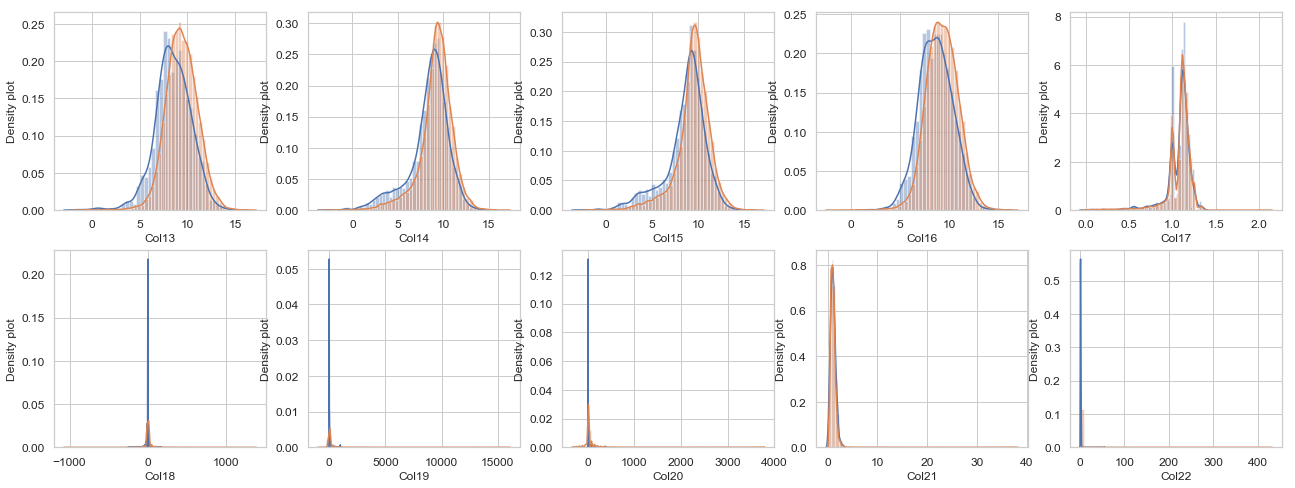

Printing from 20 to 30


<Figure size 432x288 with 0 Axes>

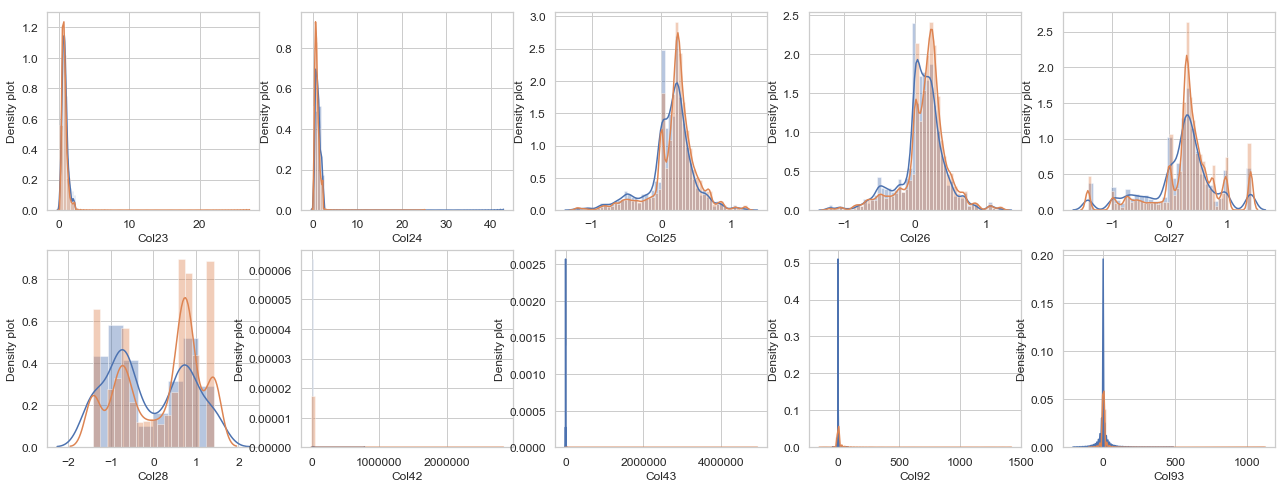

Printing from 30 to 40


<Figure size 432x288 with 0 Axes>

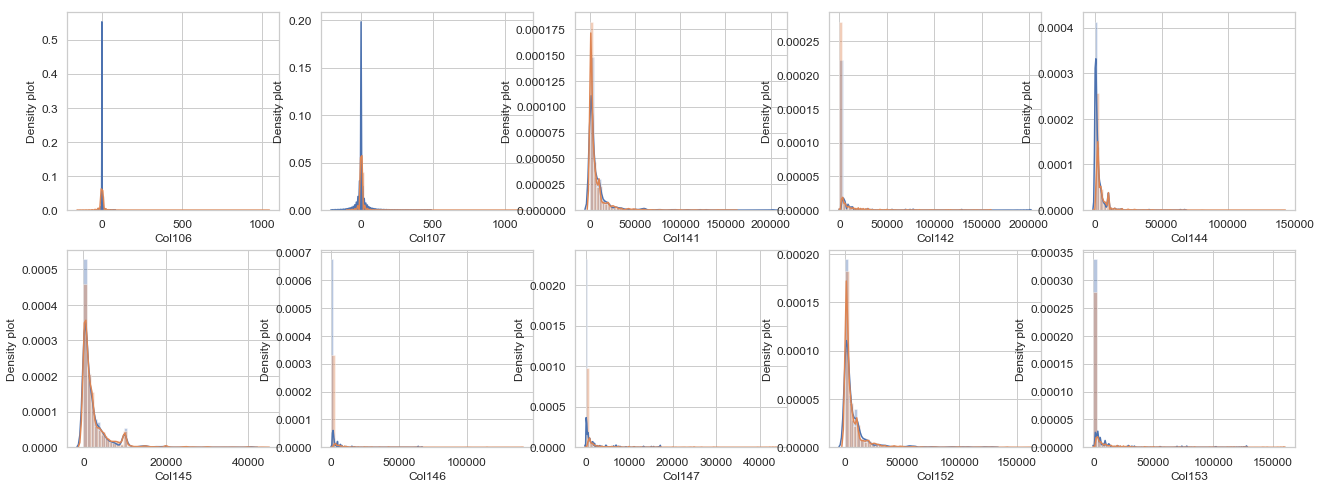

Printing from 40 to 50


<Figure size 432x288 with 0 Axes>

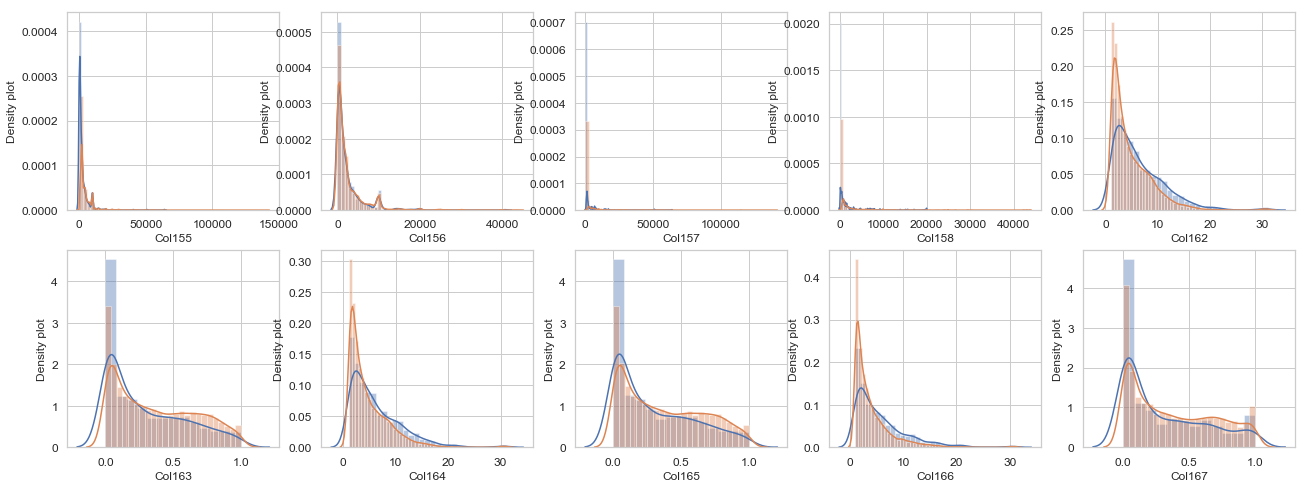

Printing from 50 to 60


<Figure size 432x288 with 0 Axes>

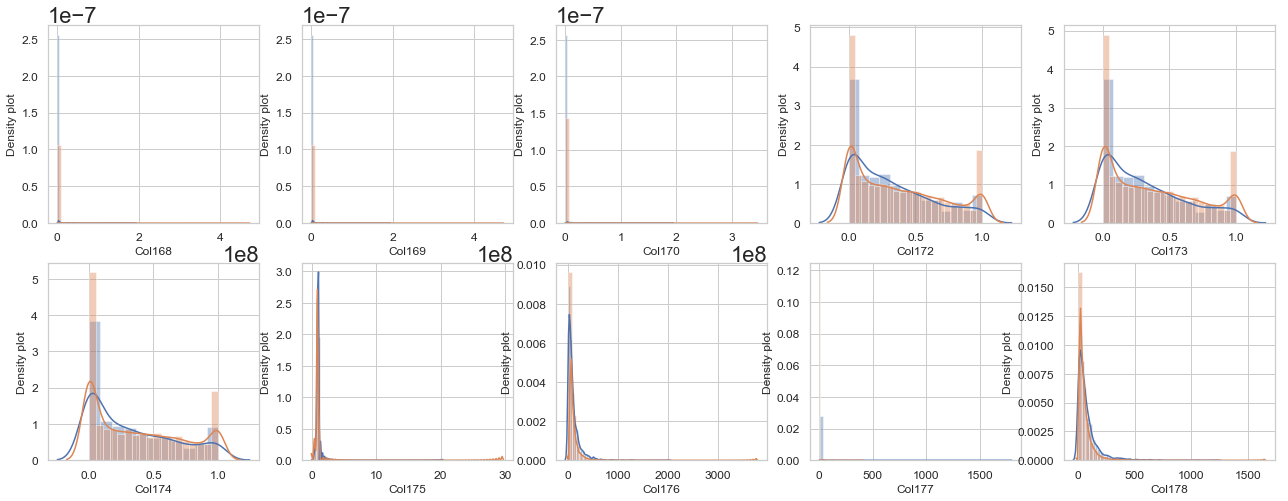

Printing from 60 to 70


<Figure size 432x288 with 0 Axes>

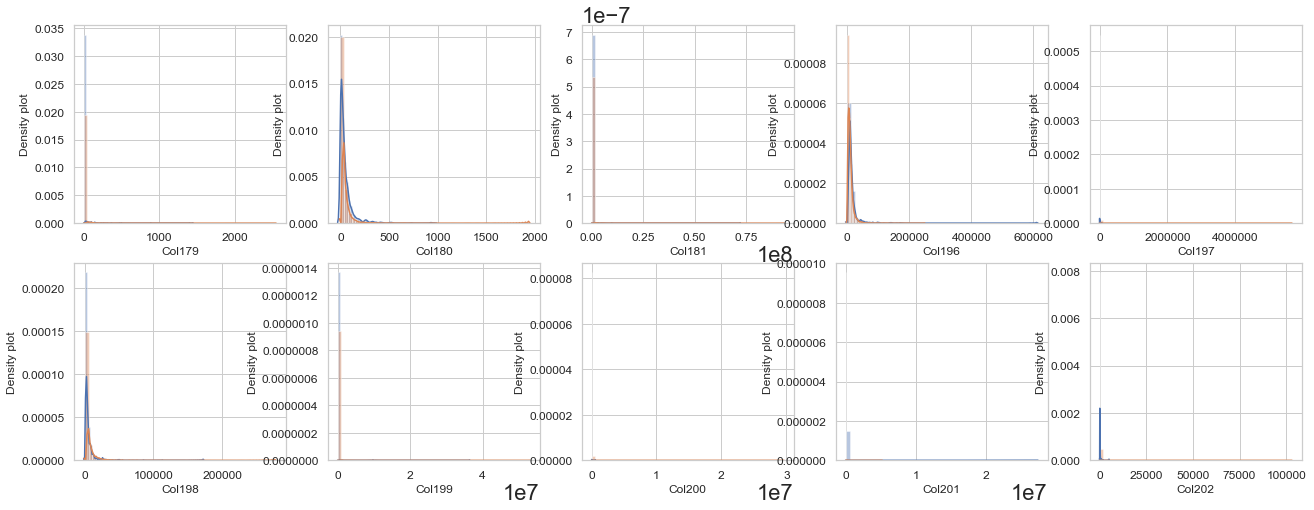

Printing from 70 to 80


<Figure size 432x288 with 0 Axes>

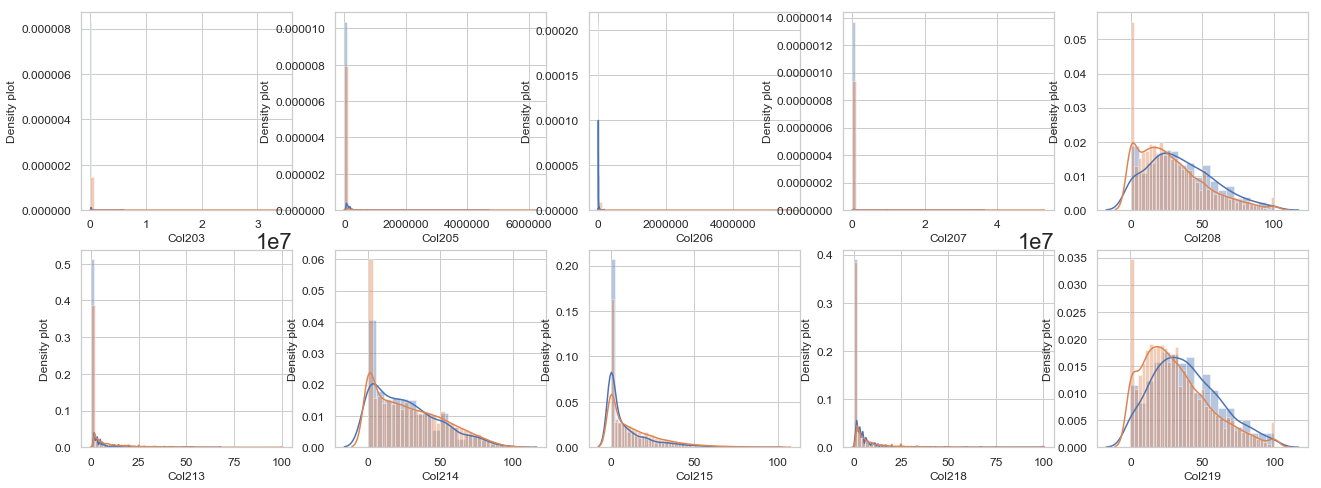

Printing from 80 to 90


<Figure size 432x288 with 0 Axes>

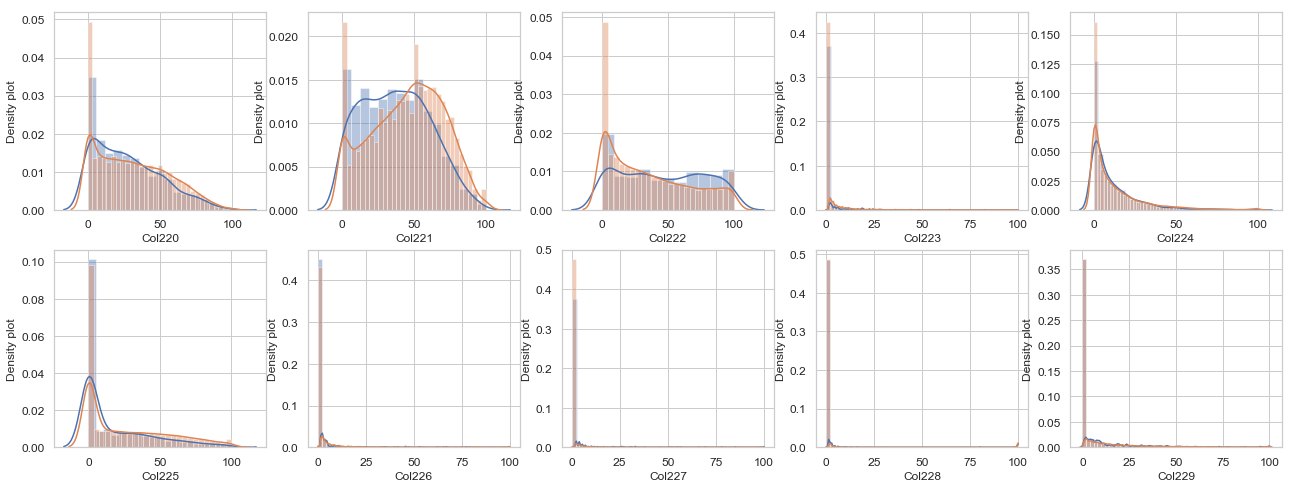

Printing from 90 to 100


<Figure size 432x288 with 0 Axes>

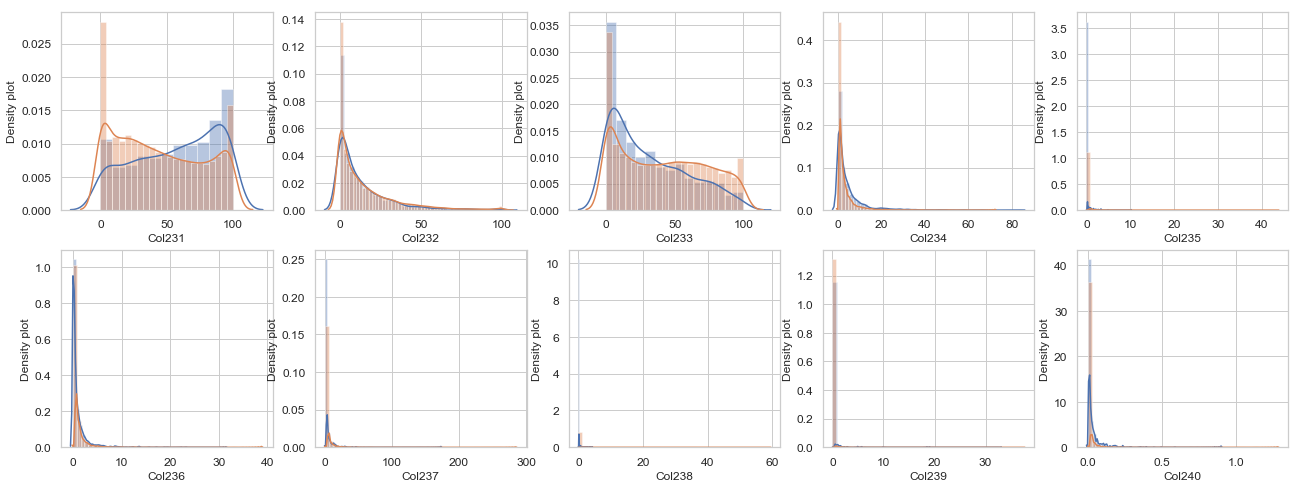

In [35]:
def plot_distribution(var):
    
    i = 0
    t1 = train.loc[target != 0]
    t0 = train.loc[target == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var:
        i += 1
        plt.subplot(2,5,i)
        sns.distplot(t1[feature].dropna(),label="cls: 1")
        sns.distplot(t0[feature].dropna(),label="cls: 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()
    
    
for i in range(10):
    print("Printing from {} to {}".format(i*10, (i+1)*10))
    plot_distribution(num_cols[i*10:(i+1)*10])

In [54]:
train1 = train.copy()
train1.dropna(axis=0).shape, train1.dropna(axis=1).shape

((0, 2391), (17521, 1634))

In [61]:
cat_cols

['Col29',
 'Col30',
 'Col31',
 'Col32',
 'Col33',
 'Col34',
 'Col35',
 'Col36',
 'Col37',
 'Col38',
 'Col39',
 'Col40',
 'Col41',
 'Col44',
 'Col45',
 'Col46',
 'Col47',
 'Col48',
 'Col49',
 'Col50',
 'Col51',
 'Col52',
 'Col53',
 'Col54',
 'Col55',
 'Col56',
 'Col57',
 'Col58',
 'Col59',
 'Col60',
 'Col61',
 'Col62',
 'Col63',
 'Col64',
 'Col65',
 'Col66',
 'Col67',
 'Col68',
 'Col69',
 'Col70',
 'Col71',
 'Col72',
 'Col73',
 'Col74',
 'Col75',
 'Col76',
 'Col77',
 'Col78',
 'Col79',
 'Col80',
 'Col81',
 'Col82',
 'Col83',
 'Col84',
 'Col85',
 'Col86',
 'Col87',
 'Col88',
 'Col89',
 'Col90',
 'Col91',
 'Col94',
 'Col95',
 'Col96',
 'Col97',
 'Col98',
 'Col99',
 'Col100',
 'Col101',
 'Col102',
 'Col103',
 'Col104',
 'Col105',
 'Col108',
 'Col109',
 'Col110',
 'Col111',
 'Col112',
 'Col113',
 'Col114',
 'Col115',
 'Col116',
 'Col117',
 'Col118',
 'Col119',
 'Col120',
 'Col121',
 'Col122',
 'Col123',
 'Col124',
 'Col125',
 'Col126',
 'Col127',
 'Col128',
 'Col129',
 'Col130',
 'Col131',


In [65]:
train['Col32'].value_counts()

1      11360
2       4182
3       1186
4        431
5        126
6         74
7         50
8         25
13        13
10        13
9         11
11        10
12         8
14         5
15         3
21         3
19         3
16         3
18         2
22         1
23         1
24         1
68         1
36         1
20         1
25         1
26         1
27         1
28         1
17         1
44         1
134        1
Name: Col32, dtype: int64

Printing from 0 to 10


<Figure size 432x288 with 0 Axes>

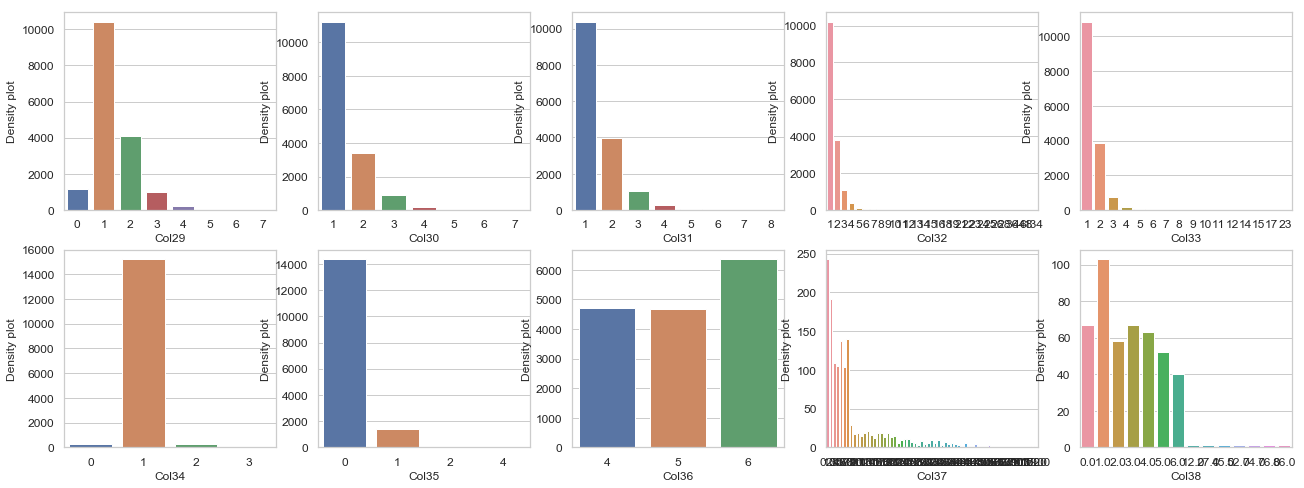

Printing from 10 to 20


<Figure size 432x288 with 0 Axes>

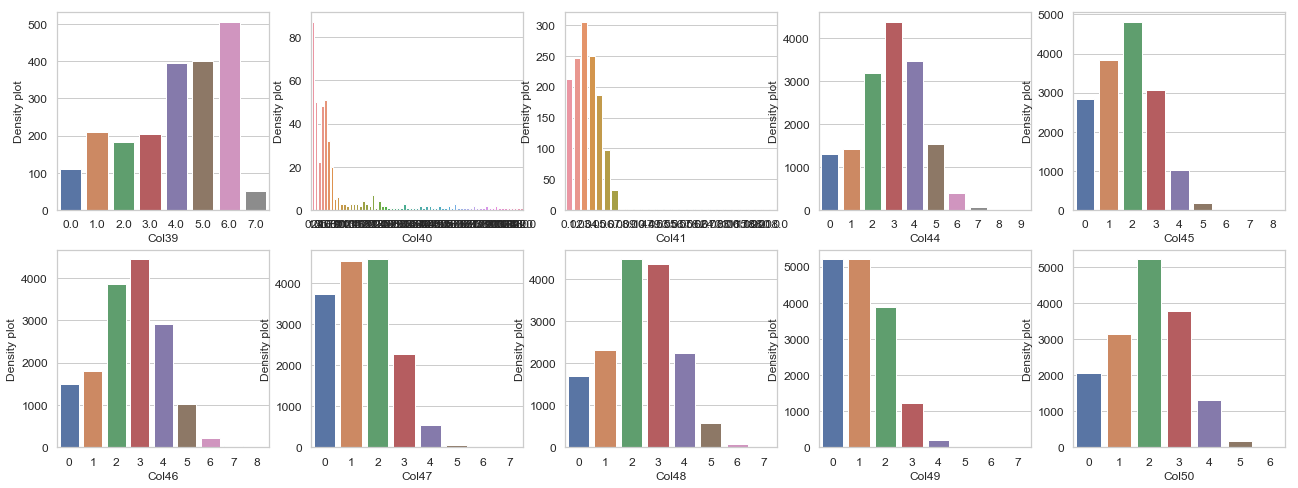

Printing from 20 to 30


<Figure size 432x288 with 0 Axes>

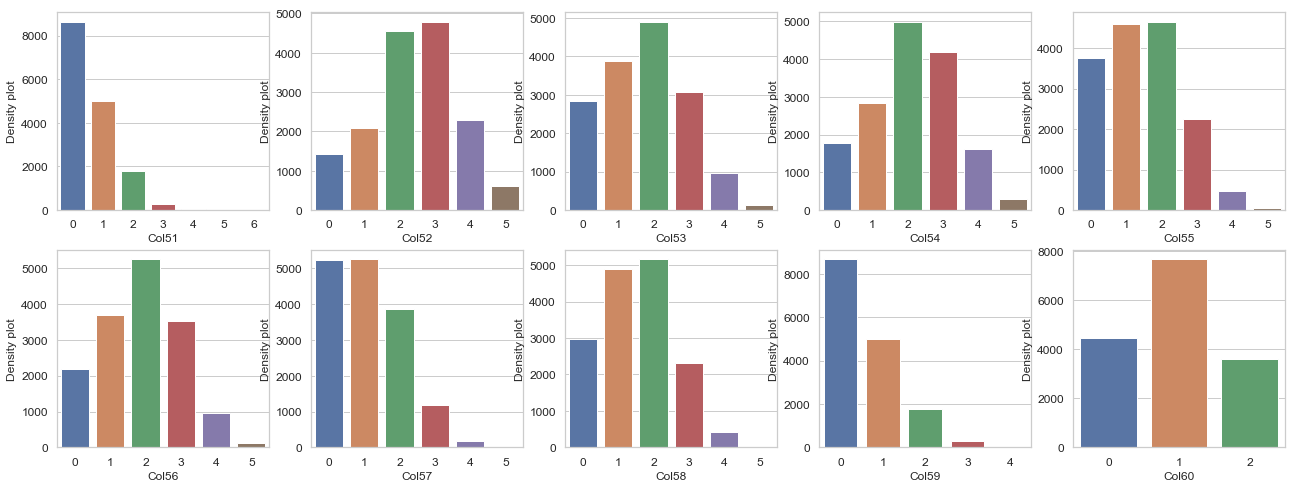

Printing from 30 to 40


<Figure size 432x288 with 0 Axes>

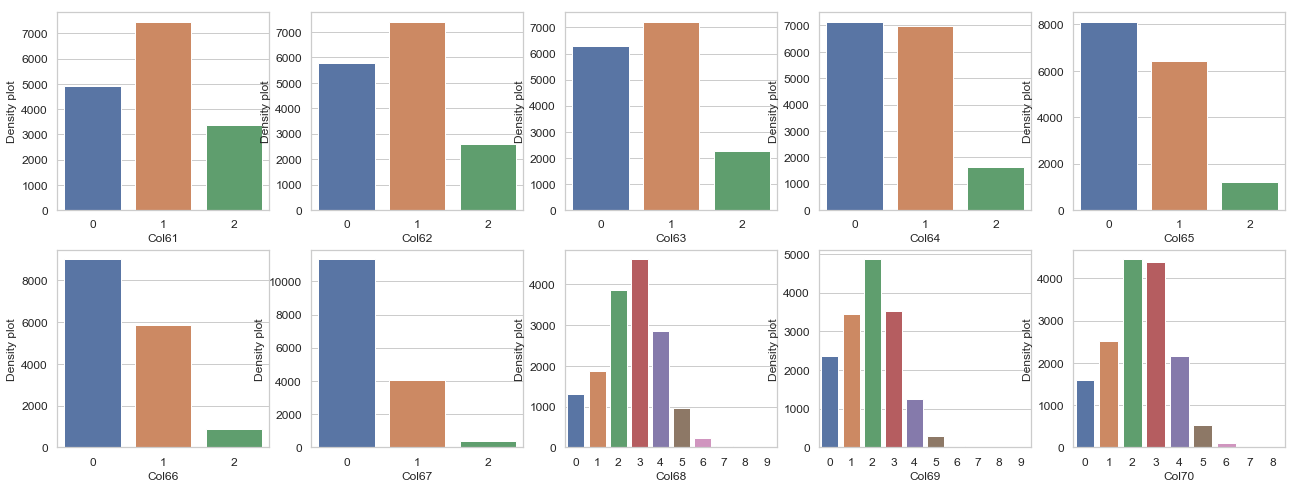

Printing from 40 to 50


<Figure size 432x288 with 0 Axes>

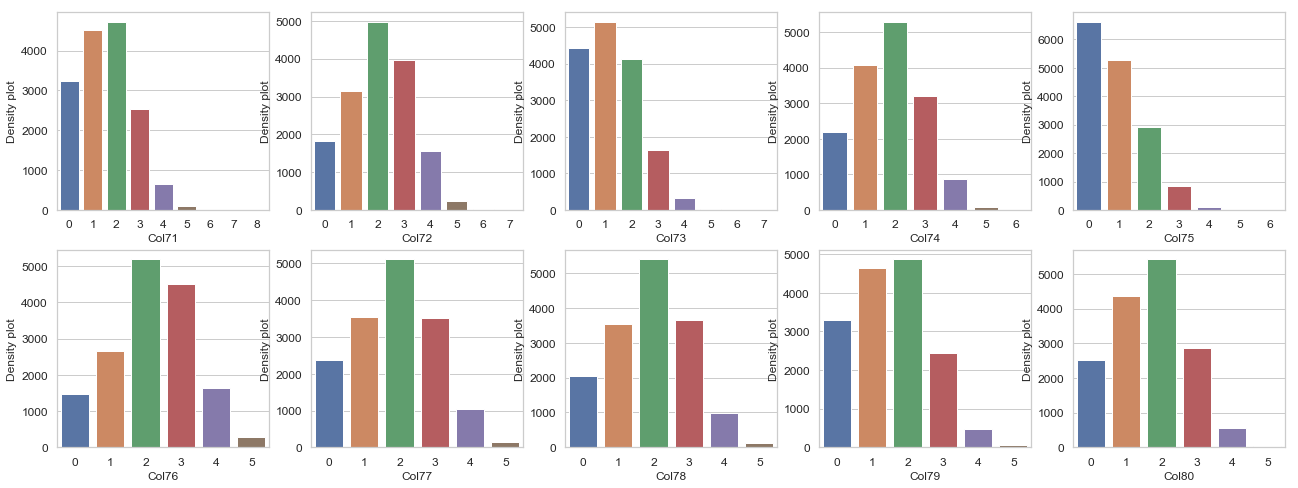

Printing from 50 to 60


<Figure size 432x288 with 0 Axes>

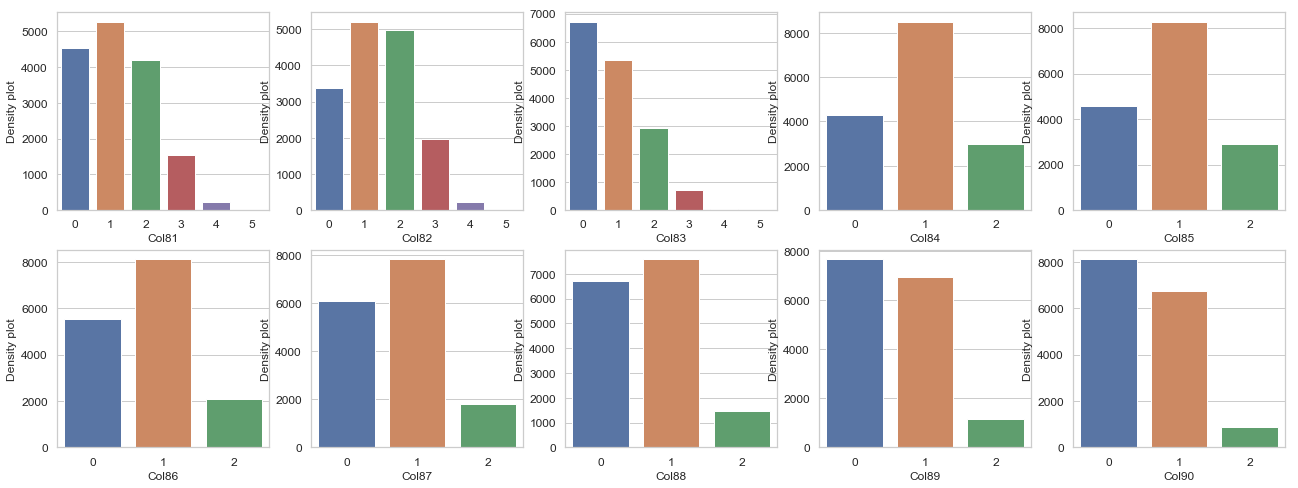

Printing from 60 to 70


<Figure size 432x288 with 0 Axes>

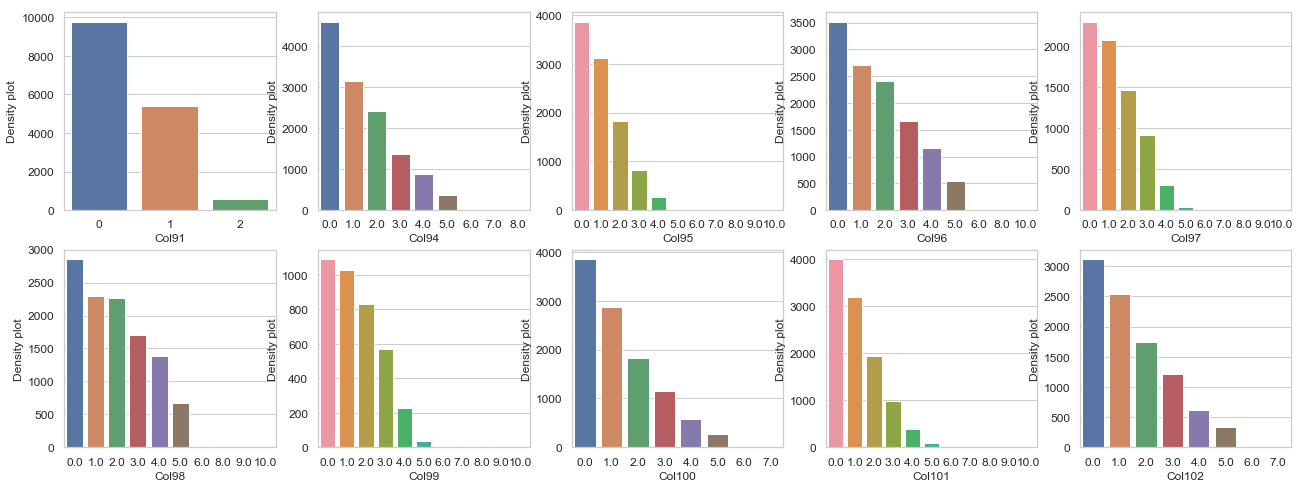

Printing from 70 to 80


<Figure size 432x288 with 0 Axes>

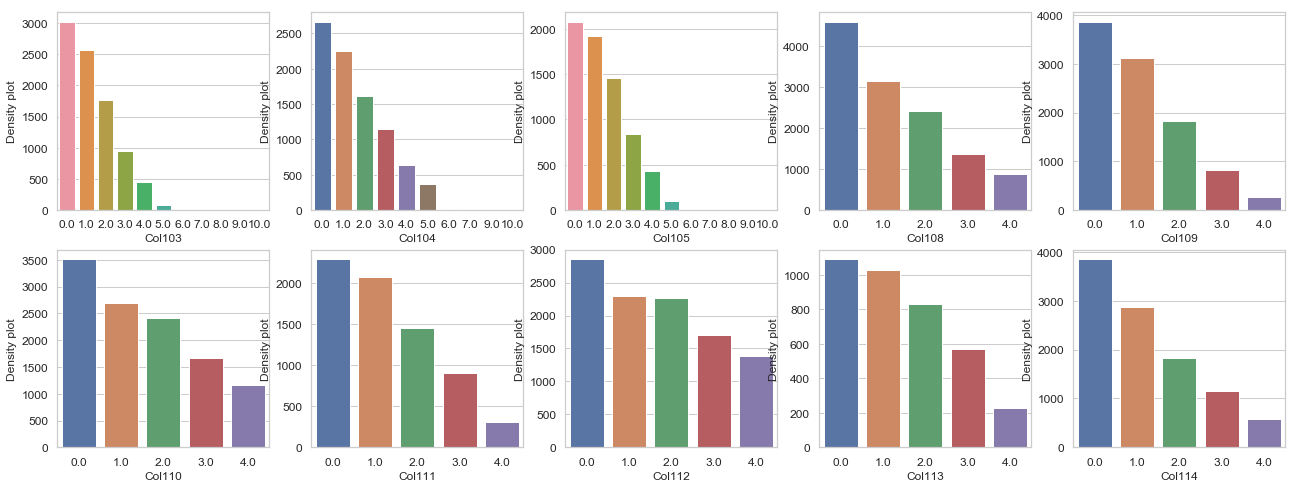

Printing from 80 to 90


<Figure size 432x288 with 0 Axes>

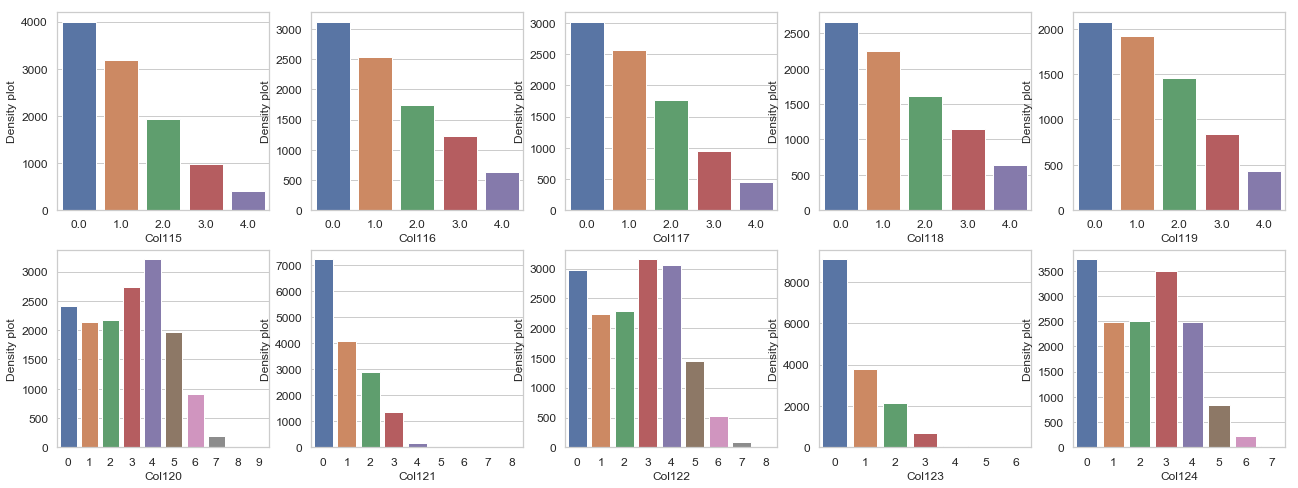

Printing from 90 to 100


<Figure size 432x288 with 0 Axes>

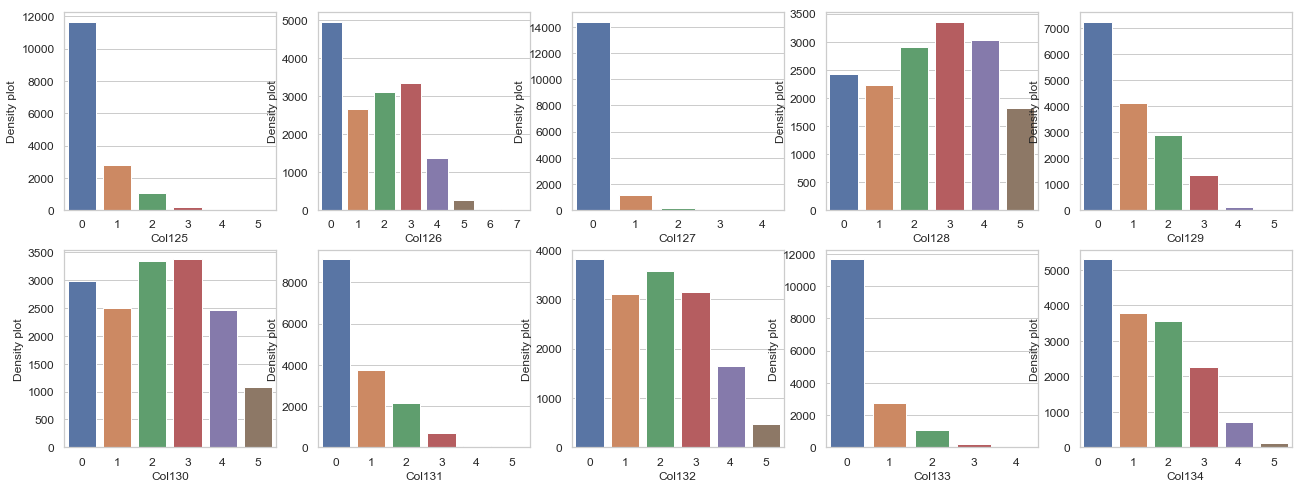

In [62]:
def plot_cat_distribution(var):
    
    i = 0
    t1 = train.loc[target != 0]
    t0 = train.loc[target == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var:
        i += 1
        plt.subplot(2,5,i)
        sns.countplot(t1[feature],label="cls: 1")
        sns.countplot(t0[feature],label="cls: 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()
    
    
for i in range(10):
    print("Printing from {} to {}".format(i*10, (i+1)*10))
    plot_distribution(cat_cols[i*10:(i+1)*10])

Printing from 100 to 110


<Figure size 432x288 with 0 Axes>

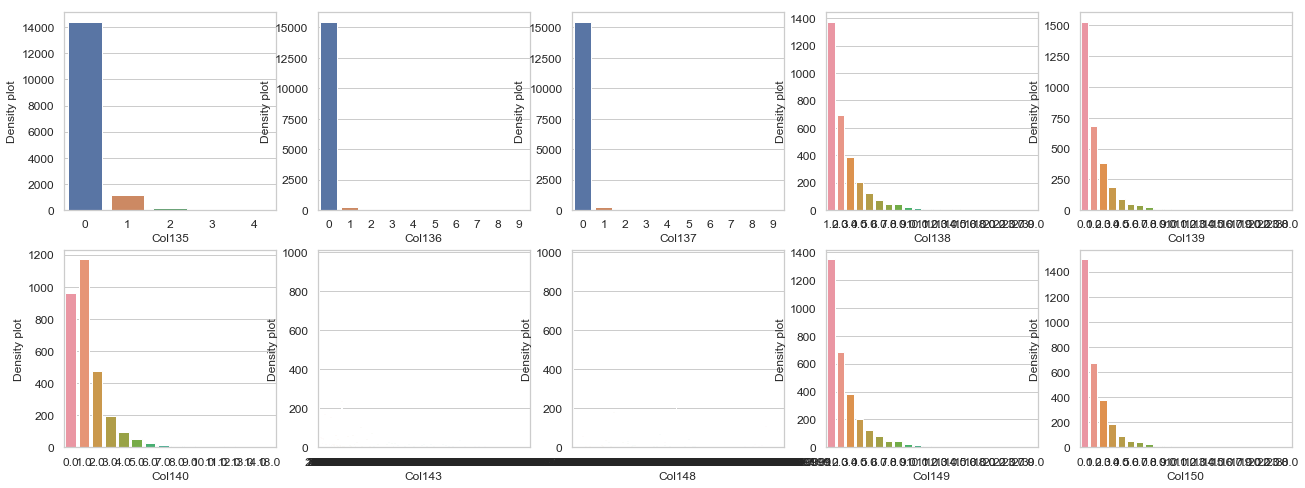

Printing from 110 to 120


<Figure size 432x288 with 0 Axes>

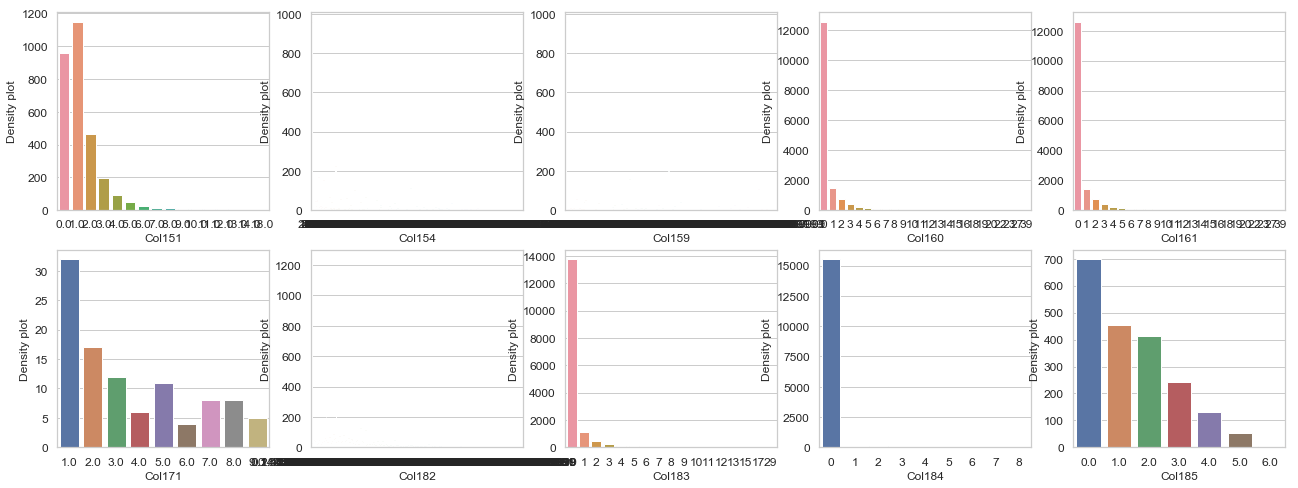

Printing from 120 to 130


<Figure size 432x288 with 0 Axes>

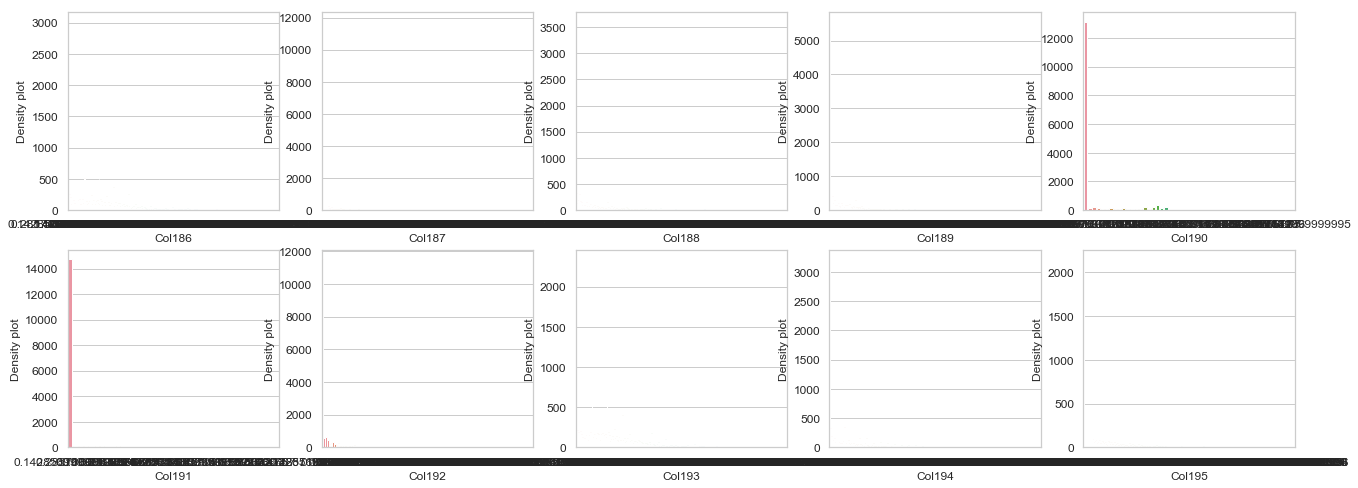

Printing from 130 to 140


<Figure size 432x288 with 0 Axes>

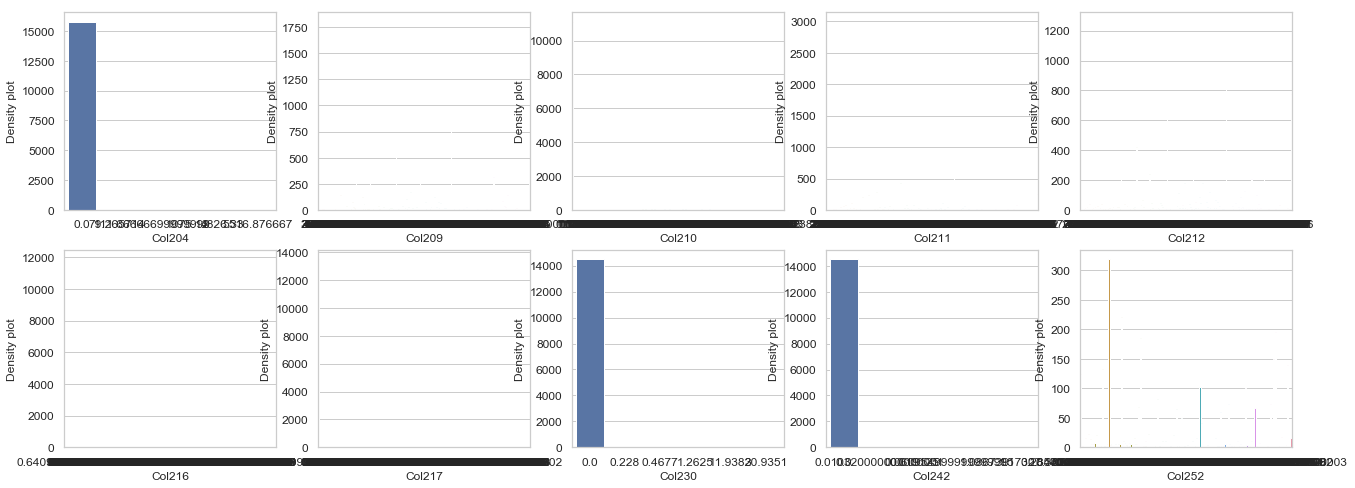

Printing from 140 to 150


<Figure size 432x288 with 0 Axes>

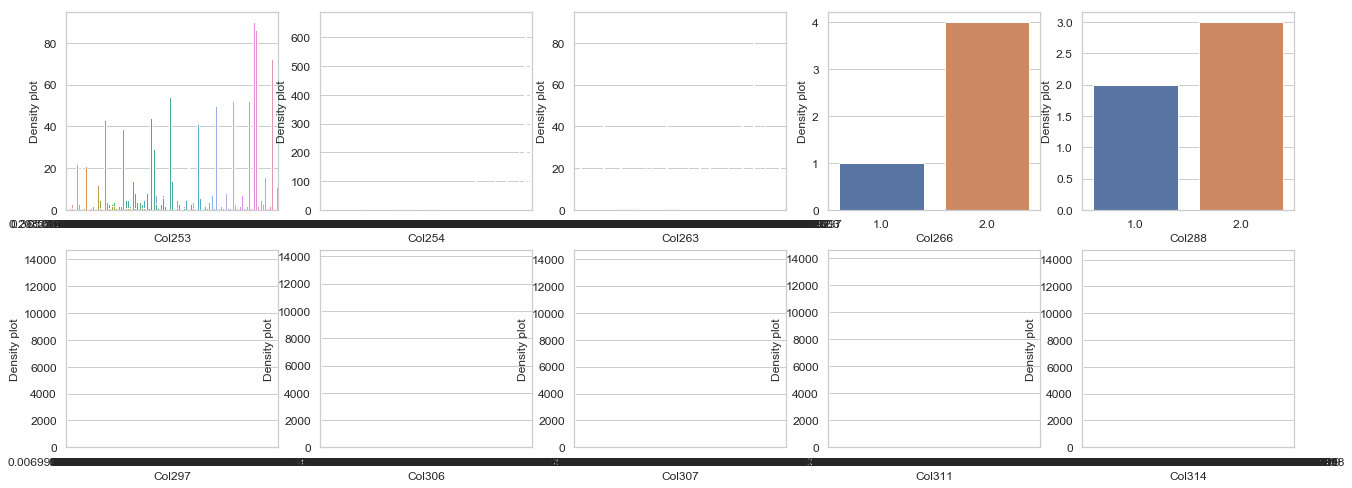

Printing from 150 to 160


<Figure size 432x288 with 0 Axes>

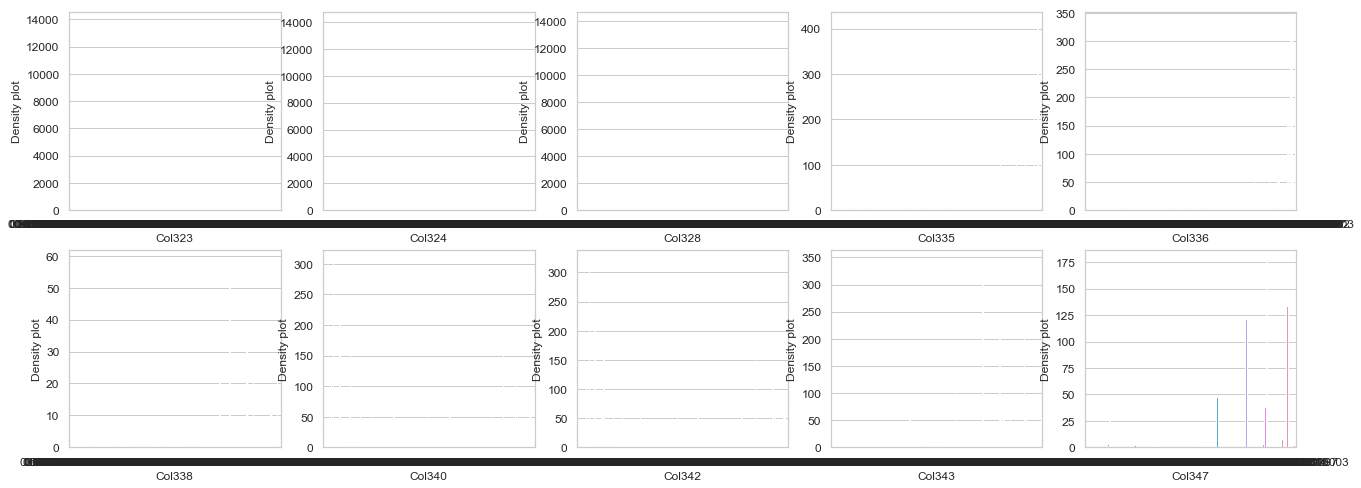

Printing from 160 to 170


<Figure size 432x288 with 0 Axes>

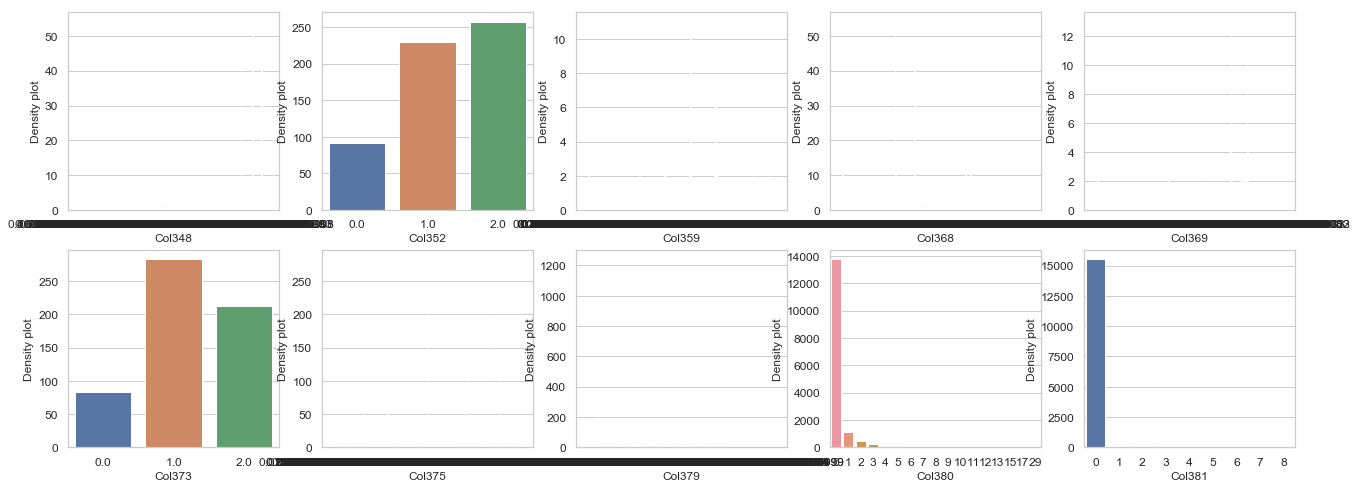

Printing from 170 to 180


<Figure size 432x288 with 0 Axes>

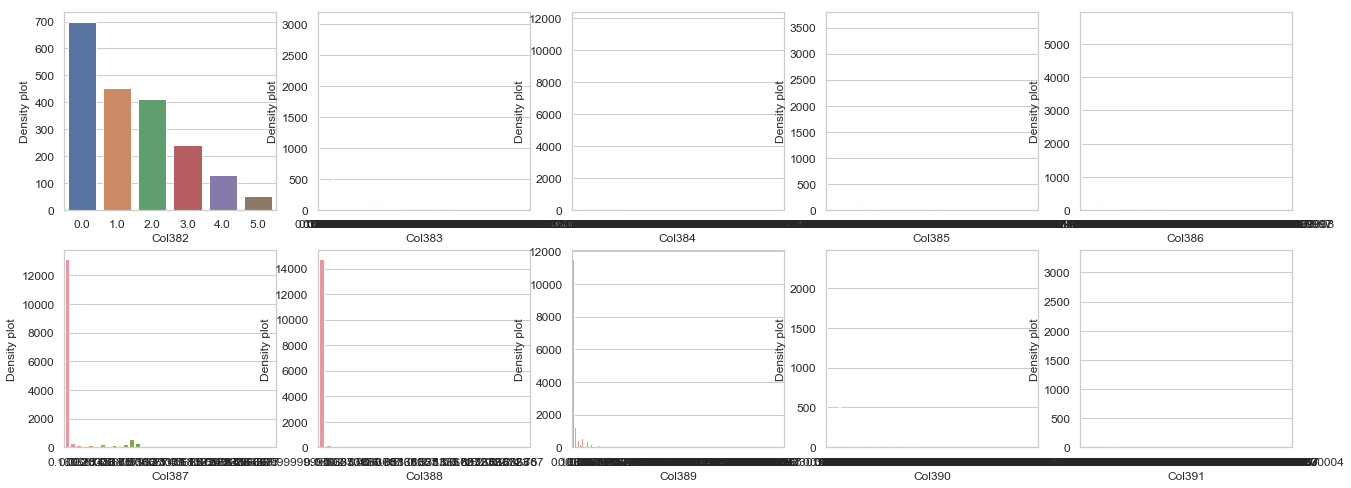

Printing from 180 to 190


<Figure size 432x288 with 0 Axes>

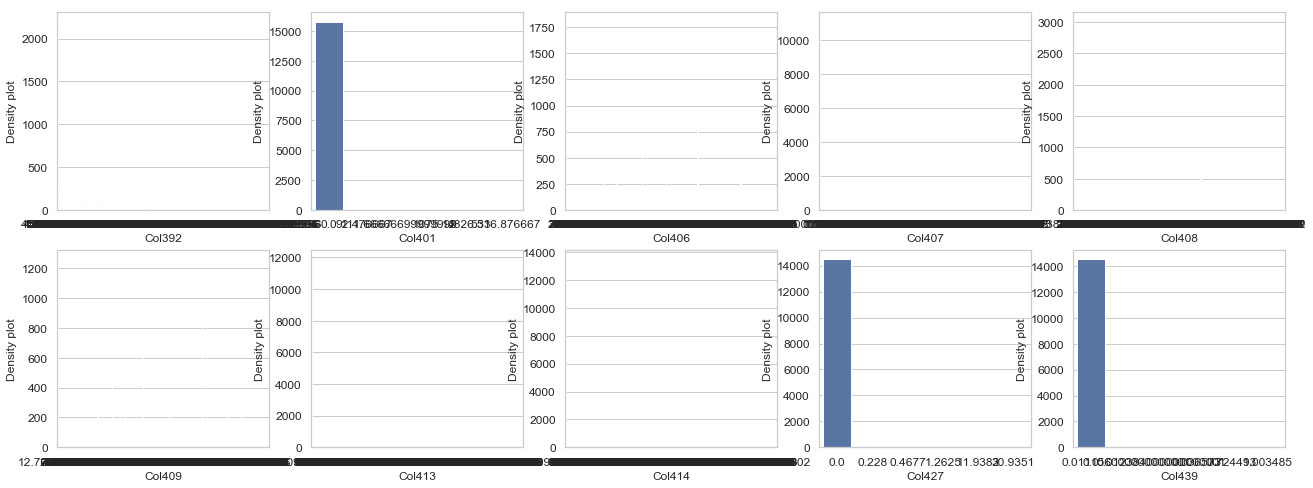

Printing from 190 to 200


<Figure size 432x288 with 0 Axes>

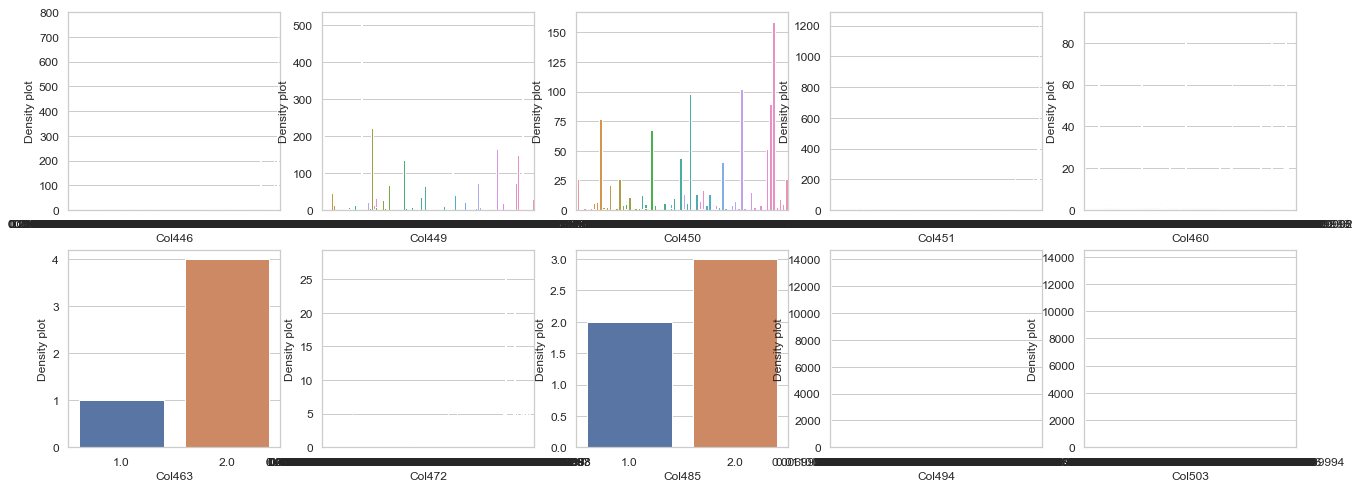

In [67]:
for i in range(10,20):
    print("Printing from {} to {}".format(i*10, (i+1)*10))
    plot_distribution(cat_cols[i*10:(i+1)*10])

In [ ]:
143, 148, 154, 159, 182, 184 [120-140]

train['Col32'].value_counts()

In [68]:
def plot_cat_distribution(var):
    
    i = 0
    t1 = train.loc[target != 0]
    t0 = train.loc[target == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var:
        i += 1
        plt.subplot(2,5,i)
        sns.countplot(t1[feature],label="cls: 1")
        sns.countplot(t0[feature],label="cls: 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()
    
    
# for i in range(10):
#     print("Printing from {} to {}".format(i*10, (i+1)*10))
#     plot_distribution(cat_cols[i*10:(i+1)*10])

In [69]:
def plot_distribution(var):
    
    i = 0
    t1 = train.loc[target != 0]
    t0 = train.loc[target == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var:
        i += 1
        plt.subplot(2,5,i)
        sns.distplot(t1[feature].dropna(),label="cls: 1")
        sns.distplot(t0[feature].dropna(),label="cls: 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()


Printing from 100 to 110


<Figure size 432x288 with 0 Axes>

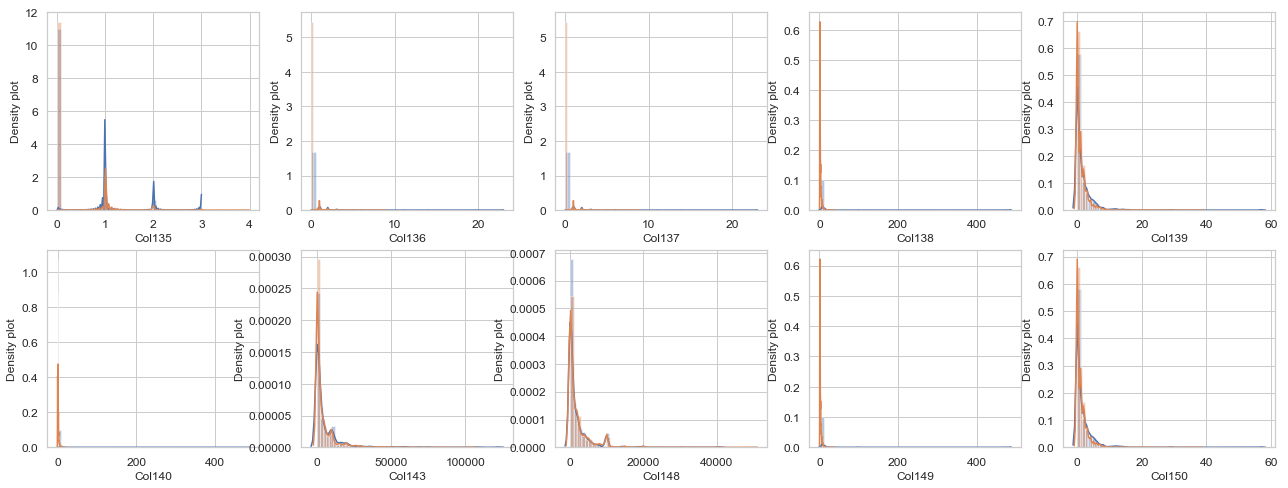

Printing from 110 to 120


<Figure size 432x288 with 0 Axes>

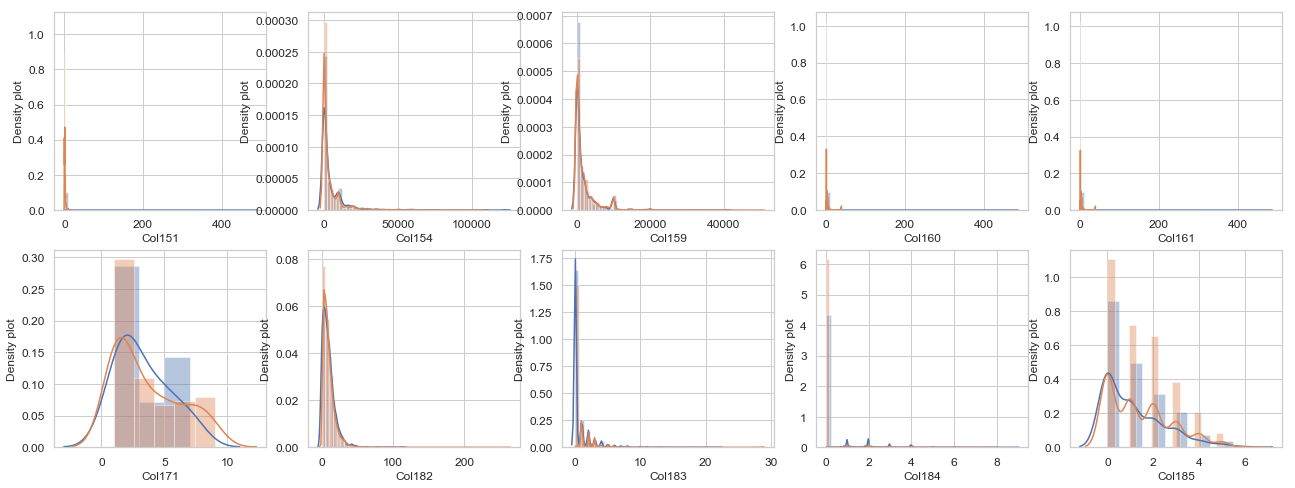

Printing from 120 to 130


<Figure size 432x288 with 0 Axes>

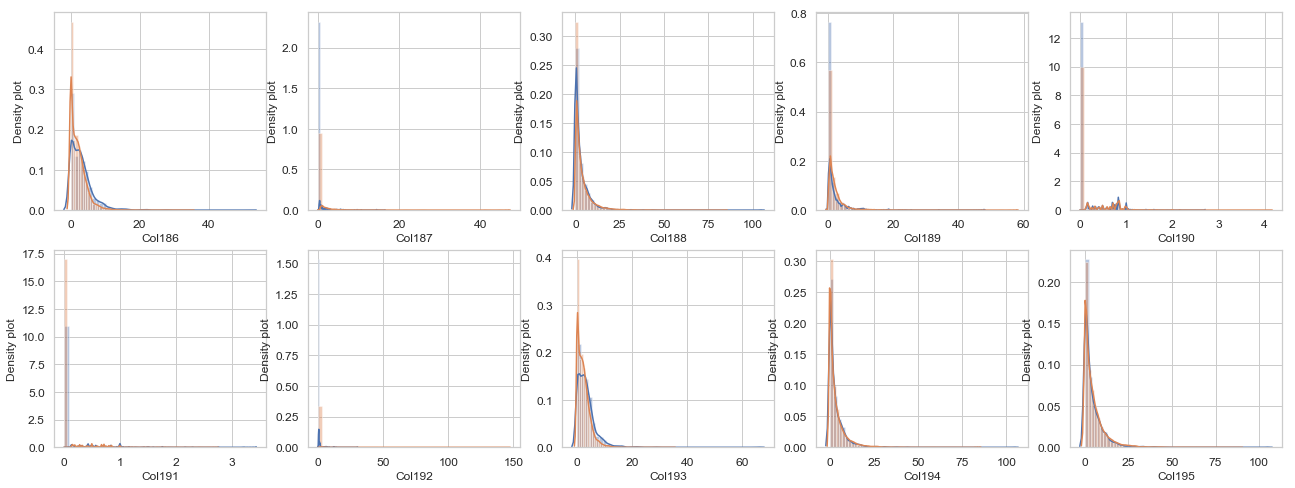

Printing from 130 to 140


<Figure size 432x288 with 0 Axes>

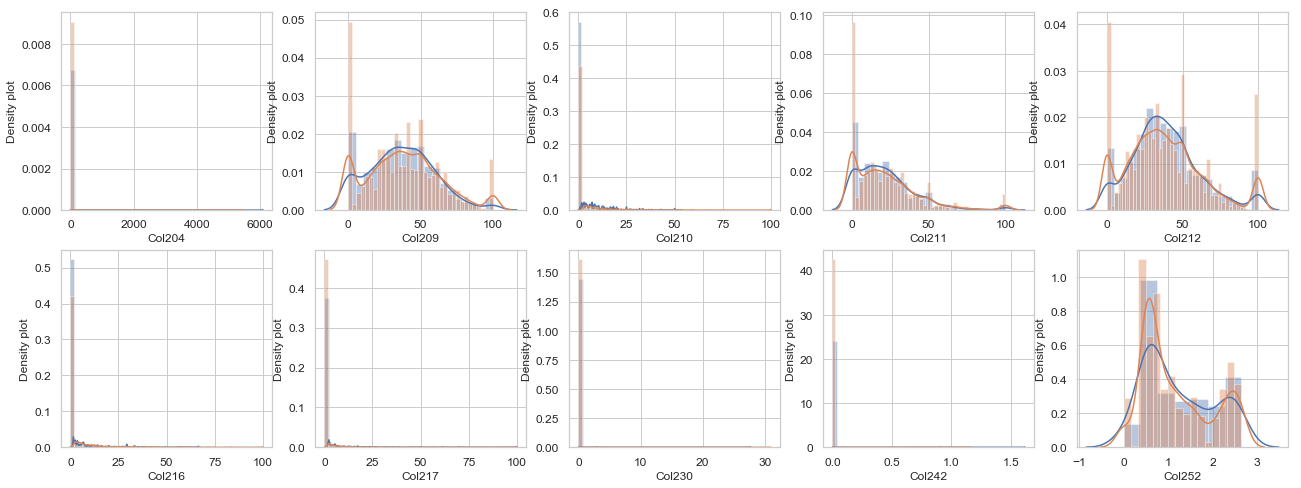

Printing from 140 to 150


<Figure size 432x288 with 0 Axes>

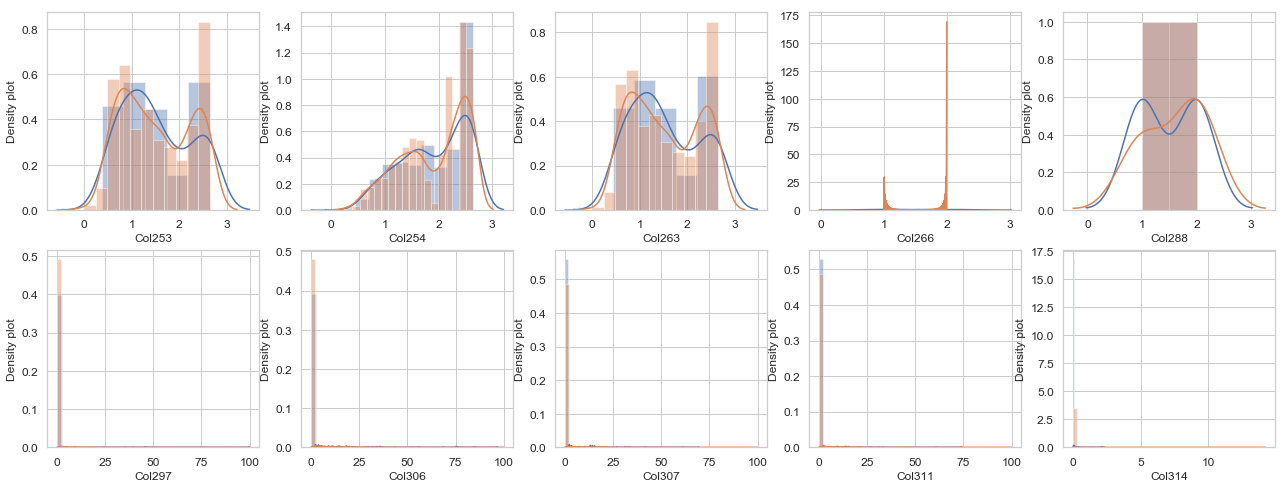

Printing from 150 to 160


<Figure size 432x288 with 0 Axes>

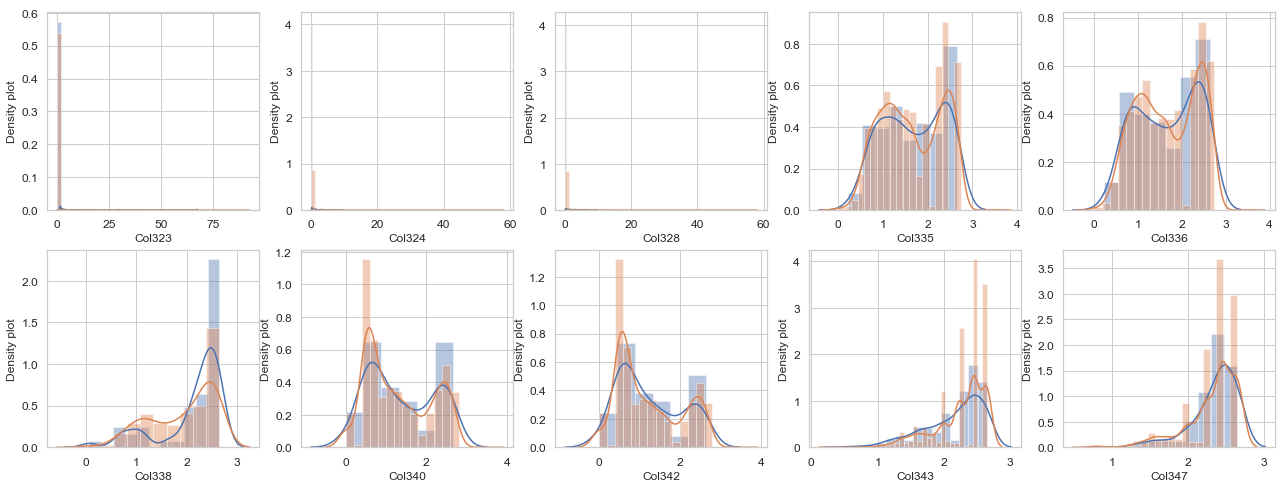

Printing from 160 to 170


<Figure size 432x288 with 0 Axes>

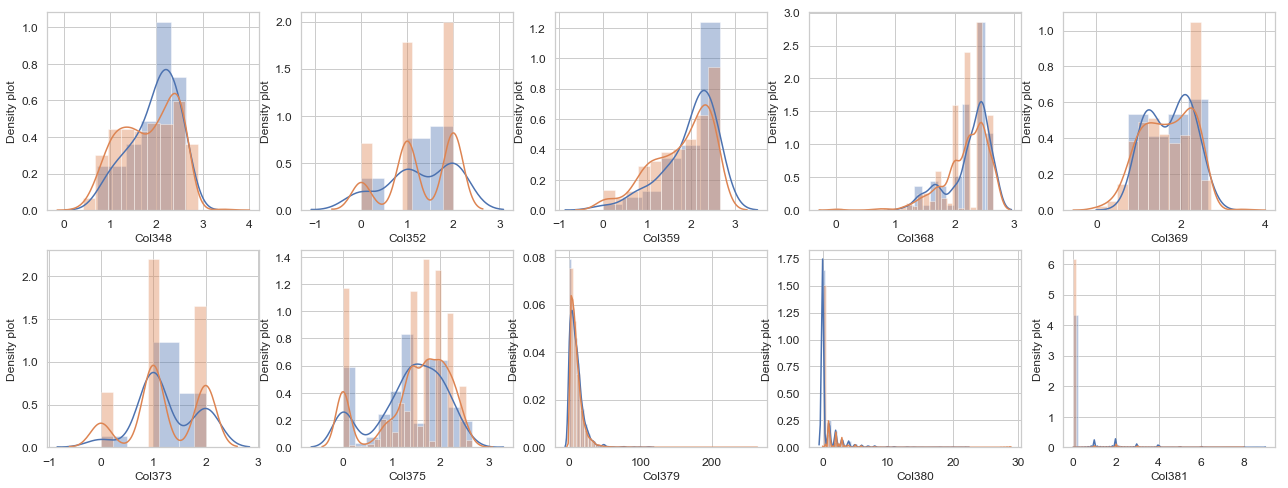

Printing from 170 to 180


<Figure size 432x288 with 0 Axes>

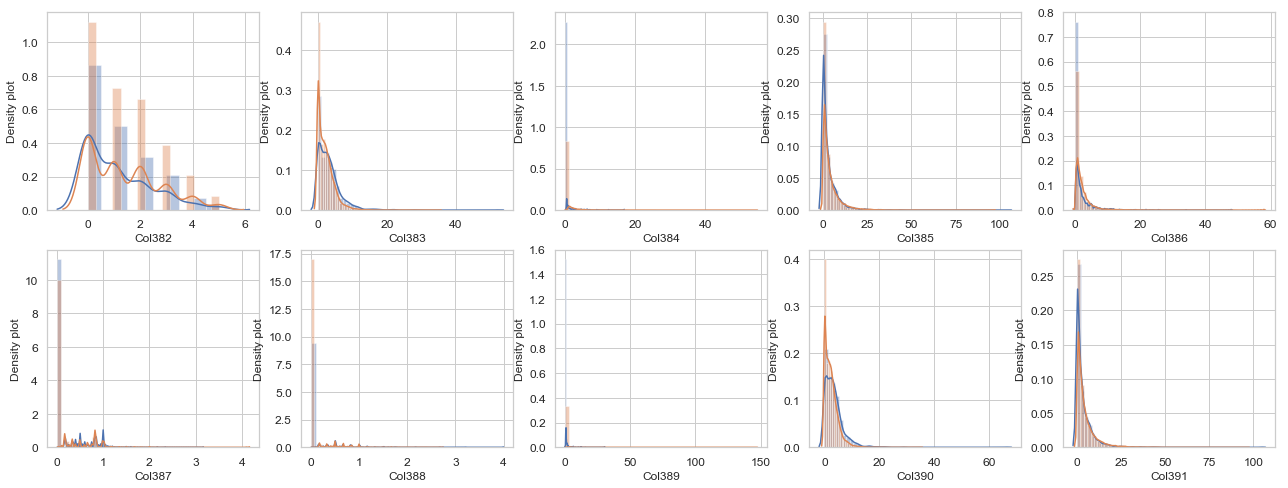

Printing from 180 to 190


<Figure size 432x288 with 0 Axes>

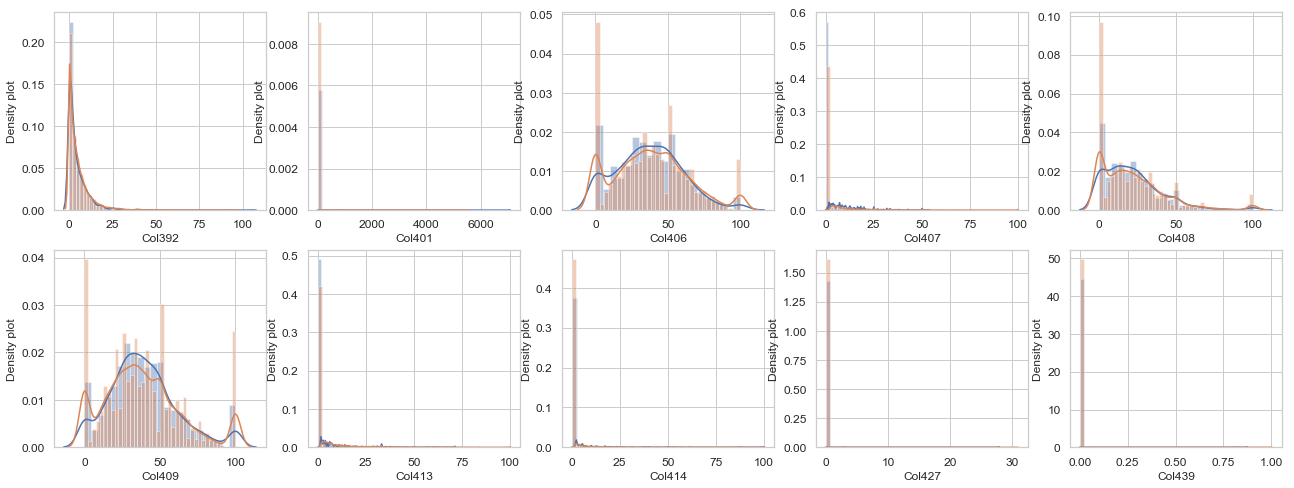

Printing from 190 to 200


<Figure size 432x288 with 0 Axes>

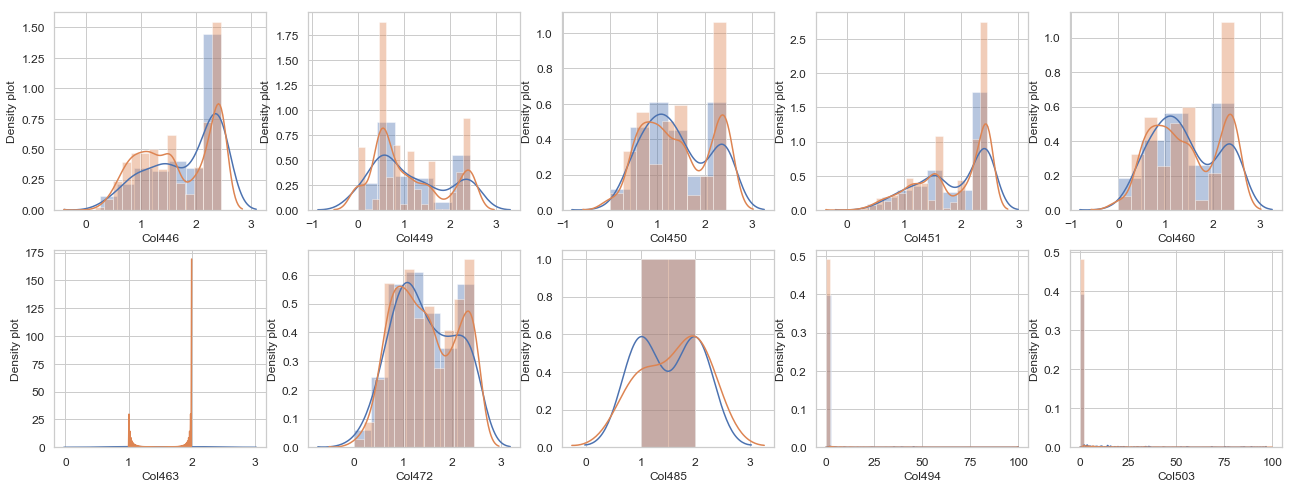

In [70]:
for i in range(10,20):
    print("Printing from {} to {}".format(i*10, (i+1)*10))
    plot_distribution(cat_cols[i*10:(i+1)*10])

In [73]:
import statsmodels as sm

sm.OLS(target, train)

AttributeError: module 'statsmodels' has no attribute 'OLS'

In [74]:
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# Generate artificial data (2 regressors + constant)
nobs = 100 
X = np.random.random((nobs, 2)) 
X = sm.add_constant(X)
beta = [1, .1, .5] 
e = np.random.random(nobs)
y = np.dot(X, beta) + e 

# Fit regression model
print(sm.OLS(y, X).fit().params)

print(LinearRegression(fit_intercept=False).fit(X, y).coef_)

[1.46810215 0.21360706 0.45045609]
[1.46810215 0.21360706 0.45045609]


In [75]:
ols = sm.OLS(target, sm.add_constant(train)).fit()

MissingDataError: exog contains inf or nans

In [76]:
LinearRegression(fit_intercept=False).fit(train, target)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [59]:
train[num_cols[-100:]].isnull().sum()

Col761     2613
Col762     2542
Col765     2171
Col766     2551
Col767    11485
Col769    12688
Col770    11050
Col771     1044
Col772     1147
Col773     1921
Col774    11838
Col775     2611
Col776     5129
Col777    13275
Col778    14973
Col779    11428
Col780     1192
Col781     2202
Col782     1067
Col783     1929
Col784    11838
Col785     2620
Col786     5130
Col787    10732
Col788    14973
Col789     2598
Col790    11428
Col792     1195
Col793     2208
Col794     1068
Col795     3318
Col796    13235
Col797     4008
Col798     6526
Col802     2589
Col803     3599
Col804     2464
Col805     3326
Col806    13235
Col807     4017
Col808     6527
Col809    12129
Col811     3995
Col812    12825
Col814     2592
Col815     3605
Col816     2465
Col817     4008
Col818     6347
Col819    12912
Col820    14112
Col821     4017
Col823    14265
Col825     6347
Col828    13367
Col829     4017
Col830     3946
Col833     3576
Col834     3954
Col835    12912
Col837    14112
Col838     2611
Col839  

Printing from 0 to 10


ValueError: cannot convert float NaN to integer

<Figure size 432x288 with 0 Axes>

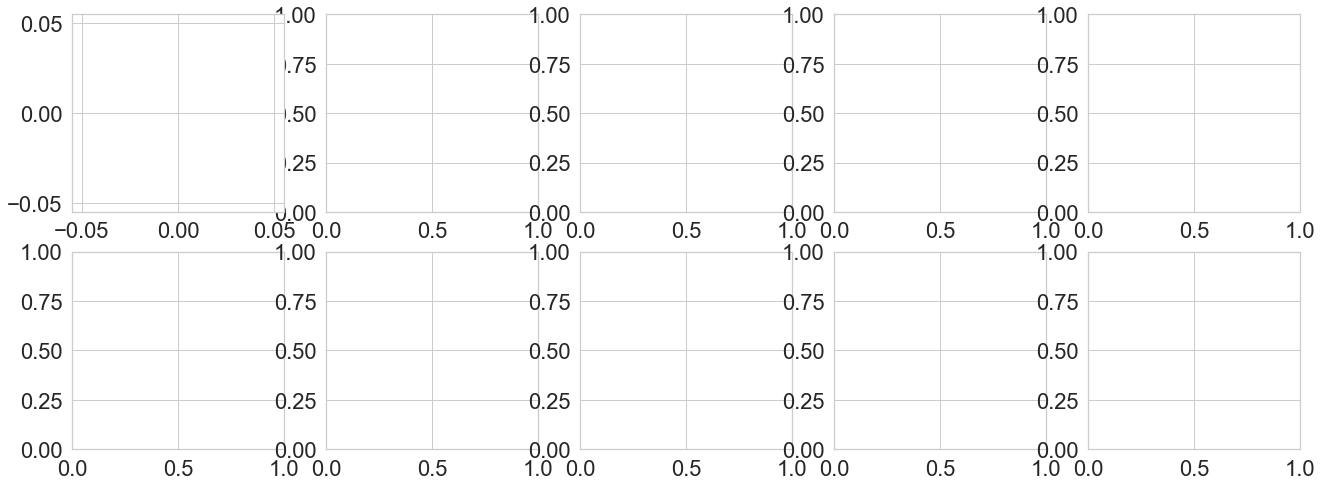

In [51]:
def plot_distribution(var):
    
    i = 0
    t1 = train.loc[target != 0]
    t0 = train.loc[target == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var:
        i += 1
        plt.subplot(2,5,i)
        sns.distplot(t1[feature].dropna().apply(np.log),label="cls: 1")
        sns.distplot(t0[feature].dropna(),label="cls: 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()
    
    
for i in range(10):
    print("Printing from {} to {}".format(i*10, (i+1)*10))
    plot_distribution(num_cols[i*10:(i+1)*10])

In [12]:
oof_cat1

array([0.33073674, 0.11057386, 0.16114838, ..., 0.20314675, 0.08511239,
       0.29220203])

In [13]:
# predi_cat1

In [14]:
# np.mean(predi_cat1, axis=1)

In [15]:
ybins = [1.0 if y > 0.5 else 0 for y in np.mean(predi_cat1, axis=1)]
# y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]

sub_cat1 = pd.DataFrame(data=pd.concat([ts_ids.reset_index(drop=True), pd.DataFrame(ybins)], axis=1))
sub_cat1.columns = ['Col1','Col2']
sub_cat1

Col1  Col2
0      RIGD58ZWD   0.0
1      RIH660YDS   0.0
2      RIH660Q96   0.0
3      RIYDO15W1   0.0
4      RIYBGC1ZD   0.0
5      RIYBQ5SWR   0.0
6      RIYBQ5SD5   0.0
7       TI5HU5XY   0.0
8       TIYHGOSE   0.0
9       T90K61QJ   0.0
10      T7VUCSYG   0.0
11      T10BV81R   0.0
12      T1EWVOZZ   0.0
13      TDYO6BYZ   0.0
14      TDY6VY5E   0.0
15      TYWOUOSR   0.0
16      TYGRLBSY   0.0
17      TYE6VOKZ   1.0
18      TSW65YKE   0.0
19      TS5HVY1Z   0.0
20       TSMKICK   0.0
21      T25ROOSG   0.0
22      99LRCY1W   0.0
23      99YKLSZ5   0.0
24      970WOYQY   0.0
25      97MKU1NG   0.0
26      9LWB6C1J   0.0
27      9L5BQC15   0.0
28      9DMD5CKW   0.0
29      9Y0IVBQZ   0.0
30      9YM6QCYG   0.0
31      9S5HOY59   0.0
32      9SH6IS1Z   0.0
33      9SYK65SD   0.0
34      92GB5SN5   0.0
35      92GR5O4E   0.0
36      92HHL54D   0.0
37      92YBQMNW   0.0
38      92EUCSSZ   0.0
39      9NLDCC4D   0.0
40      9N5ICBZ5   0.0
41      9NMWI049   0.0
42      9NHDCSYD   1.0
43      AILK58QW   0.0
44      AIWWOYXE   0.0
45      AIWRGO1Z   0.0
46      AIGBVONY   1.0
47      AI5R5BZY   0.0
48      AI5HQ04Y   0.0
49      AIMILB1J   0.0
50      AIHROO1E   0.0
51      AIEH5BN5   0.0
52      A9LI5OXD   0.0
53      A9WBQCND   0.0
54      A9GHC5KR   0.0
55      A9HRL8YG   0.0
56      A9HUC8NJ   0.0
57      A9YBV55Y   1.0
58      A7VRQCKE   0.0
59       A7LHQ8Y   0.0
60      A7WIIY4G   0.0
61      A70BC0QZ   0.0
62      A7MR5M4W   0.0
63       A7HRUYZ   0.0
64      A7YDO0KR   0.0
65      A7YRVOKZ   0.0
66      A1VBCYNW   1.0
67      A1WDLMKZ   1.0
68      A1WU6YKJ   0.0
69      A1HIG0Z5   0.0
70      A1HBV01E   0.0
71      A1EROC55   0.0
72      ALLWIO49   0.0
73      ALWKI0YG   1.0
74      ALMKCBXE   0.0
75      ADVDOOXY   0.0
76      ADVW5SNE   0.0
77      ADL6U5QW   0.0
78      AD5KGOYR   0.0
79      ADMI6SZ5   0.0
80      ADMU55YJ   0.0
81      ADM65Y4G   0.0
82      ADHWQBQZ   0.0
83      ADYW51QW   0.0
84      ADED60KR   0.0
85      AYWRQMY5   0.0
86      AYGIG85E   0.0
87      AYGBUCNE   0.0
88      AY5BGCKJ   0.0
89      ASVRGCN9   0.0
90      ASWBCCSJ   0.0
91      AS5OQYNJ   0.0
92      AS5HQCZY   0.0
93      ASHOV5XZ   1.0
94      ASHHO81Y   0.0
95      A2LKCOQ5   1.0
96      A20UI01E   0.0
97      A2MUGSXJ   0.0
98      A2EHL145   0.0
99      ANVKQ01J   0.0
...          ...   ...
20342   OLWUO05G   0.0
20343   OLWUCCYD   0.0
20344   OLWUIY45   0.0
20345   OLWUIYZ9   0.0
20346   OLWUI1N5   0.0
20347   OLWUVYZJ   0.0
20348   OLWU5OZZ   0.0
20349   OLWU50SY   0.0
20350   OLWU51XR   0.0
20351   OLW6GBQZ   0.0
20352   OLW6L1YZ   0.0
20353   OLW6U559   0.0
20354   OLW6USXW   0.0
20355   OLW6USKR   0.0
20356   OLW6Q01J   0.0
20357   OLW6Q0KZ   0.0
20358   OLW66YSJ   0.0
20359   OLW66C5Z   0.0
20360   OLW6OY1W   0.0
20361   OLW6OC1D   0.0
20362   OLW6COSR   0.0
20363   OLW6CSYE   0.0
20364   OLW6CYSD   1.0
20365   OLW6I555   0.0
20366   OLW6V1QW   0.0
20367   OLW65MZJ   0.0
20368   OLW65O1Z   0.0
20369   OLWHGSYY   0.0
20370   OLWHUSNJ   0.0
20371   OLWHU01J   0.0
20372   OLWHU0K5   0.0
20373   OLWHU1Z5   0.0
20374   OLWH6CNR   0.0
20375   OLWH61KD   0.0
20376   OLWHO1YE   0.0
20377   OLWHIM1W   0.0
20378   OLWHI8ND   0.0
20379   OLWHVYSG   0.0
20380   OLWHV15E   0.0
20381   OLWH5MSJ   0.0
20382   OLWH58XZ   0.0
20383   OLWH5S4G   0.0
20384   OLWH5SSZ   0.0
20385   OL0KGB4Z   0.0
20386   OL0KLBXR   0.0
20387   OL0KL5Y5   0.0
20388   OL0KU8XG   0.0
20389   OL0KU5NG   0.0
20390   OL0KQBSJ   0.0
20391   OL0KQ5XJ   0.0
20392   OL0KQ0NG   0.0
20393   OL0K6S5Y   0.0
20394   OL0KO54G   0.0
20395   OL0KO5QW   0.0
20396   OL0KOSSJ   0.0
20397   OL0KCC19   0.0
20398   OL0KISQD   0.0
20399   OL0KICY9   0.0
20400   OL0KVMKR   0.0
20401   OL0KV8Y9   0.0
20402   OL0KVOQY   0.0
20403   OL0KV5NW   0.0
20404   OL0KV5SW   0.0
20405   OL0KV5SZ   0.0
20406   OL0KVS1G   0.0
20407   OL0K5YNJ   0.0
20408   OL0DLBYJ   0.0
20409   OL0DUMQ9   0.0
20410   OL0DQO5J   0.0
20411   OL0D68NW   0.0
20412   OL0DIMYR   0.0
20413   OL0DIY4Y   0.0
20414   OL

In [16]:
no_imp_cat1 = imp_cat1[imp_cat1.imp == 0]['feature'].values

In [41]:
import pandas as pd
import numpy as np
import os, gc
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from hyperopt import hp, tpe, fmin, Trials



def train_cat_model(X_train, y_train, X_valid, y_valid, features, param, num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        features: training features
    Return:
        oof-pred, model
    """
    param['iterations'] = num_round
    
    _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
    _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

    watchlist = [_train, _valid]
    clf = CatBoostClassifier(**param)
    clf.fit(_train, 
            eval_set=watchlist, 
            verbose=False,
            use_best_model=True)
        
    oof  = clf.predict_proba(X_valid[features])[:,1]

    return oof, clf


def run_hyperopt_cat(train_df, target, max_evals):

    def bayesian_opt(params):
        
        params['depth'] = int(params['depth'])
        n_splits = 4
        random_seed = 1234

        folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
        oof_cat = np.zeros(len(train_df))
        score_cv = []

        ##########################
        for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):

            y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
            X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
            features = X_train.columns

            num_rounds = 10000
            oof, clf = train_cat_model(X_train, y_train, 
                                       X_valid, y_valid, 
                                       features, params, 
                                       num_rounds)

            oof_cat[valid_index] = oof
#             score = roc_auc_score(y_valid, oof)
#             score_cv.append(score)
    
#             score = roc_auc_score(y_valid, oof)
#             print( "  auc = ", score )
            y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
            score = f1_score(y_valid, y_bin, average='weighted')
#             print( "  f1 = ", score )
            score_cv.append(score)
#             print("="*60)
            gc.collect()
        
        
        
#         print(np.round(np.mean(score_cv), 4))
#         print( "  cv-auc = ", np.round(np.mean(score_cv), 4),'+/-', np.std(score_cv) )
        return -np.mean(score_cv)
    
    
    bayesian_params = {
        'loss_function'         : "Logloss", 
        'eval_metric'           : "AUC",
        'random_strength'       : hp.quniform('random_strength', 1, 6, 0.2),
        'border_count'          : 128,
        'scale_pos_weight'      : 8.9,#3.507,
        'depth'                 : hp.quniform('depth', 4, 7, 1),
        #hp.choice('depth', [4,5,6,7]), 
        'early_stopping_rounds' : 50,
        'random_seed'           : 1337,
        'task_type'             : 'CPU', 
        # subsample can't be used, while bootstrap (bayesian) is used.
#         'subsample'             : hp.quniform('subsample', 0.3, 0.8, 0.1), 
#         'iterations'            : 10000, 
        'learning_rate'         : hp.quniform('learning_rate',0.01, 0.1, 0.001),
        'thread_count'          : 4,
        'l2_leaf_reg'           : hp.uniform('l2_leaf_reg', 0.1, 5.0),#3,
#         'grow_policy'           : hp.choice('grow_policy', 
#                                             ['SymmetricTree', 'Depthwise', 'Lossguide']),
#         'min_data_in_leaf'      : hp.choice('min_data_in_leaf', np.arange(50, 150, 5)),
        
#         hp.choice('min_data_in_leaf', [
#             {'grow_policy': 'SymmetricTree', 'min_data_in_leaf': None},
#             {'grow_policy': ['Depthwise', 'Lossguide'], 
#              'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(50, 150, 5))},
#             ])
    }
     
    
    trials = Trials()
    results = fmin(bayesian_opt, bayesian_params, algo=tpe.suggest, 
                   trials=trials, max_evals=max_evals)
        
    return results, trials 



In [42]:
# clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train.drop(no_imp_cat1, axis=1), target, test.drop(no_imp_cat1, axis=1), depth=4)
results, trials = run_hyperopt_cat(train.drop(no_imp_cat1, axis=1), target, max_evals=100)

100%|██████████| 100/100 [11:30:57<00:00, 319.60s/it, best loss: -0.7720095478599176] 


In [44]:
results

{'depth': 7.0,
 'l2_leaf_reg': 3.0753960899722625,
 'learning_rate': 0.063,
 'random_strength': 3.8000000000000003}

In [50]:
train.drop(no_imp_cat1, axis=1).shape, test.drop(no_imp_cat1, axis=1).shape

((17521, 1428), (20442, 1428))

In [58]:
imp_cat1[imp_cat1.imp == 0]['feature'].values

array(['Col2078', 'Col1958', 'Col1956', 'Col1953', 'Col1952', 'Col1951',
       'Col1949', 'Col1948', 'Col1947', 'Col1946', 'Col1945', 'Col1942',
       'Col820', 'Col1939', 'Col1938', 'Col1935', 'Col1961', 'Col1962',
       'Col1964', 'Col1965', 'Col1999', 'Col1998', 'Col1996', 'Col812',
       'Col813', 'Col1991', 'Col1985', 'Col1934', 'Col1981', 'Col1979',
       'Col1977', 'Col1976', 'Col1975', 'Col1972', 'Col1971', 'Col1966',
       'Col1980', 'Col1933', 'Col821', 'Col1928', 'Col1884', 'Col829',
       'Col1876', 'Col1874', 'Col1869', 'Col1868', 'Col833', 'Col1885',
       'Col1866', 'Col1863', 'Col1862', 'Col1861', 'Col1860', 'Col1857',
       'Col1850', 'Col1848', 'Col1864', 'Col200', 'Col1886', 'Col1890',
       'Col1923', 'Col1922', 'Col1920', 'Col825', 'Col1917', 'Col1913',
       'Col1912', 'Col1888', 'Col1909', 'Col1905', 'Col1903', 'Col1901',
       'Col1900', 'Col190', 'Col1899', 'Col1897', 'Col1906', 'Col2000',
       'Col2001', 'Col2003', 'Col2104', 'Col2103', 'Col2102'

In [61]:
np.equal(no_imp_cat1, imp_cat1[imp_cat1.imp == 0]['feature'].values).sum(), len(no_imp_cat1)

(963, 963)

In [71]:
clf_cat3, imp_cat3, oof_cat3, predi_cat3 = run_cv_cat(train.drop(no_imp_cat1, axis=1), target, test.drop(no_imp_cat1, axis=1), depth=5)


(13140,) (4381,)
Fold 0
0:	test: 0.6474857	test1: 0.6395844	best: 0.6395844 (0)	total: 178ms	remaining: 29m 38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7176254935
bestIteration = 19

Shrink model to first 20 iterations.
  auc =  0.7176254935138183
  f1 =  0.8654814760329295
(13141,) (4380,)
Fold 1
0:	test: 0.5558767	test1: 0.5419858	best: 0.5419858 (0)	total: 270ms	remaining: 44m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7181847024
bestIteration = 32

Shrink model to first 33 iterations.
  auc =  0.7181847023534841
  f1 =  0.8574206518557851
(13141,) (4380,)
Fold 2
0:	test: 0.5968266	test1: 0.5780734	best: 0.5780734 (0)	total: 256ms	remaining: 42m 43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7175963313
bestIteration = 9

Shrink model to first 10 iterations.
  auc =  0.7175963313336409
  f1 =  0.8600050454457503
(13141,) (4380,)
Fold 3
0:	test: 0.5603114	test1: 0.5551791	best: 0.5551791 (0)	total: 239ms

In [72]:
ybins = [1.0 if y > 0.5 else 0 for y in oof_cat3]
print(cr(target, ybins))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     15760
           1       0.30      0.25      0.27      1761

   micro avg       0.87      0.87      0.87     17521
   macro avg       0.61      0.59      0.60     17521
weighted avg       0.86      0.87      0.86     17521



In [52]:
ybins = [1.0 if y > 0.5 else 0 for y in oof_cat3]
print(cr(target, ybins))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     15760
           1       0.27      0.25      0.26      1761

   micro avg       0.86      0.86      0.86     17521
   macro avg       0.59      0.59      0.59     17521
weighted avg       0.85      0.86      0.85     17521



In [67]:
ybins = [1.0 if y > 0.5 else 0 for y in np.mean(predi_cat3, axis=1)]
# y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
del sub_cat1
gc.collect()
sub_cat3 = pd.DataFrame(data=pd.concat([ts_ids.reset_index(drop=True), pd.DataFrame(ybins)], axis=1))
sub_cat3.columns = ['Col1','Col2']
sub_cat3

Col1  Col2
0      RIGD58ZWD   0.0
1      RIH660YDS   0.0
2      RIH660Q96   0.0
3      RIYDO15W1   0.0
4      RIYBGC1ZD   0.0
5      RIYBQ5SWR   1.0
6      RIYBQ5SD5   0.0
7       TI5HU5XY   0.0
8       TIYHGOSE   0.0
9       T90K61QJ   0.0
10      T7VUCSYG   0.0
11      T10BV81R   0.0
12      T1EWVOZZ   0.0
13      TDYO6BYZ   0.0
14      TDY6VY5E   0.0
15      TYWOUOSR   0.0
16      TYGRLBSY   0.0
17      TYE6VOKZ   1.0
18      TSW65YKE   0.0
19      TS5HVY1Z   0.0
20       TSMKICK   0.0
21      T25ROOSG   0.0
22      99LRCY1W   0.0
23      99YKLSZ5   0.0
24      970WOYQY   0.0
25      97MKU1NG   0.0
26      9LWB6C1J   0.0
27      9L5BQC15   0.0
28      9DMD5CKW   0.0
29      9Y0IVBQZ   0.0
30      9YM6QCYG   0.0
31      9S5HOY59   0.0
32      9SH6IS1Z   0.0
33      9SYK65SD   0.0
34      92GB5SN5   0.0
35      92GR5O4E   0.0
36      92HHL54D   0.0
37      92YBQMNW   0.0
38      92EUCSSZ   0.0
39      9NLDCC4D   0.0
40      9N5ICBZ5   0.0
41      9NMWI049   0.0
42      9NHDCSYD   1.0
43      AILK58QW   0.0
44      AIWWOYXE   0.0
45      AIWRGO1Z   0.0
46      AIGBVONY   1.0
47      AI5R5BZY   0.0
48      AI5HQ04Y   0.0
49      AIMILB1J   0.0
50      AIHROO1E   0.0
51      AIEH5BN5   0.0
52      A9LI5OXD   0.0
53      A9WBQCND   0.0
54      A9GHC5KR   0.0
55      A9HRL8YG   0.0
56      A9HUC8NJ   0.0
57      A9YBV55Y   1.0
58      A7VRQCKE   0.0
59       A7LHQ8Y   0.0
60      A7WIIY4G   0.0
61      A70BC0QZ   0.0
62      A7MR5M4W   0.0
63       A7HRUYZ   0.0
64      A7YDO0KR   0.0
65      A7YRVOKZ   0.0
66      A1VBCYNW   1.0
67      A1WDLMKZ   1.0
68      A1WU6YKJ   0.0
69      A1HIG0Z5   0.0
70      A1HBV01E   0.0
71      A1EROC55   0.0
72      ALLWIO49   0.0
73      ALWKI0YG   1.0
74      ALMKCBXE   0.0
75      ADVDOOXY   0.0
76      ADVW5SNE   0.0
77      ADL6U5QW   0.0
78      AD5KGOYR   0.0
79      ADMI6SZ5   0.0
80      ADMU55YJ   0.0
81      ADM65Y4G   0.0
82      ADHWQBQZ   0.0
83      ADYW51QW   0.0
84      ADED60KR   0.0
85      AYWRQMY5   0.0
86      AYGIG85E   0.0
87      AYGBUCNE   0.0
88      AY5BGCKJ   0.0
89      ASVRGCN9   0.0
90      ASWBCCSJ   0.0
91      AS5OQYNJ   0.0
92      AS5HQCZY   0.0
93      ASHOV5XZ   1.0
94      ASHHO81Y   0.0
95      A2LKCOQ5   1.0
96      A20UI01E   0.0
97      A2MUGSXJ   0.0
98      A2EHL145   0.0
99      ANVKQ01J   0.0
...          ...   ...
20342   OLWUO05G   0.0
20343   OLWUCCYD   0.0
20344   OLWUIY45   0.0
20345   OLWUIYZ9   0.0
20346   OLWUI1N5   0.0
20347   OLWUVYZJ   0.0
20348   OLWU5OZZ   0.0
20349   OLWU50SY   0.0
20350   OLWU51XR   0.0
20351   OLW6GBQZ   0.0
20352   OLW6L1YZ   0.0
20353   OLW6U559   0.0
20354   OLW6USXW   0.0
20355   OLW6USKR   0.0
20356   OLW6Q01J   0.0
20357   OLW6Q0KZ   0.0
20358   OLW66YSJ   0.0
20359   OLW66C5Z   0.0
20360   OLW6OY1W   0.0
20361   OLW6OC1D   0.0
20362   OLW6COSR   0.0
20363   OLW6CSYE   0.0
20364   OLW6CYSD   0.0
20365   OLW6I555   0.0
20366   OLW6V1QW   0.0
20367   OLW65MZJ   0.0
20368   OLW65O1Z   0.0
20369   OLWHGSYY   0.0
20370   OLWHUSNJ   0.0
20371   OLWHU01J   0.0
20372   OLWHU0K5   0.0
20373   OLWHU1Z5   0.0
20374   OLWH6CNR   0.0
20375   OLWH61KD   0.0
20376   OLWHO1YE   0.0
20377   OLWHIM1W   0.0
20378   OLWHI8ND   0.0
20379   OLWHVYSG   0.0
20380   OLWHV15E   0.0
20381   OLWH5MSJ   0.0
20382   OLWH58XZ   0.0
20383   OLWH5S4G   0.0
20384   OLWH5SSZ   0.0
20385   OL0KGB4Z   0.0
20386   OL0KLBXR   0.0
20387   OL0KL5Y5   0.0
20388   OL0KU8XG   0.0
20389   OL0KU5NG   0.0
20390   OL0KQBSJ   0.0
20391   OL0KQ5XJ   0.0
20392   OL0KQ0NG   0.0
20393   OL0K6S5Y   0.0
20394   OL0KO54G   0.0
20395   OL0KO5QW   0.0
20396   OL0KOSSJ   0.0
20397   OL0KCC19   0.0
20398   OL0KISQD   0.0
20399   OL0KICY9   0.0
20400   OL0KVMKR   0.0
20401   OL0KV8Y9   0.0
20402   OL0KVOQY   0.0
20403   OL0KV5NW   0.0
20404   OL0KV5SW   0.0
20405   OL0KV5SZ   0.0
20406   OL0KVS1G   0.0
20407   OL0K5YNJ   0.0
20408   OL0DLBYJ   0.0
20409   OL0DUMQ9   0.0
20410   OL0DQO5J   0.0
20411   OL0D68NW   0.0
20412   OL0DIMYR   0.0
20413   OL0DIY4Y   0.0
20414   OL

In [66]:
np.bincount(sub_cat1['Col2'].astype('int'))

array([18796,  1646])

In [70]:
sub_cat3.to_csv('predictions/sub_cat_with_tuning.csv', index=None)

In [17]:
np.bincount(target)

array([15760,  1761])

In [69]:
15760/1761, 18796/1646

(8.94946053378762, 11.419198055893075)

In [ ]:
import time
for col in imp_cat3.tail(50)['feature'].values:
    plt.figure(figsize=(16,5))
    try:
        sns.distplot(train[col])
        sns.distplot(test[col])
    except:
        sns.countplot(train[col])
        sns.countplot(test[col])
    time.sleep(1)

In [19]:
sub_cat1.to_csv('predictions/sub_cat1.csv', index=None)

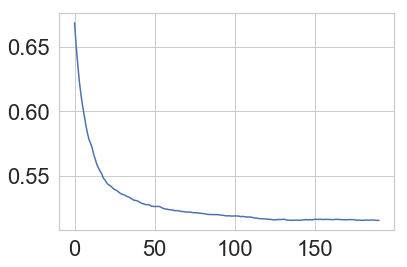

In [29]:
plt.plot(clf_cat1[0].evals_result_['validation_1']['Logloss'])

In [46]:
no_imp_cat1 = imp_cat1[imp_cat1.imp == 0]['feature'].values
clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train.drop(no_imp_cat1, axis=1), target, test.drop(no_imp_cat1, axis=1), depth=4)


(13140,) (4381,)
Fold 0
0:	test: 0.6511902	test1: 0.6595419	best: 0.6595419 (0)	total: 132ms	remaining: 21m 57s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7430211679
bestIteration = 55

Shrink model to first 56 iterations.
  auc =  0.7430211678580061
  f1 =  0.8740968697108293
(13141,) (4380,)
Fold 1
0:	test: 0.5572453	test1: 0.5582135	best: 0.5582135 (0)	total: 112ms	remaining: 18m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7409797531
bestIteration = 73

Shrink model to first 74 iterations.
  auc =  0.7409797531149054
  f1 =  0.8670481824072024
(13141,) (4380,)
Fold 2
0:	test: 0.6302473	test1: 0.6302247	best: 0.6302247 (0)	total: 105ms	remaining: 17m 29s
200:	test: 0.8071700	test1: 0.7389654	best: 0.7398157 (189)	total: 20.7s	remaining: 16m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7408147785
bestIteration = 241

Shrink model to first 242 iterations.
  auc =  0.740814778495616
  f1 =  0.868962362504332

In [48]:
from sklearn.metrics import classification_report as cr

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat1]
print(cr(target, ybins))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     15760
           1       0.36      0.22      0.27      1761

   micro avg       0.88      0.88      0.88     17521
   macro avg       0.64      0.59      0.61     17521
weighted avg       0.86      0.88      0.87     17521



In [ ]:
             precision    recall  f1-score   support

           0       0.92      0.95      0.93     15760
           1       0.36      0.25      0.30      1761

   micro avg       0.88      0.88      0.88     17521
   macro avg       0.64      0.60      0.61     17521
weighted avg       0.86      0.88      0.87     17521



In [ ]:
clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train.drop(no_imp_cat1, axis=1), target, test.drop(no_imp_cat1, axis=1), depth=6)

print("\n\n")
print("="*60)
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat1]
print(cr(target, ybins))

In [8]:
import random, math

def grouping_cols(df, cat_percentage = 0.05, checking_itr = 10):
    cc, nc = [], []
    max_ = 0
    amount = int(df.shape[0]*cat_percentage)
    print(amount, "/", df.shape[0]," Used to differentiate num feature from cat feature")
    for col in df.columns:
        uni = df[col].unique().shape[0]
#         print(uni)
        max_ = max(max_, uni)
        if(uni <= amount):
            cc.append(col)
        else:
            nc.append(col)
        
    print("-----Filtered result after Ist stage-----")
    print("total cat cols: {}, total num cols: {}\n".format(len(cc), len(nc)))
    
    true_cat = []
    true_num = []
    for col in nc+cc:
        num = False
        if(df[col].dtype == 'object'):
            true_cat.append(col)
            continue
        for i in range(checking_itr):
            sample = np.random.choice(df[col].unique())
            if math.isnan(sample): continue
            if int(sample) != sample:
                num = True
        if num is True:
            true_num.append(col)
        else:
            true_cat.append(col)

    print("-----Filtered result after 2nd stage-----")
    print("total cat cols: {}, total num cols: {}".format(len(true_cat), len(true_num)))
    return cc, nc


In [9]:
cat_cols, num_cols = grouping_cols(train, cat_percentage=0.025)


438 / 17521  Used to differentiate num feature from cat feature
-----Filtered result after Ist stage-----
total cat cols: 1725, total num cols: 668

-----Filtered result after 2nd stage-----
total cat cols: 1639, total num cols: 754


In [59]:
# def factorize_cat(table, cat_cols=None):
#     print("=== Factorize Done ====")
#     for col in cat_cols:
#         table[col], _ = pd.factorize(table[col])
#     return table

# df = factorize_cat(df, cat_cols)

In [10]:
train1 = train.drop(no_imp_cat1, axis=1)
test1  = test.drop(no_imp_cat1, axis=1)

new_cat_cols = [col for col in cat_cols if col not in no_imp_cat1]
train1[new_cat_cols] = train1[new_cat_cols].astype("category")
test1[new_cat_cols] = test1[new_cat_cols].astype("category")
train1.shape, test1.shape

NameError: name 'no_imp_cat1' is not defined

In [112]:
gc.collect()

22015

In [61]:
clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train1, target, test1, depth=4)

print("\n\n")
print("="*60)
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat1]
print(cr(target, ybins))

(13140,) (4381,)
Fold 0
0:	test: 0.6511902	test1: 0.6595419	best: 0.6595419 (0)	total: 114ms	remaining: 19m 2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7430211679
bestIteration = 55

Shrink model to first 56 iterations.
  auc =  0.7430211678580061
  f1 =  0.8740968697108293
(13141,) (4380,)
Fold 1
0:	test: 0.5572453	test1: 0.5582135	best: 0.5582135 (0)	total: 108ms	remaining: 18m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7409797531
bestIteration = 73

Shrink model to first 74 iterations.
  auc =  0.7409797531149054
  f1 =  0.8670481824072024
(13141,) (4380,)
Fold 2
0:	test: 0.6302473	test1: 0.6302247	best: 0.6302247 (0)	total: 117ms	remaining: 19m 31s
200:	test: 0.8071700	test1: 0.7389654	best: 0.7398157 (189)	total: 20.7s	remaining: 16m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7408147785
bestIteration = 241

Shrink model to first 242 iterations.
  auc =  0.740814778495616
  f1 =  0.8689623625043329


In [63]:
clf_cat2, imp_cat2, oof_cat2, predi_cat2 = run_cv_cat(train1, target, test1, depth=6)

print("\n\n")
print("="*60)
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat2]
print(cr(target, ybins))

(13140,) (4381,)
Fold 0
0:	test: 0.6702522	test1: 0.6581558	best: 0.6581558 (0)	total: 268ms	remaining: 44m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7431092234
bestIteration = 127

Shrink model to first 128 iterations.
  auc =  0.7431092233847854
  f1 =  0.8759306910222753
(13141,) (4380,)
Fold 1
0:	test: 0.5655123	test1: 0.5629127	best: 0.5629127 (0)	total: 243ms	remaining: 40m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.744643228
bestIteration = 114

Shrink model to first 115 iterations.
  auc =  0.7446432279649284
  f1 =  0.866465179602157
(13141,) (4380,)
Fold 2
0:	test: 0.6354518	test1: 0.6323102	best: 0.6323102 (0)	total: 322ms	remaining: 53m 40s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7323979003
bestIteration = 32

Shrink model to first 33 iterations.
  auc =  0.7323979003230272
  f1 =  0.8670967317676023
(13141,) (4380,)
Fold 3
0:	test: 0.6570216	test1: 0.6201465	best: 0.6201465 (0)	total: 23

In [66]:
len(new_cat_cols), len(cat_cols)

(892, 1725)

In [68]:
train.shape, train1.shape

((17521, 2393), (17521, 1360))

In [106]:
# train.select_dtypes("category")
# 'Col702', 'Col733', 'Col742', 'Col763', 'Col791', 'Col813', 'Col822', 'Col831', 'Col852'
train['Col702'].value_counts()

0.000000    1395
0.255551       2
0.442620       1
0.079860       1
0.069985       1
0.057143       1
0.058166       1
Name: Col702, dtype: int64

In [111]:
train[['Col702', 'Col733', 'Col742', 'Col763', 'Col791', 'Col813', 'Col822', 'Col831', 'Col852']].isnull().sum()

Col702    16119
Col733    16979
Col742    16708
Col763    15313
Col791    16117
Col813    17514
Col822    16985
Col831    16744
Col852    15347
dtype: int64

In [110]:
set(no_imp_cat1).intersection(set(['Col702', 'Col733', 'Col742', 'Col763', 'Col791', 'Col813', 'Col822', 'Col831', 'Col852']))

{'Col763', 'Col813', 'Col822', 'Col831', 'Col852'}

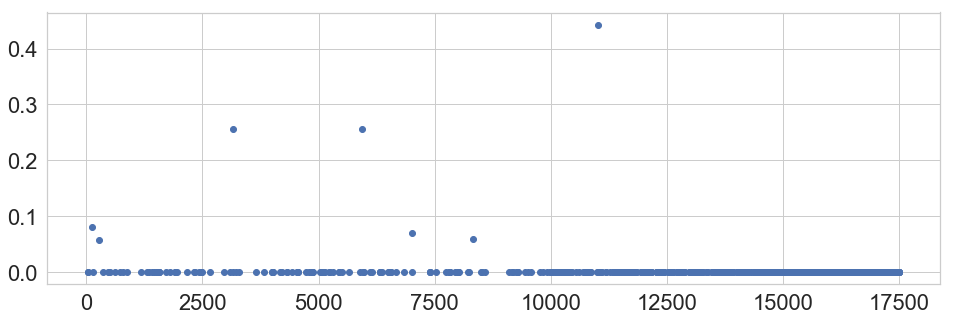

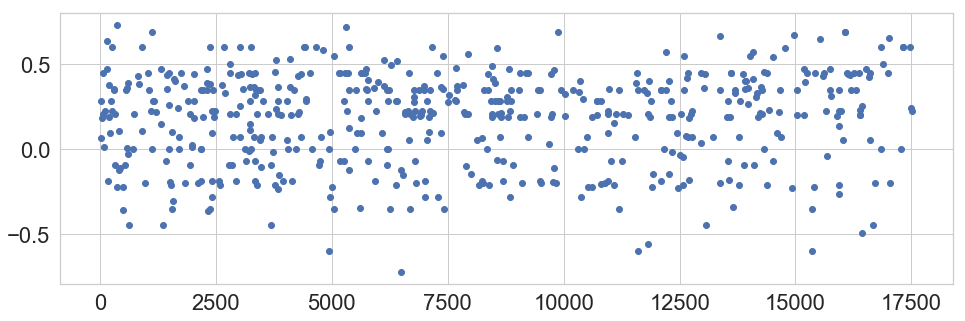

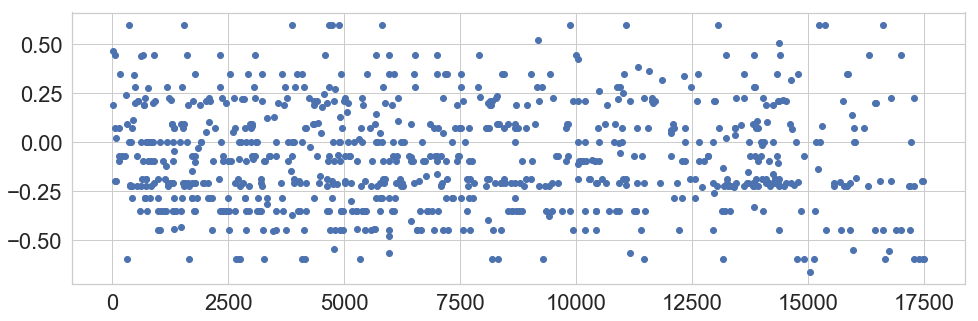

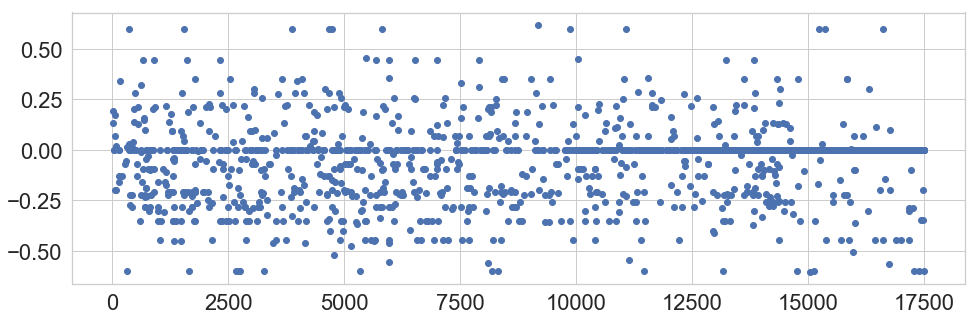

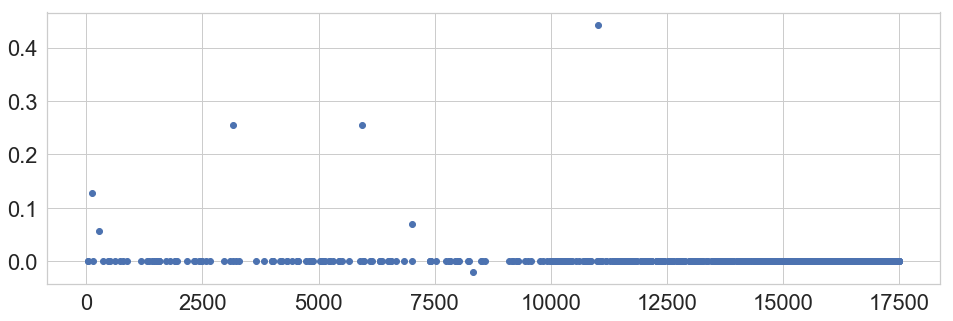

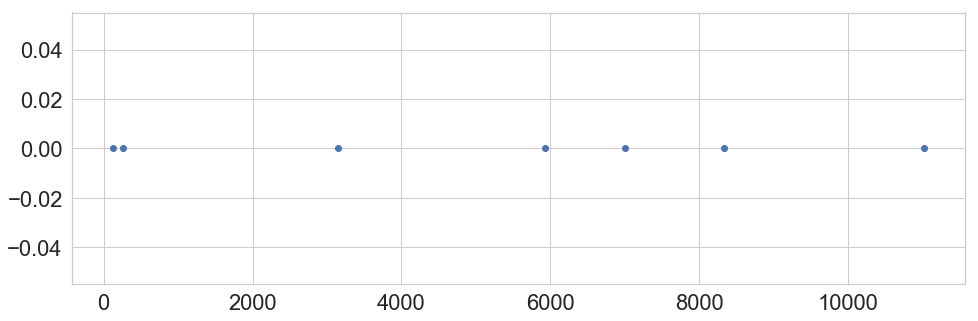

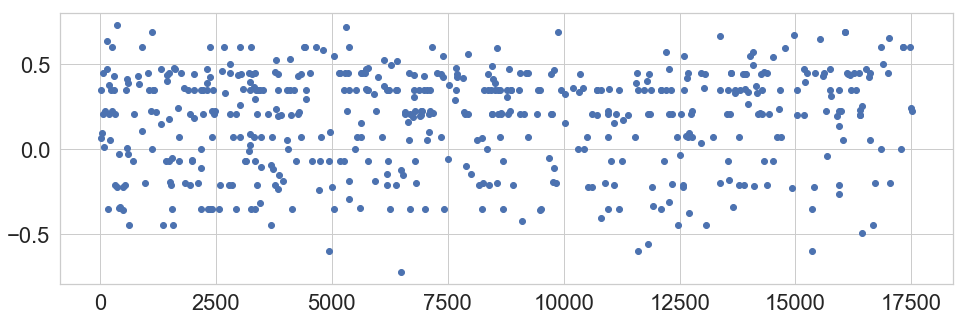

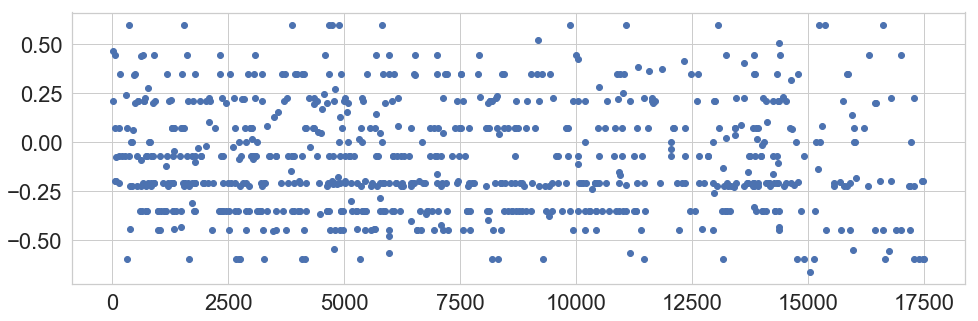

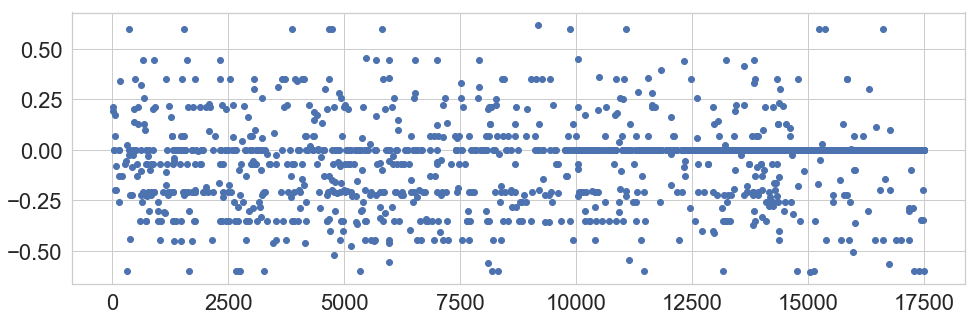

In [109]:
for col in ['Col702', 'Col733', 'Col742', 'Col763', 'Col791', 'Col813', 'Col822', 'Col831', 'Col852']:
    plt.figure(figsize=(16,5))
    plt.plot(train[col],'o')

In [105]:
gc.collect()

422

In [99]:
clf_lgb1, imp_lgb1, oof_lgb1, predi_lgb1 = run_cv_lgb(train, target, test, leaves=50)

print("\n\n")
print("="*60)
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_lgb1]
print(cr(target, ybins))

using leaves:  50
(13140,) (4381,)
Fold 0
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[74]	training's auc: 0.800229	valid_1's auc: 0.736953


ValueError: DataFrame.dtypes for data must be int, float or bool. Did not expect the data types in fields Col702, Col733, Col742, Col763, Col791, Col813, Col822, Col831, Col852

In [97]:
# train1[new_cat_cols] = train1[new_cat_cols].astype("category")
# test1[new_cat_cols] = test1[new_cat_cols].astype("category")


In [98]:
clf_lgb1, imp_lgb1, oof_lgb1, predi_lgb1 = run_cv_lgb(train1, target, test1, leaves=60)

print("\n\n")
print("="*60)
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_lgb1]
print(cr(target, ybins))

using leaves:  60
(13140,) (4381,)
Fold 0


ValueError: DataFrame.dtypes for data must be int, float or bool. Did not expect the data types in fields Col865, Col867, Col868, Col869, Col878, Col879, Col882, Col883, Col887, Col888, Col889, Col890, Col891, Col894, Col895, Col896, Col897, Col898, Col899, Col900, Col903, Col904, Col905, Col906, Col907, Col908, Col909, Col911, Col912, Col913, Col914, Col915, Col917, Col919, Col924, Col927, Col928, Col929, Col930, Col935, Col936, Col938, Col941, Col944, Col946, Col949, Col951, Col952, Col954, Col958, Col959, Col961, Col962, Col963, Col966, Col967, Col970, Col971, Col975, Col977, Col978, Col980, Col982, Col983, Col985, Col989, Col991, Col992, Col993, Col994, Col999, Col1000, Col1001, Col1006, Col1007, Col1008, Col1009, Col1010, Col1012, Col1013, Col1014, Col1015, Col1020, Col1021, Col1028, Col1029, Col1030, Col1032, Col1036, Col1037, Col1038, Col1040, Col1041, Col1042, Col1043, Col1044, Col1046, Col1047, Col1051, Col1053, Col1056, Col1057, Col1059, Col1060, Col1061, Col1062, Col1063, Col1064, Col1065, Col1069, Col1071, Col1074, Col1079, Col1082, Col1084, Col1087, Col1088, Col1089, Col1091, Col1092, Col1093, Col1094, Col1095, Col1097, Col1099, Col1103, Col1106, Col1107, Col1108, Col1109, Col1110, Col1113, Col1114, Col1116, Col1120, Col1121, Col1130, Col1131, Col1132, Col1135, Col1136, Col1137, Col1138, Col1141, Col1143, Col1144, Col1145, Col1146, Col1150, Col1151, Col1152, Col1154, Col1161, Col1162, Col1164, Col1167, Col1168, Col1172, Col1173, Col1174, Col1176, Col1179, Col1180, Col1181, Col1183, Col1184, Col1185, Col1186, Col1187, Col1188, Col1189, Col1192, Col1193, Col1197, Col1198, Col1199, Col1200, Col1202, Col1204, Col1205, Col1207, Col1208, Col1209, Col1211, Col1212, Col1213, Col1215, Col1217, Col1220, Col1222, Col1224, Col1227, Col1229, Col1230, Col1231, Col1232, Col1233, Col1234, Col1236, Col1238, Col1241, Col1242, Col1245, Col1246, Col1249, Col1258, Col1263, Col1266, Col1267, Col1268, Col1272, Col1277, Col1279, Col1281, Col1283, Col1287, Col1288, Col1290, Col1291, Col1292, Col1293, Col1294, Col1299, Col1302, Col1303, Col1304, Col1305, Col1309, Col1310, Col1311, Col1313, Col1315, Col1316, Col1317, Col1319, Col1321, Col1322, Col1330, Col1332, Col1333, Col1339, Col1340, Col1343, Col1344, Col1345, Col1346, Col1349, Col1351, Col1352, Col1354, Col1357, Col1360, Col1363, Col1364, Col1365, Col1367, Col1371, Col1373, Col1374, Col1375, Col1377, Col1380, Col1381, Col1383, Col1385, Col1386, Col1387, Col1389, Col1391, Col1393, Col1394, Col1395, Col1396, Col1398, Col1400, Col1402, Col1403, Col1406, Col1407, Col1408, Col1409, Col1410, Col1412, Col1413, Col1416, Col1418, Col1421, Col1422, Col1423, Col1425, Col1426, Col1428, Col1431, Col1432, Col1433, Col1439, Col1441, Col1442, Col1443, Col1444, Col1450, Col1451, Col1453, Col1454, Col1455, Col1456, Col1459, Col1464, Col1467, Col1469, Col1471, Col1477, Col1478, Col1479, Col1480, Col1485, Col1488, Col1489, Col1491, Col1496, Col1497, Col1498, Col1499, Col1500, Col1502, Col1503, Col1505, Col1506, Col1511, Col1512, Col1518, Col1519, Col1521, Col1522, Col1523, Col1524, Col1525, Col1527, Col1528, Col1531, Col1535, Col1538, Col1540, Col1541, Col1542, Col1544, Col1545, Col1550, Col1551, Col1552, Col1554, Col1556, Col1560, Col1564, Col1566, Col1571, Col1572, Col1573, Col1574, Col1575, Col1576, Col1577, Col1579, Col1581, Col1582, Col1584, Col1585, Col1587, Col1590, Col1592, Col1593, Col1594, Col1597, Col1599, Col1600, Col1602, Col1603, Col1608, Col1610, Col1612, Col1616, Col1626, Col1628, Col1629, Col1632, Col1633, Col1634, Col1640, Col1645, Col1652, Col1654, Col1655, Col1657, Col1658, Col1660, Col1664, Col1669, Col1670, Col1672, Col1674, Col1676, Col1677, Col1681, Col1683, Col1684, Col1688, Col1689, Col1691, Col1692, Col1693, Col1694, Col1697, Col1701, Col1704, Col1706, Col1707, Col1712, Col1713, Col1717, Col1718, Col1720, Col1722, Col1723, Col1726, Col1728, Col1730, Col1731, Col1735, Col1738, Col1739, Col1740, Col1743, Col1744, Col1745, Col1746, Col1748, Col1749, Col1752, Col1753, Col1755, Col1756, Col1759, Col1760, Col1761, Col1762, Col1764, Col1766, Col1767, Col1768, Col1776, Col1777, Col1778, Col1781, Col1788, Col1789, Col1791, Col1793, Col1794, Col1795, Col1796, Col1797, Col1800, Col1801, Col1802, Col1803, Col1804, Col1805, Col1807, Col1813, Col1814, Col1815, Col1816, Col1818, Col1821, Col1822, Col1823, Col1825, Col1828, Col1830, Col1831, Col1832, Col1833, Col1834, Col1835, Col1836, Col1837, Col1838, Col1839, Col1843, Col1844, Col1846, Col1848, Col1851, Col1852, Col1853, Col1855, Col1857, Col1858, Col1859, Col1861, Col1866, Col1867, Col1875, Col1878, Col1879, Col1880, Col1881, Col1886, Col1890, Col1892, Col1895, Col1896, Col1898, Col1902, Col1906, Col1909, Col1910, Col1912, Col1913, Col1916, Col1917, Col1918, Col1920, Col1921, Col1922, Col1925, Col1928, Col1929, Col1930, Col1939, Col1940, Col1942, Col1943, Col1944, Col1945, Col1946, Col1950, Col1953, Col1955, Col1956, Col1957, Col1958, Col1962, Col1963, Col1964, Col1967, Col1968, Col1971, Col1976, Col1978, Col1982, Col1988, Col1989, Col1990, Col1993, Col1996, Col1997, Col2002, Col2003, Col2007, Col2008, Col2009, Col2011, Col2012, Col2013, Col2015, Col2017, Col2018, Col2019, Col2023, Col2024, Col2025, Col2032, Col2033, Col2034, Col2035, Col2036, Col2037, Col2039, Col2040, Col2043, Col2046, Col2047, Col2048, Col2049, Col2051, Col2052, Col2053, Col2056, Col2057, Col2059, Col2060, Col2061, Col2063, Col2064, Col2067, Col2069, Col2072, Col2073, Col2077, Col2078, Col2082, Col2083, Col2085, Col2087, Col2089, Col2090, Col2093, Col2095, Col2099, Col2104, Col2106, Col2117, Col2118, Col2119, Col2120, Col2122, Col2125, Col2127, Col2128, Col2129, Col2132, Col2133, Col2134, Col2135, Col2136, Col2142, Col2143, Col2144, Col2145, Col2146, Col2147, Col2148, Col2149, Col2157, Col2159, Col2161, Col2162, Col2163, Col2166, Col2167, Col2171, Col2172, Col2173, Col2174, Col2175, Col2176, Col2180, Col2181, Col2184, Col2186, Col2187, Col2189, Col2190, Col2191, Col2193, Col2196, Col2197, Col2198, Col2201, Col2202, Col2204, Col2207, Col2208, Col2209, Col2210, Col2211, Col2212, Col2215, Col2216, Col2217, Col2218, Col2220, Col2221, Col2222, Col2224, Col2225, Col2227, Col2228, Col2229, Col2231, Col2233, Col2234, Col2236, Col2238, Col2239, Col2240, Col2242, Col2251, Col2254, Col2255, Col2256, Col2258, Col2260, Col2261, Col2263, Col2264, Col2266, Col2268, Col2269, Col2270, Col2271, Col2274, Col2277, Col2279, Col2281, Col2282, Col2283, Col2284, Col2285, Col2288, Col2293, Col2294, Col2296, Col2299, Col2302, Col2303, Col2306, Col2307, Col2309, Col2310, Col2312, Col2313, Col2315, Col2316, Col2318, Col2320, Col2321, Col2322, Col2324, Col2326, Col2327, Col2328, Col2330, Col2331, Col2333, Col2336, Col2337, Col2338, Col2339, Col2340, Col2349, Col2357, Col2363, Col2364, Col2366, Col2368, Col2370, Col2371, Col2372, Col2373, Col2382, Col2383, Col2384, Col2385, Col2386, Col2391, Col2392, Col2393, Col2394, Col2395, Col2397

In [82]:
imp_lgb1.to_csv('lgb_new.csv', index=None)
imp_cat1.to_csv('cat_new.csv', index=None)